# COCO Project 2024

# ReadMe

## Failure Scenarios for PID
  - This standard PID controller cannot incorporate any constraints. This limitation, together with the lack of prediction, leads to failure modes every time a relatively large meal is eaten, and as there is no anti-reset wind-up, pump saturation can lead to undesirable behaviour in real applications. In addition, this standard PID controller cannot react correctly to delays, which leads to control problems (a Smith predictor could help).
  - A failure mode is already observed when using the *default meal values* (`default_data.csv`): meal intakes of $35$, $45$ and $45$ grams for breakfast, lunch and dinner, respectively.
  - A more dangerous failure mode occurs when a larger breakfast of $60$ grams is eaten (`large_B_data.csv`), while lunch and dinner are smaller with $30$ grams. The daily carbohydrate intake is therefore less than the *default meal values*. The glucose level remains below the hypoglycaemic threshold for many hours, potentially killing the patient. In addition, the pump saturates and the hyperglycaemic threshold is also violated. (*Note*: many other failure modes are possible).

## Implementation of Tracking MPC
  - The tracking Model Predictive Control (MPC) is implemented to follow the steady-state values, to include constraints on the insulin injections, future meals and on hypoglycaemia, to include delay of the insulin effect on glucose concentration, to be DPP (Disciplined Parametrized Programming) compliant for efficient computation, and to achieve $100\%$ Time-in-Target. (detailed explanation [below](#mpc_task))
  - A version with higher discretization size is also proposed, where the simulation only takes a few seconds while still achieving $100\%$ Time-in-Target, and the soft constraint for hyperglycaemia is added.

### Parameter Tuning
  - The weights in the cost function $Q$ and $S$ that penalize the states and $r$ that penalizes the input, as well as the prediction horizon $T_\mathrm{p}$ and the sampling time $T_\text{s}$ (and the discretization time $T_\mathrm{d}$). (detailed explanation [below](#mpc_tuning))

### Parameter Tuning Strategy and Recommendation
  - As explained [below](#mpc_tuning_iteration), the strategy for tuning the tracking MPC is as follows:
    1. Take the maximum values of the PID failure case using *default meal values* and use them to normalize $Q = S$ and $r$ and then express them with respect to the square deviation of the glucose level $G(t)$ with the glucose stady-state reference.
    2. Set all weights to $1$ times the normalization.
    3. Choose $T_\mathrm{p}$ and $T_\mathrm{s}$ (and $T_\mathrm{d}$) so that the simulation is fast and the future prediction is good (in this case $T_\mathrm{p}$ ranges from $2$ to $5$ hours).
    4. Remove weights for states with high normalization that can cause solver problems.
    5. Tune $Q$ and $r$ (and $s$) until $100\%$ Time-in-Target is reached.
  - As this strategy depends on the PID failure mode, an alternative approach could be to normalize the weights by the inverse covariance matrix obtained by running a standardized test on the specific patient, where standard meals, snacks, and exercises are performed. The iteration to tune the controller is then similar to above. Alternatively, if time and computing power permit, a grid search could be performed.

## Implementation of regularized DeePC
  - First, a brief investigation of the lag and the properties of the Hankel matrix is carried out.
  - Since our system is nonlinear, a regularized Data-enabled Predictive Control (DeePC) is proposed. Insulin and future meals as well as hard and soft constraints on the glucose concentration are included in the DPP-compliant problem. The delay of the insulin effect on the glucose concentration is already accounted for in the data and therefore no further implementations are required. (detailed explanation [below](#deepc_math_description))

### Parameter Tuning
  - The weights in the cost function $Q$ and $S$ that penalize the outputs, $r$ that penalizes the input, the relaxation and regularization terms $\lambda_g$ and $\lambda_\sigma$, and the slack cost $s$ for the soft constraint of hyperglycaemia, as well as the prediction horizon $T_\mathrm{p}$, the sampling time $T_\text{s}$, and the discretization time $T_\mathrm{d}$ as well as the number of columns of the Hankel matrix $\mathcal{H}$. (detailed explanation [below](#deepc_tuning))

### Parameter Tuning Strategy and Recommendation
  - As explained [below](#deepc_tuning_iteration), the proposed and actually used tuning strategy is as follows:
    1. Set all tuning parameters that affect tracking ($\lambda_g$, $\lambda_\sigma$, $Q$, $r$ and $s$) to $1$.
    2. Set the number of columns of $\mathcal{H}$ to satisfy the width-to-height ratio of about $2$ to $2.5$ as explained [here](#deepc_tuning_data).
    3. Choose $T_\mathrm{p}$, $T_\mathrm{s}$, $T_\mathrm{d}$ and $T_\mathrm{ini}$ so that the simulation is fast (about $30$ seconds), gives a good future prediction ($T_\mathrm{p}$ ranges from $2$ to $5$ hours) and has enough past data.
    4. Set $\lambda_\sigma$ to a high value to ensure accuracy in the initial state estimation. Good indicators are the additional plots.
    5. Slowly increase $\lambda_g$ until the tracking improves.
    6. Set $r$ to $10^6$ as this reflects the order of magnitude found for MPC and avoids bang-bang control actions.
    7. Tune $Q$ and $s$ until $100\%$ Time-in-Target is reached.

## Implementation Considerations of Regularized DeePC Corrupted by Noise
  - To develop a more realistic controller, we can modify the regularized DeePC from before by exclusively considering the physically measurable glucose output. (detailed explanation [below](#task5_bonus))
  - Additionally, this controller can be tested with the provided data corrupted by small white Gaussian noise.
  - The tuning iteration is the same as before.

# ReplayBG


## ReplayBG Model

The ReplayBG simulation is defined by the following differential equations:

<div>
    <img src="model.png" width="1000"/>
</div>

### Outputs

The output is the blood glucose. This hypoglycemia limit of $70$ (mg/dl) is a hard lower-limit for blood glucose, as dropping below $70$ (mg/dl) is a significant health risk. In addition, if possible, blood glucose should be kept below $180$ (mg/dl). This hyperglycaemia limit is a "soft constraint" rather than a hard constraint - minor infractions are not critical, but it is better to keep blood glucose below $180$ (mg/dl) if possible.

### Inputs

Two inputs affect glucose levels:
- $i(t)$: Exogenous/Basal insulin injections (units "U" of insulin). Controlled.
- $m(t)$: Carbohydrate intake/"meals" (g). Not controlled.

Thus, the input is two-dimensional: $\textbf{u} = \begin{bmatrix}i(t) & m(t) \end{bmatrix}^T$. In the literature, $i(t)$ is also refered to as $I(t)$ or *basal insulin*, and $m(t)$ is also refered to as $CHO(t)$.

While we cannot control the meals, we assume that the meal injections are known by the controller (hence, being an "input" rather than a disturbance). 

The meals are determined by the `data_cho.csv` file and are parsed by the ```get_discretized_meals()``` function, which multiplies the values in the `data.csv` file by 5 because each meal takes 5 minutes. 

The controller determines the exogenous insulin injection in control time intervals that are specified by the user (e.g. 5 or 10 minutes). The control time interval is a design decision for you to make. 

### Insulin Limits

The maximum exogenous/basal insulin injection $i(t)$ is 0.04, and the minimum is 0.

### Default Meal Values

The default meal values, which InsulinCo is interested in with the initial (model-based and data-driven) control designs, are 35 g for breakfast and 45 g for lunch and dinner.

For the bonus, you might consider larger/different meals.

### State Variables
The state of the system is defined by the following variables:
- $G_p(t)$: Plasma glucose concentration (mg/dl);
- $X(t)$: Insulin action on glucose disposal and production (1/min);
- $Q_{sto1}(t)$: Amount of insulin in the stomach in solid state (mg/kg);
- $Q_{sto2}(t)$: Amount of insulin in the stomach in liquid state (mg/kg);
- $Q_{gut}(t)$: Glucose concentration in the intestine (mg/kg);
- $I_{sc1}(t)$: Insulin in a non-monomeric state (mU/kg);
- $I_{sc2}(t)$: Insulin in a monomeric state (mU/kg);
- $I_p(t)$: Plasma insulin concentration (mU/I);
- $G(t)$: interstitial glucose concentration (mg/dl);

For following the ReplayBG practices, the state equation is set as:
$$x(t) = \begin{bmatrix} G_p(t) & X(t) & Q_{sto1}(t) & Q_{sto2}(t) & Q_{gut}(t) & I_{sc1}(t) & I_{sc2}(t)& I_p(t) & G(t) \end{bmatrix}^T$$

### System Equations
The nonlinear Differential Equations which describe the behavior of the system are the following:

$\dot{G_p}(t) = -[SG + \rho(G)X(t)] \cdot G_p(t) + SG \cdot G_{b} + R_{\alpha}(t)/V_G$

$\dot{X}(t) = -p_2 \cdot [X(t) - SI \cdot (I_p(t) - I_pb)]$

$\dot{Q}_{sto1}(t) = -k_{empt} \cdot Q_{sto1}(t) + m(t)$

$\dot{Q}_{sto2}(t) = k_{empt} \cdot Q_{sto1}(t) - k_{empt} \cdot Q_{sto2}(t)$

$\dot{Q}_{gut}(t) = k_{empt} \cdot Q_{sto2}(t) - k_{abs} \cdot Q_{gut}(t)$

$\dot{I}_{sc1}(t) = -k_{d}\cdot I_{sc1}(t) + i(t-\beta / V_{I})$

$\dot{I}_{sc2}(t) = k_{d}\cdot I_{sc1}(t) - k_{\alpha2} \cdot I_{sc2}(t)$

$\dot{I}_{p}(t) = k_{\alpha2} \cdot I_{sc2}(t) - k_{e} \cdot I_{p}(t)$

$\dot{G}(t) = -\frac{1}{\alpha}(G(t) - G_p(t))$

where, $k_{d}, k_{\alpha2}, k_e, \beta, k_{empt}, k_{abs}, \alpha, p_2$ are parameters describing the rate of diffusion and absorption of insulin, $V_{I}$ is the volume of insulin distribution, $R_{\alpha}(t)$ is the rate of glucose appearance in plasma, $SG$ is the glucose effectiveness, $G_b$ is the basal glucose concentration in the plasma, $V_G$ is the volume of glucose distribution, $I_{pb}$ is the basal insulin concentration in the plasma, $SI$ is the insulin sensitivity, $\rho(G)$ is a function to better represent glucose dynamics in the hypoglycemic range. 

The $I$ variables and the associated equations describe the absorption dynamics of exogenous insulin infusion to the plasma, the $Q$ variables describe the glucose absorption due to meals, and the last 3 equations describe the glucose-insulin kinetics subsystem.  

### Linearized Equations

We linearized the nonlinear dynamics above around the steady state
$$x_{ss} = \begin{bmatrix}120.0 & 0.0016 & 0.0 & 0.0 & 0.0 & 1.5081 &10.2735 & 0.2827 & 120.0\end{bmatrix}$$
using a discretization step of 1 minute.
The linearized dynamics model has the form

$$\textbf{x}_{k+1} = A \textbf{x}_{k} + B\textbf{u}_{k} + h.$$
 
- $A \in \mathbb{R}^{9\times9}$ is the dynamics matrix,
- $B \in \mathbb{R}^{9\times2}$ is the input matrix, and
- $h \in \mathbb{R}^{9\times1}$ is the offset constant produced by the linearization.

<h2 id="replayBG_specifics">ReplayBG Specifics</h2>

```simulate()``` runs a sytem simulation. It takes the following inputs:
- basal_handler: the function/controller that returns the  basal insulin injection value
- basal_handler_params: dict() with parameters defined by the control designer that can be accessed during simulation by the handler
- data_given: a pandas dataframe that describes the meal intake. The example below shows how to create the dataframe by reading the meal csv file (the control designer may change the csv file or define multiple csv files/dataframes as needed)
- meal_input_modulation_factor: constant that modules the impact of a meal (the default value should be used)

```T1DModel```: The T1DModel class is a part of ReplayBG's simulator and describes the glucose dynamics. It takes the following inputs:
- data: pandas dataframe which contains the preliminary meal data ("data" is not very relevant as it is overwritten with data_given when ```simulate()``` is called)
- bw: the body weight of the patient (the default value should be used)
- yts: The continuous glucose measurement (cgm) sample time (the default value should be used)
- glucose_model: the model equation to be used as measured glucose ('IG' should be used)
- is_single_meal: a flag indicating if the model will be used as single meal or multi meal (the default value (False) should be used)
- exercise: a boolean indicating if the model includes exercise (the default value (False) should be used)

The initial control design should not need most of the inputs, as InsulinCo is primarily interested in performance on the basic/default case. For the bonus, you could consider changing some of the inputs. Keep in mind, InsulinCo is primarily interested in new control methods rather than exhaustive studies, so any parameter changes should be used/changed to demonstrate the value of a given controller, not for the sake of an exhaustive study.

Below are some additional functions from InsulinCo intended to make the ReplayBG simulator easier to use.

`get_linearization()`: InsulinCO has provided this function to you to help design your controllers. It linearizes the dynamics around a given operating point but does *not* take into account the basal insulin injection delay. This means that for a given time index $t$ and a delay $\tau$, the basal insulin injection value returned by the controller will only be seen by the system at the time step $t+\tau$. This also means that for the same $t$, the control actions at the time steps between $t$ and $t+\tau-1$ are already defined and cannot be changed. 

Note: The ReplayBG simulator has a delay that is not included in the linearization. This delay must be factored in separately from the linearizaed dynamics described by the matrix $A$.

`get_discretized_meals()`: InsulinCo has provided this function to you to help interface between the ReplayBG simulator and the csv (that you may edit) that defines the meals. `get_discretized_meals()` is helpful because of how ReplayBG processes the meal data. Specifically, ReplayBG does some operations on the values written in the csv file to get the value of $m(t)$. Thus, to access this internal variable of ReplayBG, InsulinCo created this function which returns a vector with the all the $m[k]$ in a certain interval of time and according to a discretization time step. 

## Imports

In [1]:
################################### Necessary Imports ##########################################

# Module for generationg the metrics
from py_agata.py_agata import Agata
from py_agata.time_in_ranges import time_in_target
from py_agata.utils import glucose_time_vectors_to_dataframe

# Function to plot the results
from plot_results import plot_results

# Function to run the simulation
from replay_bg_wrapper import simulate
from py_replay_bg.model.t1d_model import T1DModel
from py_replay_bg.py_replay_bg import ReplayBG

# Python imports
import pandas as pd
import os
import numpy as np
from random import randint

# Convex optimization problems with Python
from cvxpy.reductions.solvers.defines import QP_SOLVERS
import cvxpy as cp

# Added to plot and display
from IPython.display import display
import matplotlib.pyplot as plt
from plot_save_results_presentation import plot_save_results_presentation

In [2]:
######################## additional functions for ReplayBG's T1DModel class  ###################
# Here define some additional functions for the T1DModel class that you may find useful.
################################################################################################

def get_discretized_meals(self, initial_time_step, duration, T):
    """
    Parameters
    ----------
    initial_time_step : initial time step of the intended interval that we want to get the meals from
    duration : duration of the interval that we want to get the meals from
    T : discretization step
    
    Returns
    -------
    meal : a vector with all the meals in the time interval given
    """
    meal = np.zeros((duration//T, ))
    for k in range((duration)):
        meal[k//T] += self.meal_ALL_delayed[initial_time_step+k]
    return meal
    
def get_linearization(self, T, x):
    """
    Provides the linearization parameters, given the discretization interval and the state at which the linearization is done.
    
    Parameters
    ----------
    T : discretization step
    x : linearization point
    
    Returns
    -------
    A, B, h : discretized linear state equations
    """
    x0 = x[0]
    x1 = x[1]

    mp = self.model_parameters

    k1_T = 1 / (1 + T*mp.kgri)
    k2_T = T*mp.kgri / (1 + T*mp.kempt)
    k3_T = 1 / (1 + T*mp.kempt)
    kb_T = 1 / (1 + T*mp.kabs_avg)
    ki1_T = 1 / (1 + T*mp.kd)
    ki2_T = 1 / (1 + T*mp.ka2)
    kie_T = 1 / (1 + T*mp.ke)

    x1_c_T = mp.p2 * mp.SI / mp.VI * T/(1+mp.p2*T)
    x4_c_T = T*mp.kempt * kb_T
    x6_c_T = T*mp.kd * ki2_T
    x7_c_T = T*mp.ka2 * kie_T

    df_dx0 = -mp.SG - x1 * (1 + mp.r1)
    df_dx1 = -x0 * (1 + mp.r1)
    df_dx4 = (mp.f * mp.kabs_avg) / mp.VG
    dx0_dt = -mp.SG*x0 -x0*x1*(1 + mp.r1) + mp.SG*mp.Gb
    div = (1-T*df_dx0)

    #                      x0               x1            x2      x3         x4        x5           x6            x7         x8
    self.Alinear[:] =  [ [1/div         , T*df_dx1/div , 0   , 0     , T*df_dx4/div, 0     , 0             , 0           , 0             ],
                         [0             , 1/(1+mp.p2*T), 0   , 0     , 0           , 0     , x1_c_T*x7_c_T , x1_c_T*kie_T, 0             ],
                         [0             , 0            , k1_T, 0     , 0           , 0     , 0             , 0           , 0             ],
                         [0             , 0            , k2_T, k3_T  , 0           , 0     , 0             , 0           , 0             ],
                         [0             , 0            , 0   , x4_c_T, kb_T        , 0     , 0             , 0           , 0             ],
                         [0             , 0            , 0   , 0     , 0           , ki1_T , 0             , 0           , 0             ],
                         [0             , 0            , 0   , 0     , 0           , x6_c_T, ki2_T         , 0           , 0             ],
                         [0             , 0            , 0   , 0     , 0           , 0     , x7_c_T        , kie_T       , 0             ], 
                         [T/(T+mp.alpha), 0            , 0   , 0     , 0           , 0     , 0             , 0           , mp.alpha/(T+mp.alpha)]]

    self.Blinear[:] = [0, 0, 0, 0, 0, T/(1+T*mp.kd)*mp.to_mgkg, 0, 0, 0]
    self.Mlinear[:] = [0, 0, k1_T, 0, 0, 0, 0, 0, 0]
    self.hlinear[:] = [ T*(dx0_dt - x0*df_dx0 - x1*df_dx1)/div, 0, 0, 0, 0, 0, 0, 0, 0]

    return self.Alinear, np.vstack((self.Blinear, self.Mlinear)).T, self.hlinear

## Data

Different data are used for tuning and testing. In the `data` folder there are the following data:
- `zero_test.csv`: No meals. Used for steady-state tracking,
- `large_B_data.csv`: Breakfast of 60 grams, lunch and dinner of 30 grams. Used for PID failure mode,
- `default_data.csv`: Breakfast of 35 grams, lunch and dinner of 45 grams. Used for MPC and DeePC, and
- `data_cho.csv`: Breakfast of 20 grams, lunch and dinner of 30 grams. Used for PID current situation.

In [3]:
##################################### Modify csv data TESTS and DEFAULT ###############################

discretization_time_meal = 5 #min

# Load the CSV File
df_cho = pd.read_csv('data/data_cho.csv')

df_default = df_cho.copy()

# Default meal values
m_B = 35 #g for breakfast
m_L = 45 #g for lunch
m_D = 45 #g for dinner

df_default.loc[df_default['cho_label'] == 'B', 'cho'] = m_B / discretization_time_meal
df_default.loc[df_default['cho_label'] == 'L', 'cho'] = m_L / discretization_time_meal
df_default.loc[df_default['cho_label'] == 'D', 'cho'] = m_D / discretization_time_meal

df_default.to_csv(os.path.join(os.path.abspath(''), 'data', 'default_data.csv'))

# Large breakfast test
df_large_B = df_cho.copy()
m_B_large = 60 #g

df_large_B.loc[df_large_B['cho_label'] == 'B', 'cho'] = m_B_large / discretization_time_meal
df_large_B.to_csv(os.path.join(os.path.abspath(''), 'data', 'large_B_data.csv'))

# Delete meals
df_zero = df_cho.copy()
df_zero = df_zero[~df_zero['cho_label'].isin(['B', 'L', 'D'])]
df_zero.to_csv(os.path.join(os.path.abspath(''), 'data', 'zero_test.csv'))

# PID Controller


The following code initializes Insulin Co's PID controller. 

In [4]:
class PIDController:
    def __init__(self, Ki, Kd, Kp):
        self.Ki = Ki
        self.Kd = Kd
        self.Kp = Kp
        self.integral = 0
        self.prev_error = 0

        # Values to analyze the order of magnitude for MPC tuning
        self.xss = None
        self.uss = None
        self.x = np.zeros((9, ))
    
    def compute_pid(self, model, x0, tau, time_index, inputs_, xss, uss, dss):
        # Save states for MPC tuning
        if time_index == 0:
            self.xss = xss
            self.uss = uss
        else:
            self.x = np.vstack([self.x, x0])

        # Error calculation from the desired setpoint
        error = x0[8] - xss[8]
    
        # Integral, Derivative, and Proportional terms of PID
        self.integral += error * 1
        derivative = (error - self.prev_error) / 1
        self.prev_error = error
        
        # Calculate PID control output
        control_output = self.Ki * self.integral + self.Kd * derivative + self.Kp * error + uss
        
        # Ensure control output is within valid limits (e.g., non-negative)
        control_output = max(0, control_output)
        
        return control_output, dss

    def restart(self):
        self.integral = 0
        self.prev_error = 0

## Task 1: Current State 

The code below demonstrates how InsulinCo's PID controller performs in a standard operating condition.

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'variability': {'mean_glucose': 122.65355028519447, 'median_glucose': 120.26056550281733, 'std_glucose': 26.869338035133808, 'cv_glucose': 21.90669407665504, 'range_glucose': 90.90301479452403, 'iqr_glucose': 44.946043775795204, 'auc_glucose': 213417.17749623838, 'gmi': 6.243872922821852, 'cogi': 98.52625074340096, 'conga': 42.449822456051436, 'j_index': 22.35709413165336, 'mage_plus_index': 46.22777718793265, 'mage_minus_index': 55.63183627179643, 'mage_index': 50.92980672986454, 'ef_index': 1.0, 'modd': 28.798608546801873, 'sddm_index': 24.879590305486293, 'sdw_index': 18.72602395737301, 'std_glucose_roc': 0.07819465292797119, 'cvga': 1106.1688945948463}, 'time_in_ranges': {'time_in_target': 100.0, 'time_in_tight_target': 72.01149425287356, 'time_in_hypoglycemia': 0.0, 'time_in_l1_hypoglycemia': 0.0, 'time_in_l2_hypoglycemia': 0.0, 'time_in_hyperglycemia': 0.0, 'time_in_l1_hyperglycemia': 0.0, 'time_in_l2_hyperglycemia': 0.0}, 'risk': {'adrr': 6.790894967157421, 'lbgi': 0.5100314284

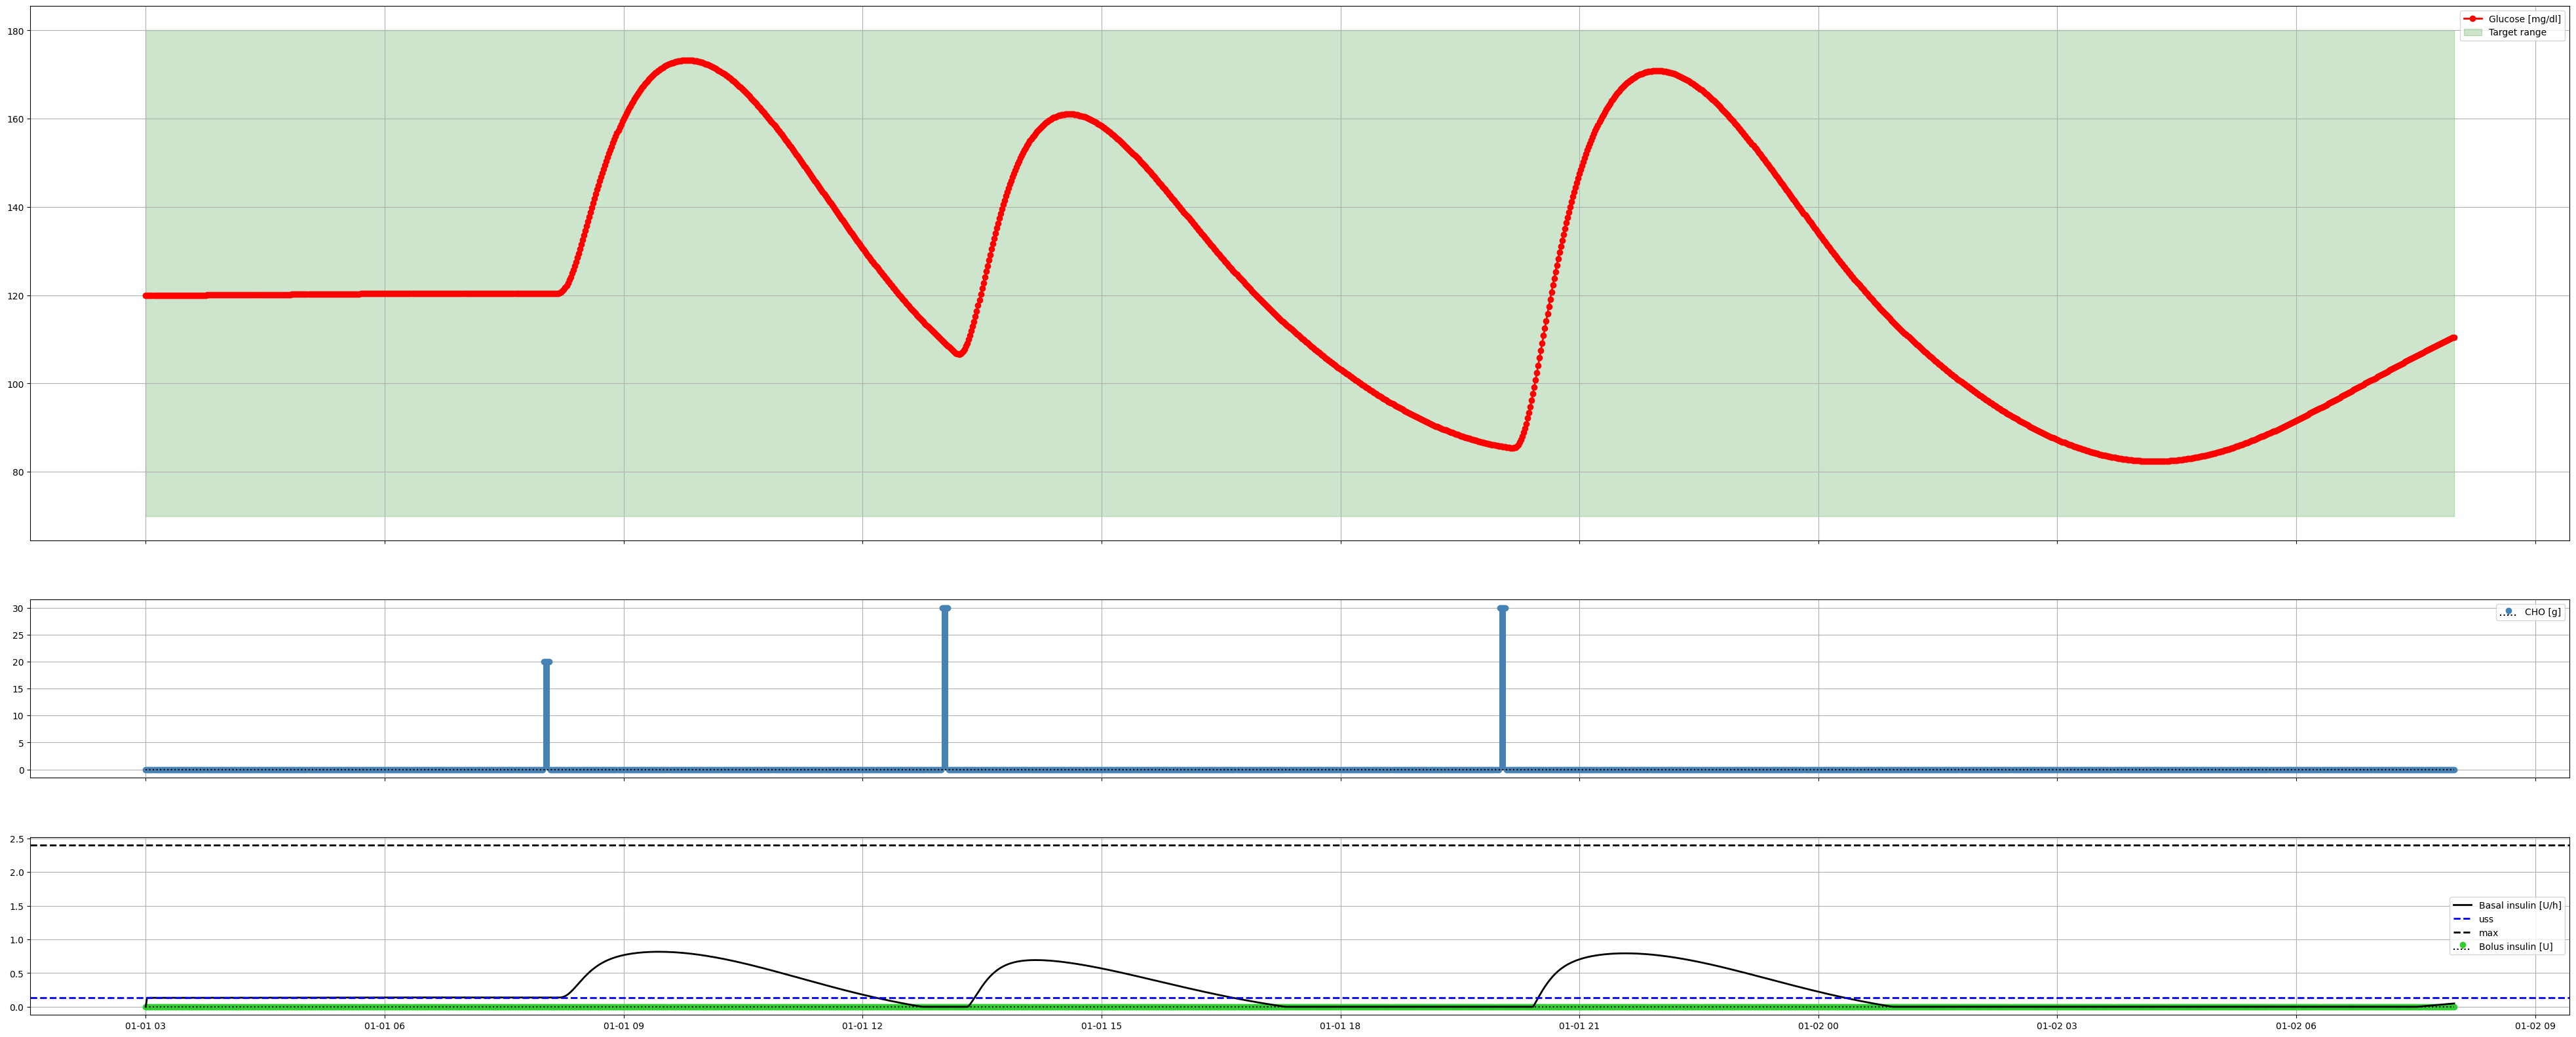

In [5]:
##################################### Demonstration of InsulinCo's PID control  ###################################

basal_handler_params = dict()
basal_handler_params['default_rate'] = 0.01

# Get test data
data_given = pd.read_csv('data/data_cho.csv')

# Instatiating PID Controller
pid_controller_current_state = PIDController(Ki=0.0, Kd=0.005, Kp=0.0002)

# Running the simulation
glucose, i, insulin_bolus, m, time = simulate(basal_handler=pid_controller_current_state.compute_pid,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)

data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)
title = 'PID Controller - Current State'
name_png = 'task_01_pid_current_state.png'
save = False
plot_save_results_presentation(glucose=glucose, insulin_bolus=insulin_bolus, i=i, m=m, time=time, plot=False, title=title, save=save, save_name=name_png, save_path='img')

## Task 2: Failure Mode

1. InsulinCo is interested in controllers that can work with the *default meal values*. A first failure mode is observed when testing the PID with these values. (*Note*: This failure mode is used to tune the tracking MPC as explained [below](#mpc_tuning))
2. An even more demonstrative failure mode is observed when the patient eats a relatively large breakfast of about $60$ grams, while still consuming less carbohydrate during the whole day.

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\py_agata\variability\__init__.py:729: RuntimeWarning: Mean of empty slice
  mage_day_plus[d] = np.nanmean(excursions[excursions > 0])


{'variability': {'mean_glucose': 111.15449366128983, 'median_glucose': 120.00630595765423, 'std_glucose': 47.63693573047607, 'cv_glucose': 42.85650913550596, 'range_glucose': 171.58526013730108, 'iqr_glucose': 73.15097163814465, 'auc_glucose': 193408.81897064432, 'gmi': 5.968815488378053, 'cogi': 40.959246867019154, 'conga': 70.56828205431378, 'j_index': 25.214718048280183, 'mage_plus_index': 51.39519772889448, 'mage_minus_index': 95.51317487447857, 'mage_index': 73.45418630168652, 'ef_index': 3.0, 'modd': 71.41085034304949, 'sddm_index': 49.05134311726265, 'sdw_index': 32.16634167865649, 'std_glucose_roc': 0.12850578334301457, 'cvga': 4293.91134679647}, 'time_in_ranges': {'time_in_target': 61.7816091954023, 'time_in_tight_target': 48.96551724137931, 'time_in_hypoglycemia': 26.379310344827587, 'time_in_l1_hypoglycemia': 10.689655172413794, 'time_in_l2_hypoglycemia': 15.689655172413794, 'time_in_hyperglycemia': 11.839080459770114, 'time_in_l1_hyperglycemia': 11.839080459770114, 'time_in

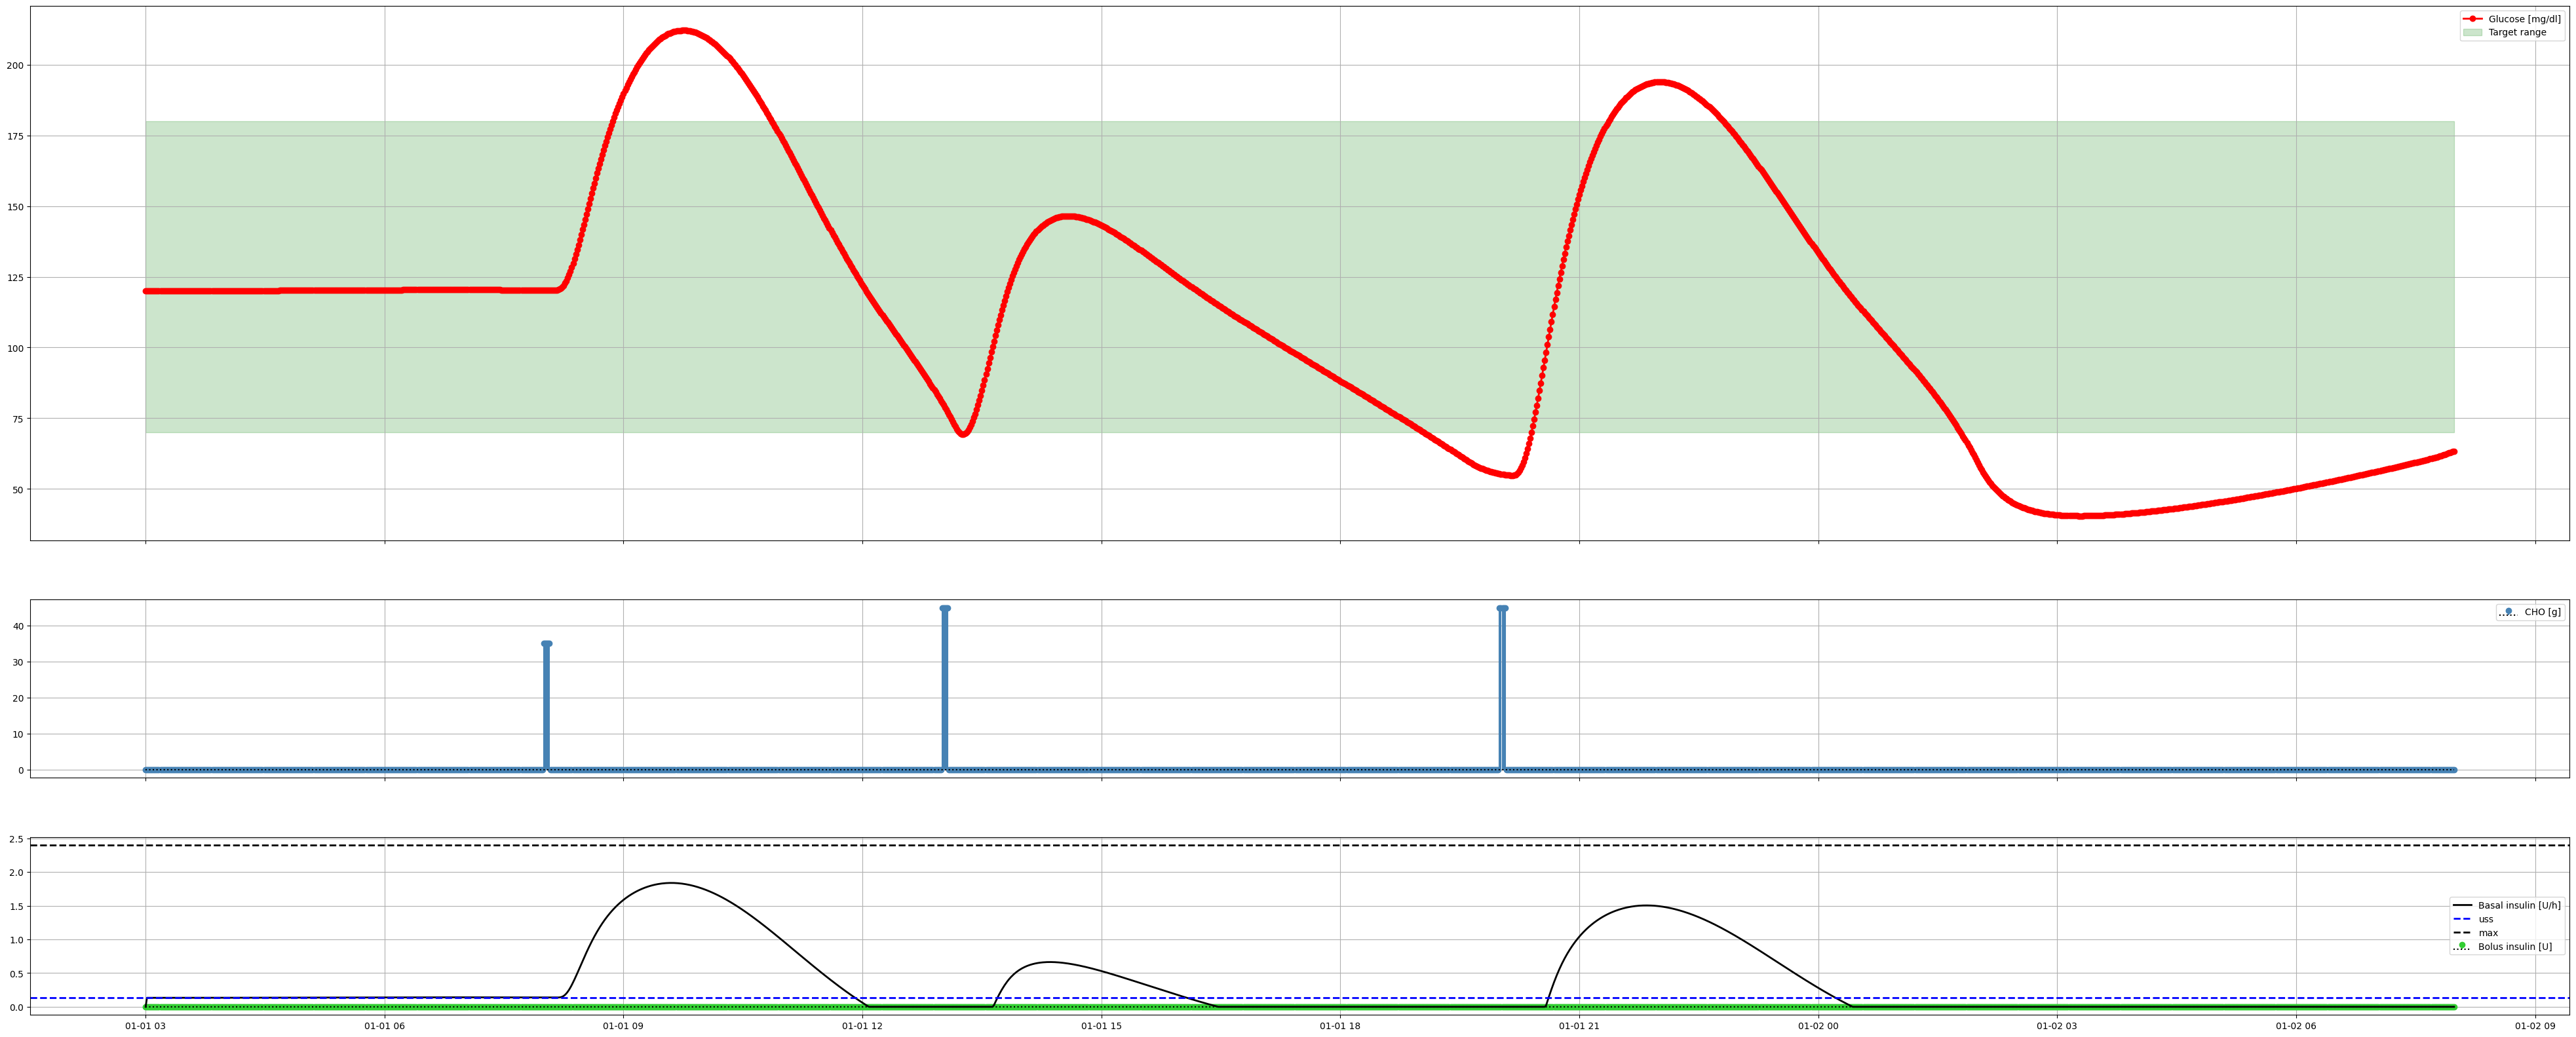

In [6]:
##################################### First Failure mode of InsulinCo's PID control  ###################################
basal_handler_params = dict()
basal_handler_params['default_rate'] = 0.01

# Failure 1
data_given = pd.read_csv('data/default_data.csv') # Use the default data for normalization of MPC tuning

# Instatiating PID Controller
pid_controller_failure01 = PIDController(Ki=0.0, Kd=0.005, Kp=0.0003)

# Running the simulation
glucose, i, insulin_bolus, m, time = simulate(basal_handler=pid_controller_failure01.compute_pid,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)

data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)
title = 'PID Controller - Failure Mode'
name_png = 'task_02_pid_failure_mode.png'
save = False
plot_save_results_presentation(glucose=glucose, insulin_bolus=insulin_bolus, i=i, m=m, time=time, plot=False, title=title, save=save, save_name=name_png, save_path='img')

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'variability': {'mean_glucose': 104.12160486662111, 'median_glucose': 96.62291215137404, 'std_glucose': 58.175178139609976, 'cv_glucose': 55.87234101331024, 'range_glucose': 241.13291729217752, 'iqr_glucose': 70.43950845257001, 'auc_glucose': 181171.59246792074, 'gmi': 5.800588788409577, 'cogi': 35.1241679811643, 'conga': 92.65639830402718, 'j_index': 26.34024577417166, 'mage_plus_index': 86.53879918781982, 'mage_minus_index': 159.0074505471353, 'mage_index': 122.77312486747756, 'ef_index': 2.0, 'modd': 51.562339497688576, 'sddm_index': 21.377842462149648, 'sdw_index': 43.262718363718946, 'std_glucose_roc': 0.14069709053216256, 'cvga': 4933.524640118247}, 'time_in_ranges': {'time_in_target': 53.62068965517241, 'time_in_tight_target': 42.47126436781609, 'time_in_hypoglycemia': 37.35632183908046, 'time_in_l1_hypoglycemia': 11.781609195402298, 'time_in_l2_hypoglycemia': 25.57471264367816, 'time_in_hyperglycemia': 9.022988505747126, 'time_in_l1_hyperglycemia': 4.482758620689655, 'time_in_

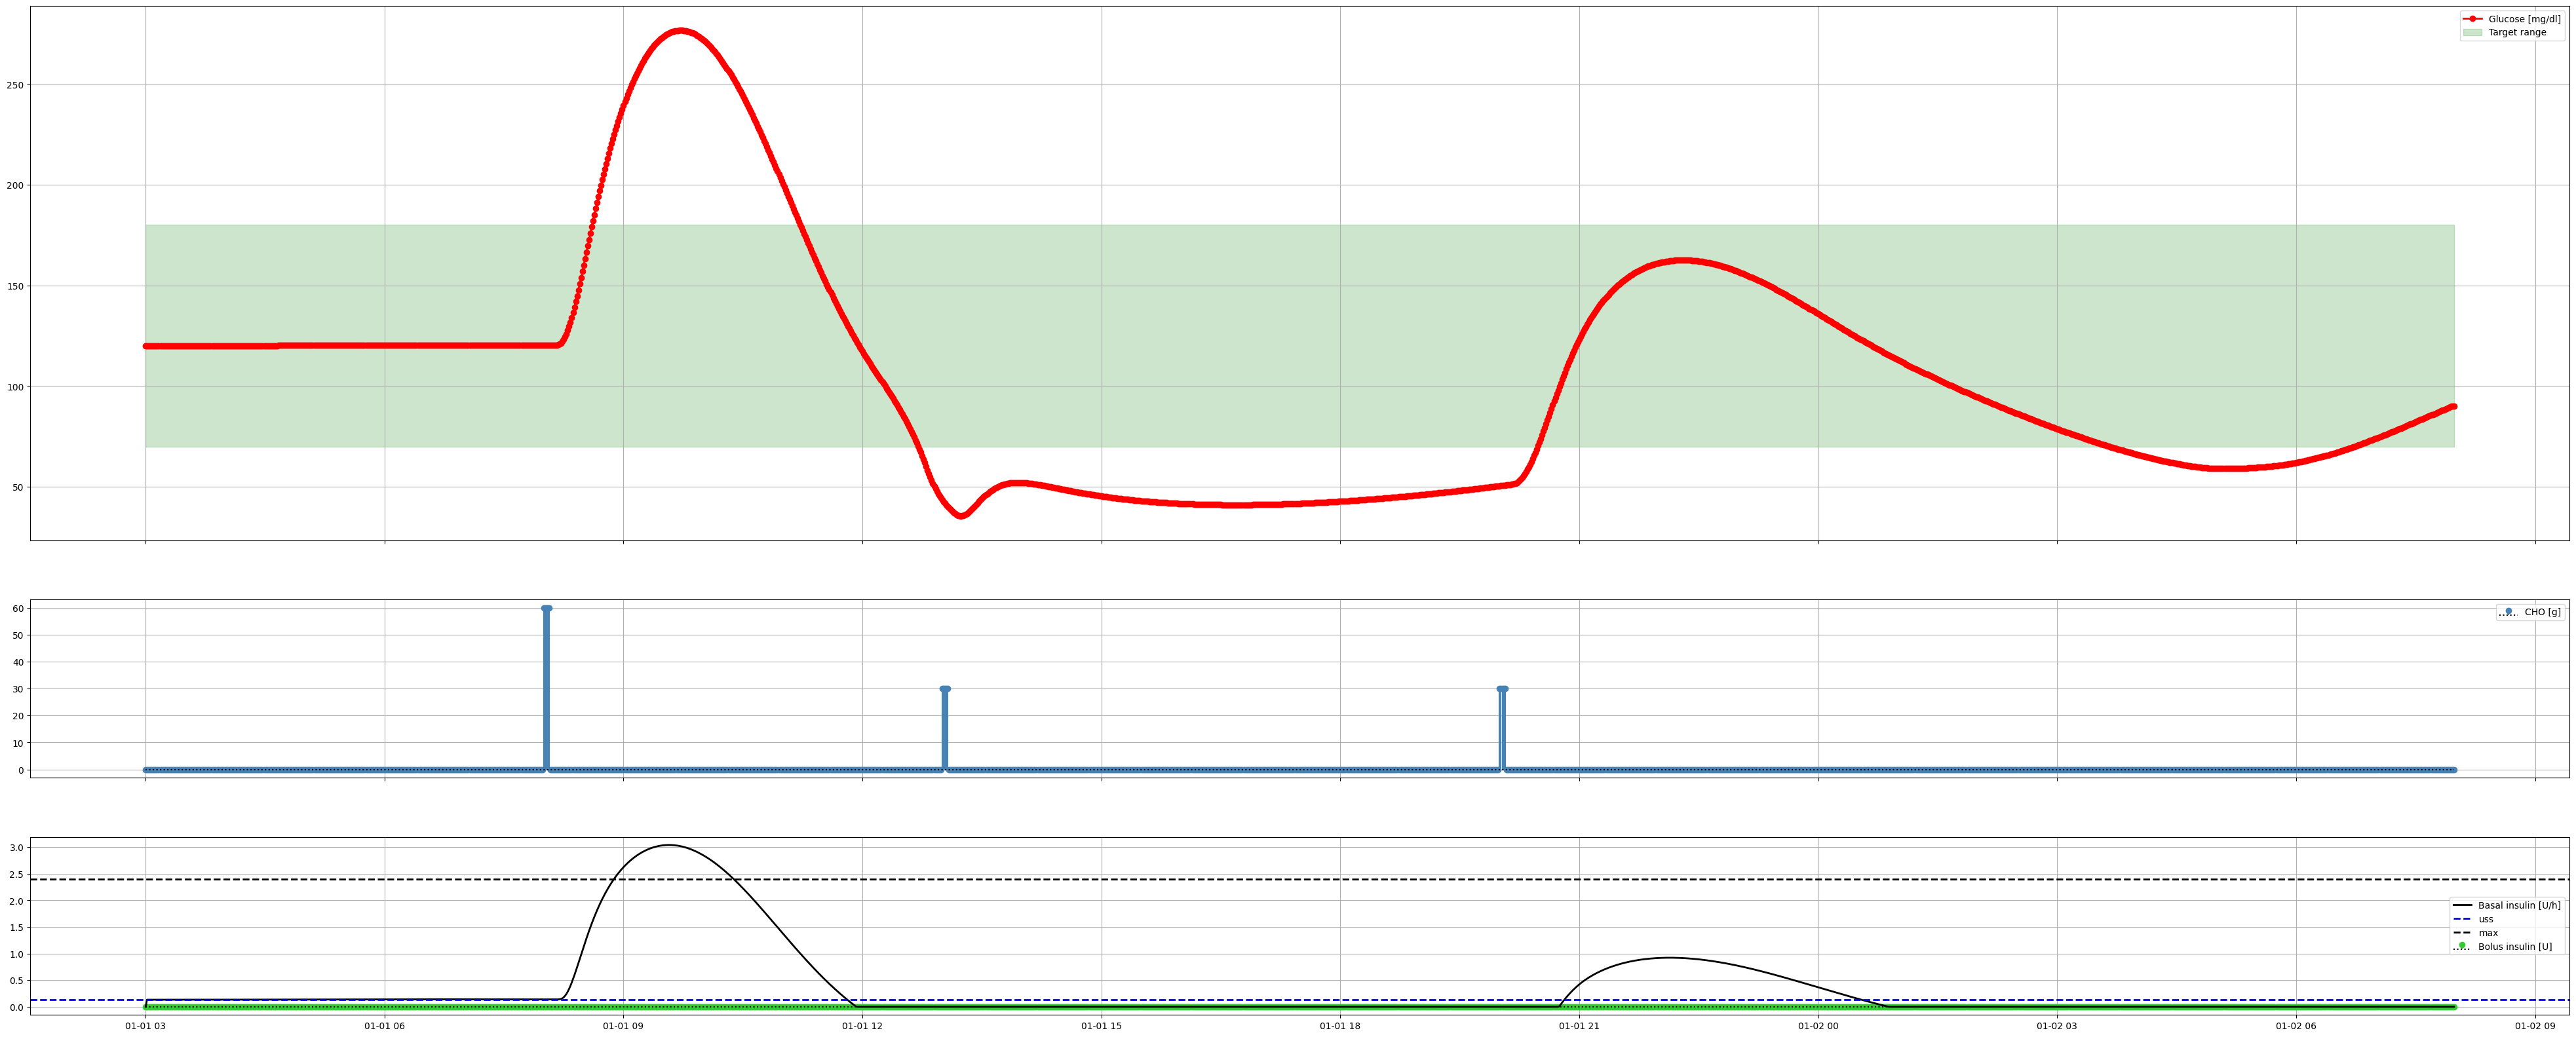

In [7]:
##################################### Second Failure mode of InsulinCo's PID control  ###################################
basal_handler_params = dict()
basal_handler_params['default_rate'] = 0.01

# Failure 2
data_given = pd.read_csv('data/large_B_data.csv') # Use the large breakfast data for the presentation plot

# Instatiating PID Controller
pid_controller_failure02 = PIDController(Ki=0.0, Kd=0.005, Kp=0.0003)

# Running the simulation
glucose, i, insulin_bolus, m, time = simulate(basal_handler=pid_controller_failure02.compute_pid,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)

data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)
title = 'PID Controller - Failure Mode'
name_png = 'task_02_pid_failure_mode.png'
save = False
plot_save_results_presentation(glucose=glucose, insulin_bolus=insulin_bolus, i=i, m=m, time=time, plot=False, title=title, save=save, save_name=name_png, save_path='img')

It is clear from the above graphs that the soft and, more dangerously, the hard limits are being violated. This behaviour is expected as the PID is an unconstrained controller. As our task is both to ensure the safety of the patient and to respect the physical limitations of the insulin pumps, we are led to implement a controller that includes constraints. In addition to this, the delay of the system is not taken into account.

# MPC


<h2 id="mpc_task">Task 3: Model-Based Controller - Tracking MPC</h2>

Propose and implement a Model-Based controller, assuming that you access to the (linearized) system model described above and a full state measurement.

### Controller Choice
The points that motivate the choice of a tracking MPC are the following:
- (tracking): InsulinCo provides us with steady-state reference values for the input and states,
- (Model): InsulinCo provides us with a linearized model,
- (Predictive): Our system has delays and we want to anticipate the rise in glucose due to future meals, and
- InsulinCo provides us with input and output constraints.

### Description of Tracking MPC
We have the following Linear Time Invariant (LTI) dynamics
$$\textbf{x}_{k+1} = A \textbf{x}_{k} + B\textbf{u}_{k} + h,$$

which can be expressed with respect to an initial condition $\textbf{x}_0$ as
$$\textbf{x}_k = A^k \textbf{x}_0 + \sum_{t=0}^{k-1} A^{k-t-1} B \textbf{u}_t + A^{k-t-1} h.$$

Therefore, in order to account for the delay $\tau$, we first let the system evolve until $\textbf{x}_\tau$:

$$\textbf{x}_\tau = A^\tau \textbf{x}_0 + \sum_{t=0}^{\tau-1} A^{\tau-t-1} B \textbf{u}_t + A^{\tau-t-1} h,$$

where
- $A$, $B$, and $h$ are obtained by calling once ```get_linearization()``` around $\textbf{x}_{ss}$ with a $1$ minute discretization step,
- $u_{1,t}$ is the insulin injection input defined in the past at $t - \tau$ and stored in ```inputs_```, and
- $u_{2,t}$ is the future meal at time $t$ obtained by calling ```get_discretized_meals()``` with a $1$ minute discretization step.

Therefore, $\textbf{x}_\tau$ is used as the initial condition to solve the following optimal control problem (OCP):
$$
\begin{array}{rll}
\min_{\textbf{x}, \textbf{u}} & \sum_{k=0}^{K-1} \|\textbf{x}_k - \textbf{x}_{ss} \|^2_Q + \|u_{1,k} - u_{ss} \|_r^2 + \|\textbf{x}_K - \textbf{x}_{ss} \|^2_S & \\
\text{s.t.} & \textbf{x}_{k+1} = A \textbf{x}_{k} + B \textbf{u}_{k} + h & k=0, \ldots, K-1 \\
& \textbf{x}_0 = \textbf{x}_\tau & \\
& u_{2,k} = m_k & k=0, \ldots, K - 1 \\
& u_{1,k} \geq 0 & k=0, \ldots, K - 1 \\
& u_{1,k} \leq 0.04 & k=0, \ldots, K - 1 \\
& x_{9,k} \geq 70 & k=0, \ldots, K - 1
\end{array}
$$

where
- the objective function is to minimize the deviations from the steady-state input $u_{ss}$ and states $\textbf{x}_{ss}$,

- $K = \frac{T_\mathrm{p}}{T_\mathrm{s}} \in \mathbb{N}$ is the prediction step obtained as the division of the prediction horizon $T_\mathrm{p}$ by the sampling time $T_\mathrm{s}$,
- $\textbf{x}_k$ represents the nine-dimensional state at time $k$,
- $\textbf{u}_k = \begin{bmatrix}i_k & m_k \end{bmatrix}^T$ represents the two-dimensional input at time $k$,
- $Q \in \mathbb{R}^{9\times9}_{\geq 0}$ is a diagonal matrix that penalizes the states at all future times until $K - 1$,
- $S \in \mathbb{R}^{9\times9}_{\geq 0}$ is a diagonal matrix that penalizes the states at time $K$ in the future,
- $r \in \mathbb{R}_{\geq 0}$ penalizes the controllable input $i_k$,
- $A \in \mathbb{R}^{9\times9}$ is the dynamics matrix,
- $B \in \mathbb{R}^{9\times2}$ is the input matrix,
- $h \in \mathbb{R}^{9\times1}$ is the offset constant produced by the linearization,
- $\textbf{x}_\tau$ is the initial condition,
- $u_{2,k} = m_k$ constrains the uncontrollable input to be equal to the future meal values obtained with ```get_discretized_meals()```,
- $0 \leq u_{1,k} \leq 0.04$ are the input constraints for the insulin injection, and
- $x_{9,k} \geq 70$ is the hard constraint for hypoglycaemia.

#### Computational Efficiency
In order to minimize the computational effort of running the simulation using MPC, we ensure that the OCP conforms to both [Disciplined Parametrized Programming (DPP)](https://www.cvxpy.org/tutorial/dpp/index.html) and [Disciplined Convex Programming (DCP)](https://www.cvxpy.org/tutorial/dcp/). This is achieved by considering the following points:
- The OCP is parametrized and constructed only once in ```_init_optimization_problem()```,
- the cost function is quadratic and therefore convex, and
- the constraints are linear or follow the rules for DPP.

In addition, the linearization is chosen to be around $\textbf{x}_{ss}$ and performed only once, instead of being continuosly updated around the current states.

Lastly, the usage of $\textbf{x}_\tau$ as initial condition is motivated by its computational efficiency and the ease with which it facilitates the solver's task. In fact, an alternative approach is to consider the current state as the initial state and to constrain the first $\tau$ inputs $u_{1}$ to be equal to the values of ```inputs_``` from the current time until the current time plus $\tau$.

#### Class Structure - `TrackingMPController`
- `__init__()`: Constructs the controller by saving the relevant parameters and by calling `_init_optimization_problem()`
- `_init_optimization_problem()`: Constructs the OCP.
- `_update_matrices_param()`: If called, the state matrices $A$, $B$, and $h$ are updated as attributes of the class. Currently, it is called only once at the first time step of the simulation. Linearization at every time step is possible.
- `compute_mpc()`: Function to call the controller: The OCP is solved with frequency equal to the sampling time. During the rest of the time and in case the solver fails, the open-loop control outputs are used.

In [8]:
class TrackingMPController:
    """
    A tracking MPC controller for the artificial pancreas of InsulinCo.
    """
    def __init__(self, Q:np.ndarray, S:np.ndarray, r:float, pred_time:int, sampling_time:int, print_output:bool=False, verbose:bool=False) -> None:
        """
        Initialize the tracking MPC controller.

        Parameters
        -------
        :param Q: The state cost matrix.
        :param S: The terminal state cost matrix.
        :param r: The input cost.
        :param pred_time: The prediction horizon in minutes.
        :param sampling_time: The sampling time in minutes.
        :param print_output: Print the output of the controller.
        :param verbose: Print the solver output.

        Returns
        -------
        :return: None
        """
        self.Q = Q
        self.S = S
        self.r = r
        self.K = pred_time # no discretization
        self.sampling_time = sampling_time

        self.n = 9 # number of states
        self.m = 2 # number of inputs

        self.print_output = print_output
        self.verbose = verbose
        self.num_infeas = 0
        self.num_None_output = 0

        self._init_optimization_problem()

    def _init_optimization_problem(self) -> None:
        """
        Initialize the parametrized optimization problem and its components.

        Returns
        -------
        :return: None
        """
        # Define variables and dynamic parameters for the optimization problem
        self.x_var      = cp.Variable((self.n, self.K+1))
        self.i_var      = cp.Variable(self.K)
        self.m_var      = cp.Variable(self.K)
        self.meal_param = cp.Parameter(self.K)
        self.x0_param   = cp.Parameter(self.n)

        # Placeholders for parametrization
        self.A   = cp.Parameter((self.n, self.n))
        self.B   = cp.Parameter((self.n, self.m))
        self.h   = cp.Parameter(self.n)
        self.xss = cp.Parameter(self.n)
        self.uss = cp.Parameter()

        # Initialize cost and constraints (parametrized)
        self.cost = 0
        self.constraints = [self.x_var[:, 0] == self.x0_param]
        
        # Iterate over the horizon K - 1 for cost and constraints
        for k in range(self.K):
            self.cost += (
                cp.quad_form(self.x_var[:, k] - self.xss, self.Q) + 
                cp.square(self.i_var[k] - self.uss) * self.r
                )
            self.constraints += [
                self.x_var[:, k+1] == self.A @ self.x_var[:, k] + self.B[:, 0] * self.i_var[k] + self.B[:, 1] * self.m_var[k] + self.h,
                self.m_var[k]      == self.meal_param[k], # to make it DPP compliant
                self.i_var[k]      >= 0,
                self.i_var[k]      <= 0.04,
                self.x_var[8, k]   >= 70,
                ]
        
        # Terminal cost or constraint for stability
        self.cost += cp.quad_form(self.x_var[:, self.K] - self.xss, self.S)
        # self.constraints += [self.x_var[:, self.K] == self.xss]

        self.problem = cp.Problem(cp.Minimize(self.cost), self.constraints)

        if self.print_output:
            print("Is the problem DPP compliant?", self.problem.is_dpp())
            print("Is the problem DCP compliant?", self.problem.is_dcp())

    def _update_matrices_param(self, A:np.ndarray, B:np.ndarray, h:np.ndarray) -> None:
        """
        Update the parametrized state-space matrices for the optimization problem.

        Parameters
        -------
        :param A: The state matrix.
        :param B: The input matrix.
        :param h: The constant term.

        Returns
        -------
        :return: None
        """
        self.A.value = A
        self.B.value = B
        self.h.value = h

    def compute_mpc(self, model, x0, tau, time_index, inputs_, xss, uss, dss) -> tuple:
        """
        Implements the tracking MPC controller.

        Parameters
        -------
        model: the T1DModel class describing the dynamics, provided by ReplayBG
        x0: the current state
        tau: delay of the system in min
        time_index: shows the current time step
        inputs_: a time series with the basal input that was/will be applied to the system
                (useful for implementing delay)
        xss, uss: the linearization point
        dss: Contains basal_handler_params and servers two functions:
            1) a dict that for the controller hyperparameters.
            2) memory for the next iteration (hence dss also being an output)
        
        Returns
        -------
        i: The basal insulin rate to administer at time[time_index+1].
        dss: [see above]
        """
        if self.print_output:
            print(f"--  Simulation time: {time_index} min  -  Infeasible solutions: {self.num_infeas} of which None output: {self.num_None_output}  --")
        
        # Update model parameters at the beginning of the simulation
        if time_index == 0:
            self._update_matrices_param(*model.get_linearization(1, xss))
            self.xss.value = xss
            self.uss.value = uss

            # Initialize the open-loop input
            dss.basal_handler_params['open-loop input'] = uss * np.ones(self.K)
        
        # Optimization at every sampling time
        if (time_index % self.sampling_time) == 0:
            # Linearization around the current state
            # self._update_matrices_param(*model.get_linearization(1, x0))

            # Extract the future meals for initialization and OCP
            meal = model.get_discretized_meals(initial_time_step=time_index, duration=self.K+tau, T=1)
            
            # Evolve the system to include the delay
            u_tau = np.vstack([
                inputs_[time_index:time_index+tau],
                meal[:tau]
                ])
            
            for k in range(tau):
                x0 = self.A.value @ x0 + self.B.value @ u_tau[:, k] + self.h.value
            
            # Update parameters for the optimization problem
            self.meal_param.value = meal[tau:]
            self.x0_param.value = x0

            # Solve the optimization problem
            try:
                self.problem.solve(solver=cp.MOSEK, verbose=self.verbose)

                # Check if the solution is available
                if self.i_var.value is None:
                    self.num_None_output += 1
                    raise Exception("Solver did not find a feasible solution.")
            
            except:
                self.num_infeas += 1
                
                control_output = dss.basal_handler_params['open-loop input'][time_index % self.sampling_time]

                if self.print_output:
                    print(f"Forced control output: {control_output}")
                return control_output, dss
            
            # Problem solved
            control_output = self.i_var[0].value

            # Save open-loop input
            dss.basal_handler_params['open-loop input'] = self.i_var[:].value

            if self.print_output:
                print(f"Optimized control output: {control_output}")
            return control_output, dss
        
        # Open-loop control
        else:
            control_output = dss.basal_handler_params['open-loop input'][time_index % self.sampling_time]
            
            if self.print_output:
                print(f"Open-loop control output: {control_output}")
            return control_output, dss

<h3 id="mpc_tuning">Design/Tuning Parameters</h3>

#### Cost Penalizers - $Q$, $S$, and $r$
These parameters penalize the squared deviation from the steady state, contributing to the cost in the objective function. The magnitude of these deviations varies significantly between the states and the input. Therefore, to ensure that the effect on the cost function can be easily tuned, we first normalize them. This concept is similar to using the inverse covariance matrix. However, here we simplify the normalization by dividing each state by
$$\Delta x_i^2 = (\hat{x}_i - x_{i,ss})^2 \qquad \forall i \in [1,9]$$

where $\hat{\textbf{x}}$ refers to the vector of maximum values obtained when running the PID controller with *default meal values*. Similarly, we know that the maximum value of the input is $0.04$, so
$$\Delta u^2 = (0.04 - u_{ss})^2.$$

We also multiply all the entries by $\Delta x_9^2$ to ensure that the normalization of $x_9$ is $1$. Therefore, the normalization becomes:
- $Q_\mathrm{normalization} = \Delta x_9^2 / \Delta \textbf{x}^2 = \Delta x_9^2 / \begin{bmatrix} \Delta x_1^2 & \ldots & \Delta x_9^2 \end{bmatrix}$, and
- $r_\mathrm{normalization} = \Delta x_9^2 / \Delta u^2$.

The tuning results in the following values:
- $Q = S = \text{diag} \left( \begin{bmatrix} 1 & 0 & 1 & 1 & 1 & 1 & 1 & 0 & 10 \end{bmatrix} \right) \cdot Q_\mathrm{normalization}$.
  - The weights of the second and eighth states are set to zero because their normalization is too large and affects the cost function too much, leading to solver problems.
- $r = 0.5 \cdot r_\mathrm{normalization}$.

#### Time Parameters
The following parameters are associated with time:

- **Prediction Horizon $T_\mathrm{p}$**: This parameter determines how far into the future the controller predicts.
  - Increasing $T_\mathrm{p}$: Leads to better predictions but introduces more variables into the OCP, resulting in slower simulations.
  - $T_\mathrm{p} = 140$ min provides a good compromise between accuracy, prediction, and speed.

- **Sampling Time $T_\mathrm{s}$**: This parameter determines how often the optimization is performed. Between two successive OCP solutions, the previously calculated control outputs are used.
  - Increasing $T_\mathrm{s}$: Results in fewer optimizations and more open-loop values being used. The simulation becomes faster but less accurate.
  - $T_\mathrm{s} = 1$ min results in a relatively slow simulation but yields good results.

- **Discretization Time $T_\mathrm{d}$**: Instead of solving the OCP for each time step $k \in K$ of 1 minute, $T_\mathrm{p}$ is divided by $T_\mathrm{s} \cdot T_\mathrm{d}$, which groups the variables in batches. This parameter is not implemented in the current MPC but in the discretized version described in the [Possible Improvements](#mpc_possible_improvements) section.
  - Increasing $T_\mathrm{d}$: Results in fewer variables per optimization, leading to faster simulations but less accurate results.

<h4 id="mpc_tuning_iteration">Tuning Iteration</h4>
The strategy used to tune the tracking MPC is the following:

1. Perform a normalization of the cost-penalizer parameters.
2. Set all cost-penalizer parameters to $1$ times the normalization.
3. Choose $T_\mathrm{p}$ and $T_\mathrm{s}$ (and $T_\mathrm{d}$) so that the simulation is fast and the future prediction is good (in this case $T_\mathrm{p}$ ranges from $2$ to $5$ hours).
4. Remove weights for states with high normalization that can cause solver problems.
5. Tune $Q$ and $r$ until $100\%$ Time-in-Target is reached.

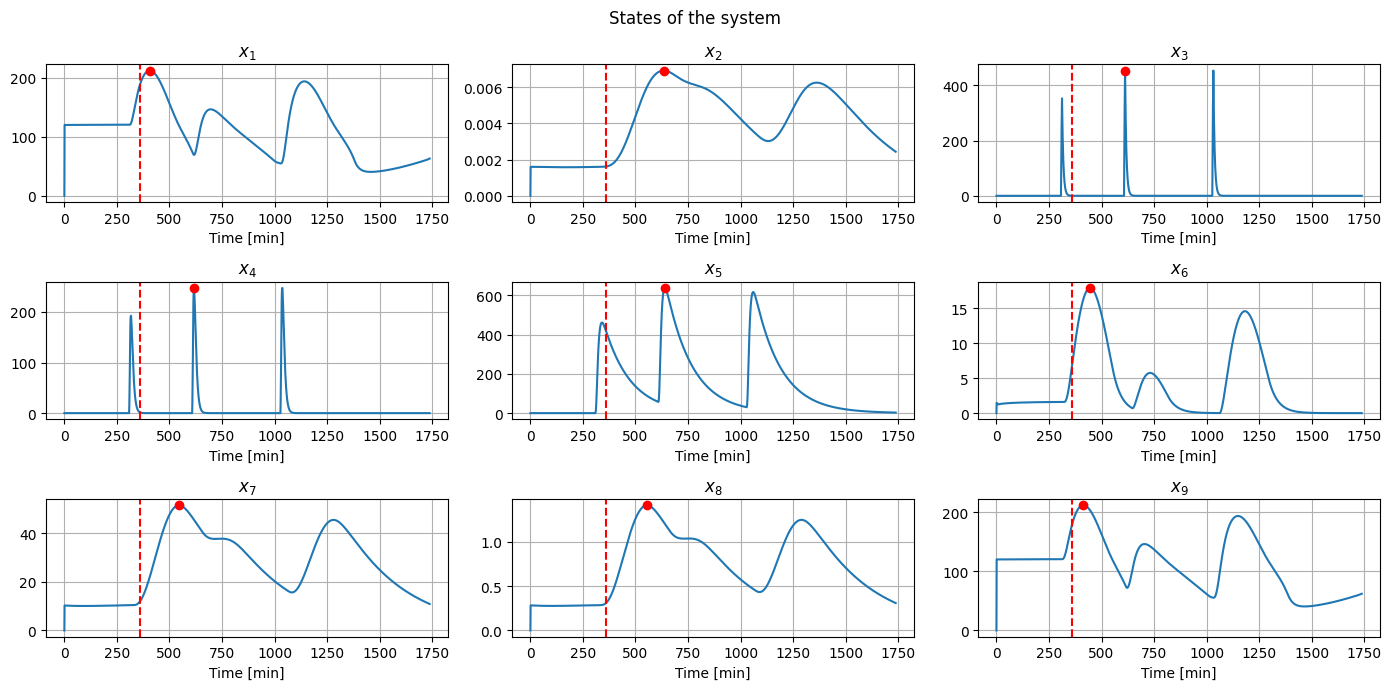

x1            x2             x3            x4             x5  \
x_ss     120.000000  1.601439e-03       0.000000      0.000000       0.000000   
x_max    212.084480  6.921821e-03     453.944180    247.563177     637.549238   
Dx        92.084480  5.320382e-03     453.944180    247.563177     637.549238   
Dx^2    8479.551448  2.830646e-05  206065.318973  61287.526683  406469.031182   
Q_norm     0.988113  2.960016e+08       0.040661      0.136712       0.020614   

                x6           x7           x8           x9  
x_ss      1.508147    10.273468     0.282689   120.000000  
x_max    17.869840    51.495805     1.413440   211.535555  
Dx       16.361693    41.222337     1.130751    91.535555  
Dx^2    267.704985  1699.281091     1.278597  8378.757877  
Q_norm   31.298475     4.930766  6553.084903     1.000000

i
u_ss    2.225892e-03
Di^2    1.426883e-03
r_norm  5.872070e+06

In [9]:
##################################### Weights Estimation - Normalization ###################################
states = pid_controller_failure01.x
time_simulation = np.arange(0, states.shape[0], 1)

# Find the time when x[8] reaches 180 mg/dl
time_180 = np.where(states[:, 8] >= 180)[0][0]

# Plot the states in 9 subplots
fig, axs = plt.subplots(3, 3, figsize=(14, 7))
fig.suptitle('States of the system')

for i in range(9):
    axs[i//3, i%3].plot(time_simulation, states[:, i])
    axs[i//3, i%3].set_title(r'$x_{}$'.format(i+1))
    axs[i//3, i%3].set_xlabel('Time [min]')
    axs[i//3, i%3].grid()
    axs[i//3, i%3].axvline(x=time_180, color='r', linestyle='--', label=r'$x_9 = 180$ mg/dl')

    # Find the index and value of the maximum point for each state
    max_index = np.argmax(states[:, i])
    max_value = states[max_index, i]
    axs[i//3, i%3].plot(time_simulation[max_index], max_value, 'ro')

plt.tight_layout()
plt.show()
plt.close()

# For Q (and S)
xss = pid_controller_failure01.xss

column_names = [f'x{i}' for i in range(1, len(xss) + 1)]
df_x = pd.DataFrame((xss).reshape(-1,9), columns=column_names, index=['x_ss'])

x_max = np.max(pid_controller_failure01.x, axis=0)

df_x = pd.concat([df_x, pd.DataFrame((x_max).reshape(-1,9), columns=column_names, index=['x_max'])])
df_x = pd.concat([df_x, pd.DataFrame((x_max - xss).reshape(-1,9), columns=column_names, index=['Dx'])])
delta_x_square = (x_max - xss)**2
df_x = pd.concat([df_x, pd.DataFrame(delta_x_square.reshape(-1,9), columns=column_names, index=['Dx^2'])])
normalization_Q = delta_x_square[8] / delta_x_square
df_x = pd.concat([df_x, pd.DataFrame(normalization_Q.reshape(-1,9), columns=column_names, index=['Q_norm'])])
display(df_x)

# For r
uss = pid_controller_failure01.uss

df_i = pd.DataFrame(uss, columns=['i'], index=['u_ss'])

delta_i_square = (0.04 - uss)**2
df_i = pd.concat([df_i, pd.DataFrame(delta_i_square, columns=['i'], index=['Di^2'])])
normalization_r = delta_x_square[8] / delta_i_square
df_i = pd.concat([df_i, pd.DataFrame(normalization_r, columns=['i'], index=['r_norm'])])
display(df_i)

Is the problem DPP compliant? True
Is the problem DCP compliant? True
------ START ------
--  Simulation time: 0 min  -  Infeasible solutions: 0 of which None output: 0  --
Optimized control output: 0.0029348222092264037
--  Simulation time: 1 min  -  Infeasible solutions: 0 of which None output: 0  --
Forced control output: 0.0029348222092264037
--  Simulation time: 2 min  -  Infeasible solutions: 1 of which None output: 0  --
Optimized control output: 0.002864665006986622
--  Simulation time: 3 min  -  Infeasible solutions: 1 of which None output: 0  --
Optimized control output: 0.0028336606341021475
--  Simulation time: 4 min  -  Infeasible solutions: 1 of which None output: 0  --
Optimized control output: 0.0028060314346937815
--  Simulation time: 5 min  -  Infeasible solutions: 1 of which None output: 0  --
Forced control output: 0.0028060314346937815
--  Simulation time: 6 min  -  Infeasible solutions: 2 of which None output: 0  --
Forced control output: 0.0028060314346937815
-- 

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'variability': {'mean_glucose': 118.48731299522976, 'median_glucose': 117.35211415943573, 'std_glucose': 25.437738956540198, 'cv_glucose': 21.468744892176186, 'range_glucose': 91.24321571782578, 'iqr_glucose': 32.579535947309594, 'auc_glucose': 206167.92461169977, 'gmi': 6.144216526845896, 'cogi': 98.76461222834828, 'conga': 42.09656705103657, 'j_index': 20.71442057931968, 'mage_plus_index': 54.1675819296653, 'mage_minus_index': 50.70229904832787, 'mage_index': 52.43494048899659, 'ef_index': 2.0, 'modd': 19.02342663648823, 'sddm_index': 19.800132403860484, 'sdw_index': 17.81670032362466, 'std_glucose_roc': 0.10010268099209199, 'cvga': 1115.4287168271585}, 'time_in_ranges': {'time_in_target': 100.0, 'time_in_tight_target': 79.42528735632185, 'time_in_hypoglycemia': 0.0, 'time_in_l1_hypoglycemia': 0.0, 'time_in_l2_hypoglycemia': 0.0, 'time_in_hyperglycemia': 0.0, 'time_in_l1_hyperglycemia': 0.0, 'time_in_l2_hyperglycemia': 0.0}, 'risk': {'adrr': 6.339381688787888, 'lbgi': 0.515903632849

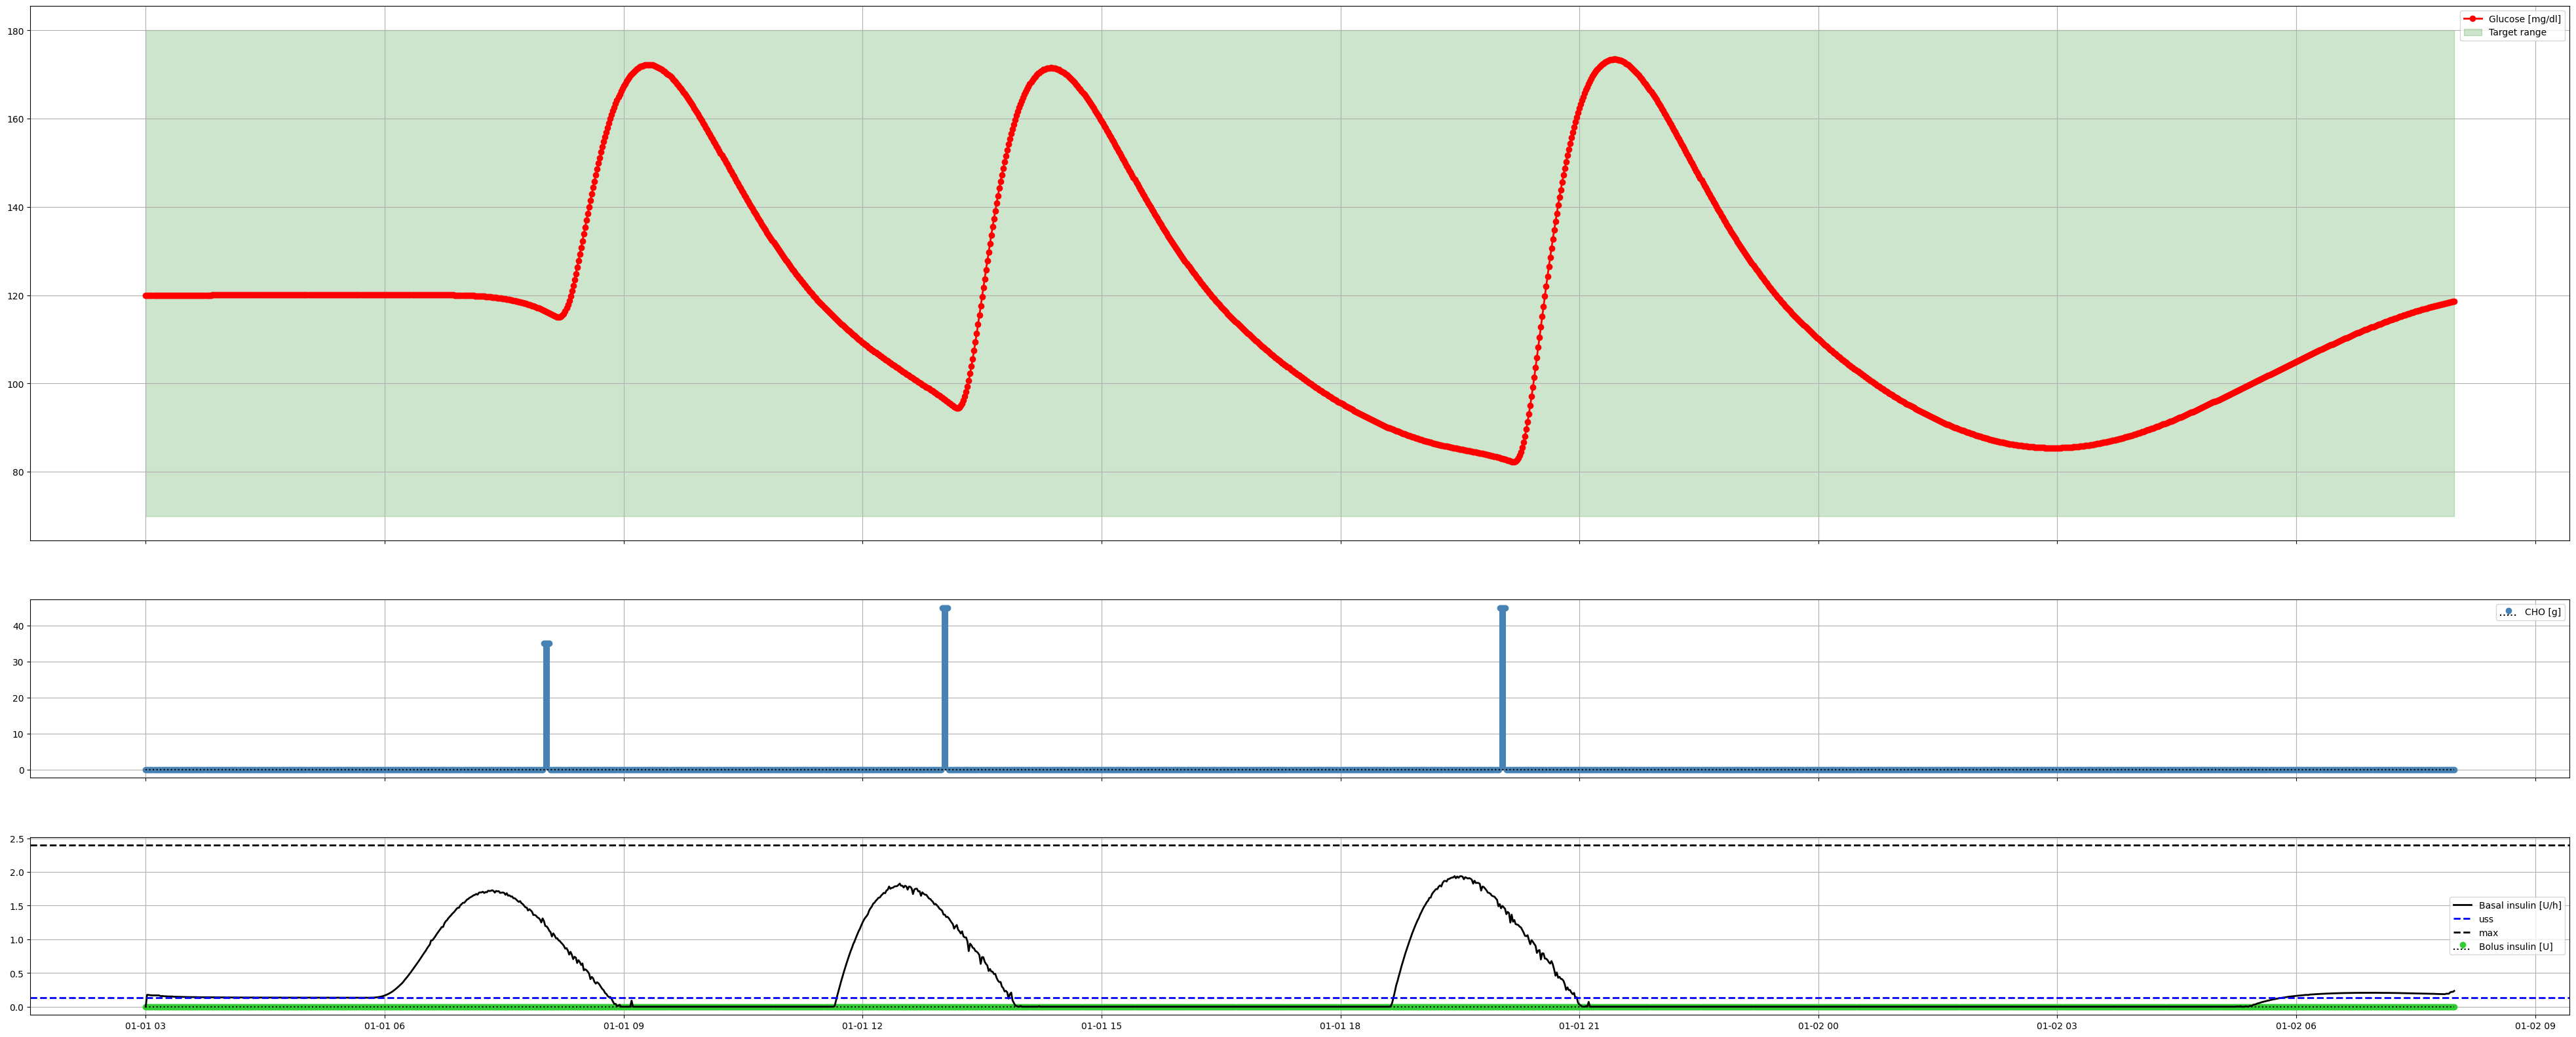

In [10]:
##################################### Tracking MPC - Run Simulation ###################################
# Initialize the dict to save inputs
basal_handler_params = dict()
basal_handler_params['open-loop input'] = None

# Get the data
# data_given = pd.read_csv('data/zero_test.csv')
# data_given = pd.read_csv('data/data_cho.csv')
data_given = pd.read_csv('data/default_data.csv')

# Instatiating tracking MPC
Q = np.diag([1, 0, 1, 1, 1, 1, 1, 0, 10]) * normalization_Q
r = 0.5 * normalization_r
S = Q
sampling_time = 1
pred_time = 140
print_output = True

# Initialize the controller
tracking_mpc = TrackingMPController(Q, S, r, pred_time, sampling_time, print_output=print_output)

# Running the simulation
print("------ START ------")
glucose, i, insulin_bolus, m, time = simulate(basal_handler=tracking_mpc.compute_mpc,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)
print("------ FINISH ------")

data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)
title = 'Tracking MPC Controller'
name_png = 'task_03_mpc.png'
save = False
plot_save_results_presentation(glucose=glucose, insulin_bolus=insulin_bolus, i=i, m=m, time=time, plot=False, title=title, save=save, save_name=name_png, save_path='img')

<h3 id="mpc_possible_improvements">Possible Improvements</h3>

1. Introduce a slack variable to penalize the soft constraint of hyperglycaemia. With the current controller, we reach $100\%$ Time-in-Target, so it was not included.
2. Include the discretization time to speed up the results and allow $T_\mathrm{p}$ to be larger than $140$ minutes.
3. Investigate the impact of different solvers on speed and infeasible solutions (currently *MOSEK* and *CLARABEL* are the best).
4. Add the terminal constraint $\textbf{x}_K = \textbf{x}_{ss}$ to ensure stability, although this adds some complexity to the solver and requires $T_\mathrm{p}$ to be long enough to ensure that the system can reach the state while satisfying constraints and spiky meals.
5. Implement a multi-horizon as in [Distributed multi-horizon model predictive control for network of energy hubs](https://www.sciencedirect.com/science/article/pii/S0967066124000820) or discount future costs with a discount factor to decrease the effect of linear-nonlinear model mismatches in the cost function when predicting future behaviours.
6. Solve the OCP at the next time step in case the solver fails.

The first three points are included in the following tracking MPC:
1. The slack variable $\xi_k \in \mathbb{R}_{\geq 0}$ is considered by including:
   - The cost $\|\xi_k \|_s^2$ in the objective function, and
   - the constraints
$$ \begin{array}{ll} x_{9,k} \leq 180 + \xi_k & \forall k \\
   \xi_k \geq 0 & \forall k.
   \end{array} $$
2. The choice of discretization is natural, since in reality the actuator pump injects insulin every $5$ to $10$ minutes, as presented by an expert in the field, Simone Del Favero. The changes to include the discretization time $T_\mathrm{d}$ are the following:
   - The matrices $A$, $B$, and $h$ and meal $m_k$ or $u_2$ are now different depending on the discretization step, while still being around $\textbf{x}_{ss}$:
     - For the evolution of the system, the matrices and $u_2$ remain the same as before, while
     - for the OCP, the matrices and $m_k$ are obtained by calling ```get_linearization()``` and ```get_discretized_meals()``` with a discretization step equal to $T_\mathrm{d}$.
   - The decision variables of the OCP are drastically decreased leading to an extremely fast controller. This speed up comes at the cost of precision. In fact, the optimal insulin injection input found by solving the OCP is now an average value over $T_\mathrm{d}$ time steps.
3. The fallback solver *CLARABEL* is used if *MOSEK* fails.

In [11]:
class TrackingMPController_discrete:
    """
    A discretized version of a tracking MPC controller for the artificial pancreas of InsulinCo.
    """
    def __init__(self, Q:np.ndarray, S:np.ndarray, r:float, s:float, pred_time:int, sampling_time:int, discret_time:int, print_output:bool=False, verbose:bool=False) -> None:
        """
        Initialize the tracking MPC controller.

        Parameters
        -------
        :param Q: The state cost matrix.
        :param S: The terminal state cost matrix.
        :param r: The input cost.
        :param s: The slack variable cost.
        :param pred_time: The prediction horizon in minutes.
        :param sampling_time: The sampling time in minutes.
        :param discret_time: The discretization time in minutes.
        :param print_output: Print the output of the controller.
        :param verbose: Print the solver output.

        Returns
        -------
        :return: None
        """
        self.Q = Q
        self.S = S
        self.r = r
        self.s = s
        self.pred_time = pred_time
        self.sampling_time = sampling_time
        self.discret_time = discret_time

        self.K = int(pred_time / discret_time)

        self.n = 9 # number of states
        self.m = 2 # number of inputs

        self.A = None
        self.B = None
        self.h = None

        self.print_output = print_output
        self.verbose = verbose
        self.num_infeas = 0
        self.num_None_output = 0

        self._init_optimization_problem()

    def _init_optimization_problem(self) -> None:
        """
        Initialize the parametrized optimization problem and its components.

        Returns
        -------
        :return: None
        """
        # Define variables and dynamic parameters for the optimization problem
        self.x_var          = cp.Variable((self.n, self.K+1))
        self.i_var          = cp.Variable(self.K)
        self.m_var          = cp.Variable(self.K)
        self.meal_param     = cp.Parameter(self.K)
        self.x0_param       = cp.Parameter(self.n)
        self.slack_x_ub_var = cp.Variable(self.K)

        # Placeholders for parametrization
        self.A_d = cp.Parameter((self.n, self.n))
        self.B_d = cp.Parameter((self.n, self.m))
        self.h_d = cp.Parameter(self.n)
        self.xss = cp.Parameter(self.n)
        self.uss = cp.Parameter()

        # Initialize cost and constraints (parametrized)
        self.cost = 0
        self.constraints = [self.x_var[:, 0] == self.x0_param]
        
        # Iterate over the horizon K - 1 for cost and constraints
        for k in range(self.K):
            self.cost += (
                cp.quad_form(self.x_var[:, k] - self.xss, self.Q) + 
                cp.square(self.i_var[k] - self.uss) * self.r +
                cp.square(self.slack_x_ub_var[k]) * self.s
                )
            self.constraints += [
                self.x_var[:, k+1]     == self.A_d @ self.x_var[:, k] + self.B_d[:, 0] * self.i_var[k] + self.B_d[:, 1] * self.m_var[k] + self.h_d,
                self.m_var[k]          == self.meal_param[k], # make it DPP compliant with meal as variable
                self.i_var[k]          >= 0,
                self.i_var[k]          <= 0.04,
                self.x_var[8, k]       >= 70,
                self.x_var[8, k]       <= 180 + self.slack_x_ub_var[k],
                self.slack_x_ub_var[k] >= 0,
                ]
        
        # Terminal cost or constraint for stability
        self.cost += cp.quad_form(self.x_var[:, self.K] - self.xss, self.S)
        # self.constraints += [self.x_var[:, self.K_d] == self.xss]

        self.problem = cp.Problem(cp.Minimize(self.cost), self.constraints)

        if self.print_output:
            print("Is the problem DPP compliant?", self.problem.is_dpp())
            print("Is the problem DCP compliant?", self.problem.is_dcp())

    def _update_linearized_matrices_tau(self, A:np.ndarray, B:np.ndarray, h:np.ndarray) -> None:
        """
        Update the parametrized state-space matrices for the evolution of the system until tau.

        Parameters
        -------
        :param A: The state matrix.
        :param B: The input matrix.
        :param h: The constant term.

        Returns
        -------
        :return: None
        """
        self.A = A
        self.B = B
        self.h = h

    def _update_linearized_matrices(self, A:np.ndarray, B:np.ndarray, h:np.ndarray) -> None:
        """
        Update the parametrized state-space matrices for the discretized optimization problem.

        Parameters
        -------
        :param A: The state matrix.
        :param B: The input matrix.
        :param h: The constant term.

        Returns
        -------
        :return: None
        """
        self.A_d.value = A
        self.B_d.value = B
        self.h_d.value = h

    def _update_model_params(self, meal:np.ndarray, x0:np.ndarray) -> None:
        """
        Update the parametrized meal and initial state for the optimization problem.

        Parameters
        -------
        :param meal: The meal input.
        :param x0: The initial state.

        Returns
        -------
        :return: None
        """
        self.meal_param.value = meal
        self.x0_param.value = x0

    def compute_mpc(self, model, x0, tau, time_index, inputs_, xss, uss, dss) -> tuple:
        """
        Implements the tracking MPC controller.

        Parameters
        -------
        model: the T1DModel class describing the dynamics, provided by ReplayBG
        x0: the current state
        tau: delay of the system in min
        time_index: shows the current time step
        inputs_: a time series with the basal input that was/will be applied to the system
                (useful for implementing delay)
        xss, uss: the linearization point
        dss: Contains basal_handler_params and servers two functions:
            1) a dict that for the controller hyperparameters.
            2) memory for the next iteration (hence dss also being an output)
        
        Returns
        -------
        i: The basal insulin rate to administer at time[time_index+1].
        dss: [see above]
        """
        if self.print_output:
            print(f"--  Simulation time: {time_index} min  -  Infeasible solutions: {self.num_infeas} of which None output: {self.num_None_output}  --")
        
        # Save uss and xss at the beginning of the simulation
        if time_index == 0:
            self.xss.value = xss
            self.uss.value = uss
            self._update_linearized_matrices_tau(*model.get_linearization(1, xss))
            self._update_linearized_matrices(*model.get_linearization(self.discret_time, xss))

            # Initialize the open-loop input
            dss.basal_handler_params['open-loop input'] = uss * np.ones(self.K)
        
        # Optimization at every sampling time
        if (time_index % self.sampling_time) == 0:
            ## Evolve the system to include the delay
            # Linearization around the current state
            # self._update_linearized_matrices_tau(*model.get_linearization(1, x0))
            
            # Input until tau
            u_tau = np.vstack([
                inputs_[time_index:time_index+tau],
                model.get_discretized_meals(initial_time_step=time_index, duration=tau, T=1)
                ])
            
            # Evolution
            for k in range(tau):
                x0 = self.A @ x0 + self.B @ u_tau[:, k] + self.h
            
            # Update parameters for the optimization problem
            # self._update_linearized_matrices(*model.get_linearization(self.discret_time, x0))
            self._update_model_params(model.get_discretized_meals(initial_time_step=time_index+tau, duration=self.pred_time, T=self.discret_time),
                                      x0)
        
            # Solve the optimization problem
            try:
                self.problem.solve(solver=cp.MOSEK, verbose=self.verbose)

                # Check if the solution is available
                if self.i_var.value is None:
                    raise Exception("Solver did not find a feasible solution.")
            
            # Fallback solver
            except:
                try:
                    self.problem.solve(solver=cp.CLARABEL, verbose=self.verbose)

                    # Check if the solution is available
                    if self.i_var.value is None:
                        self.num_None_output += 1
                        raise Exception("Fallback solver did not find a feasible solution.")

                except:
                    self.num_infeas += 1
                    
                    control_output = dss.basal_handler_params['open-loop input'][time_index % self.sampling_time]

                    if self.print_output:
                        print(f"Forced control output: {control_output}")
                    return control_output, dss
            
            # Problem solved
            control_output = self.i_var[0].value

            # Save open-loop input
            dss.basal_handler_params['open-loop input'] = np.repeat(self.i_var[:].value, self.discret_time)

            if self.print_output:
                print(f"Optimized control output: {control_output}")
            return control_output, dss
        
        # Open-loop control
        else:
            control_output = dss.basal_handler_params['open-loop input'][time_index % self.sampling_time]
            
            if self.print_output:
                print(f"Open-loop control output: {control_output}")
            return control_output, dss

Is the problem DPP compliant? True
Is the problem DCP compliant? True
------ START ------
--  Simulation time: 0 min  -  Infeasible solutions: 0 of which None output: 0  --
Optimized control output: 0.006709529806674287
--  Simulation time: 1 min  -  Infeasible solutions: 0 of which None output: 0  --
Open-loop control output: 0.006709529806674287
--  Simulation time: 2 min  -  Infeasible solutions: 0 of which None output: 0  --
Open-loop control output: 0.006709529806674287
--  Simulation time: 3 min  -  Infeasible solutions: 0 of which None output: 0  --
Open-loop control output: 0.006709529806674287
--  Simulation time: 4 min  -  Infeasible solutions: 0 of which None output: 0  --
Open-loop control output: 0.006709529806674287
--  Simulation time: 5 min  -  Infeasible solutions: 0 of which None output: 0  --
Open-loop control output: 0.006709529806674287
--  Simulation time: 6 min  -  Infeasible solutions: 0 of which None output: 0  --
Open-loop control output: 0.006709529806674287


c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'variability': {'mean_glucose': 119.80745018692981, 'median_glucose': 115.94900257988871, 'std_glucose': 26.982210098075086, 'cv_glucose': 22.52131236911898, 'range_glucose': 94.86457276626295, 'iqr_glucose': 34.726694158233244, 'auc_glucose': 208464.96332525788, 'gmi': 6.175794208471361, 'cogi': 98.50745752612802, 'conga': 44.7357292906256, 'j_index': 21.54720436658715, 'mage_plus_index': 54.10126916875783, 'mage_minus_index': 53.2801760250796, 'mage_index': 53.69072259691872, 'ef_index': 2.0, 'modd': 18.055195308764826, 'sddm_index': 20.96320372768424, 'sdw_index': 18.11882595741914, 'std_glucose_roc': 0.10544980971267766, 'cvga': 1031.6868905574988}, 'time_in_ranges': {'time_in_target': 100.0, 'time_in_tight_target': 77.98850574712644, 'time_in_hypoglycemia': 0.0, 'time_in_l1_hypoglycemia': 0.0, 'time_in_l2_hypoglycemia': 0.0, 'time_in_hyperglycemia': 0.0, 'time_in_l1_hyperglycemia': 0.0, 'time_in_l2_hyperglycemia': 0.0}, 'risk': {'adrr': 6.420026982349696, 'lbgi': 0.46221137298657

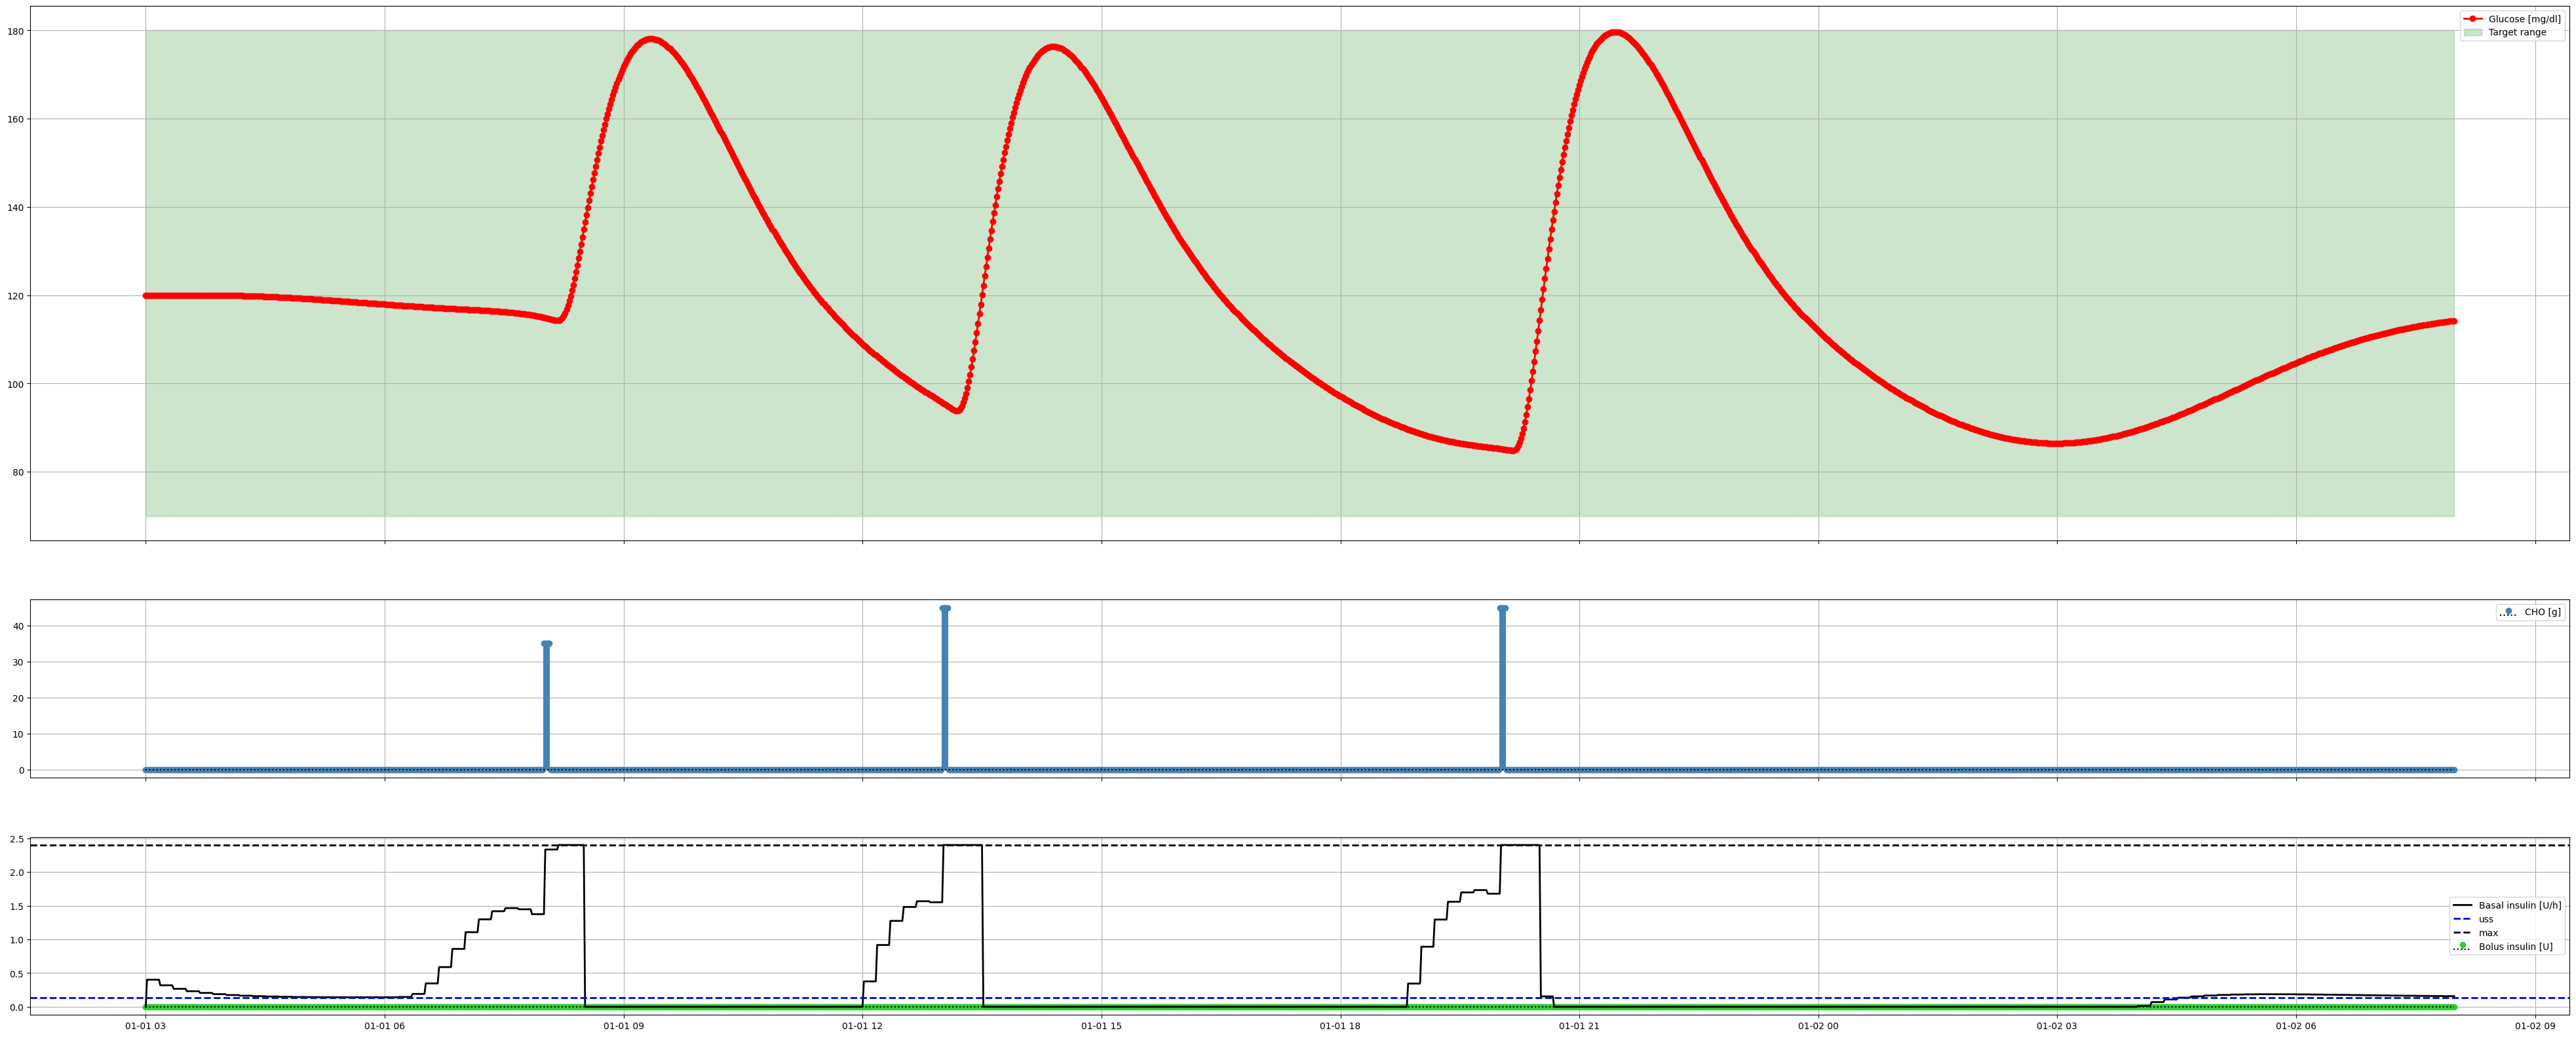

In [12]:
##################################### Tracking MPC - Discretized - Run Simulation ###################################
# Initialize the dict to save inputs
basal_handler_params = dict()
basal_handler_params['open-loop input'] = None

# Get the data
# data_given = pd.read_csv('data/zero_test.csv')
# data_given = pd.read_csv('data/data_cho.csv')
data_given = pd.read_csv('data/default_data.csv')

# Instatiating tracking MPC
Q = np.diag([1, 0, 1, 1, 1, 1, 1, 0, 10]) * normalization_Q
S = 3 * Q
r = 0.5 * normalization_r
s = 10
sampling_time = 10
discret_time = 10
pred_time = 140
assert pred_time % discret_time == 0, "K should be a multiple of the discretization time."
assert pred_time >= sampling_time, "K should be greater than the sampling time."
print_output = True

# Initialize the controller
tracking_mpc_discrete = TrackingMPController_discrete(Q, S, r, s, pred_time, sampling_time, discret_time, print_output=print_output)

# Running the simulation
print("------ START ------")
glucose, i, insulin_bolus, m, time = simulate(basal_handler=tracking_mpc_discrete.compute_mpc,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)
print("------ FINISH ------")

data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)
title = 'Discretized Tracking MPC Controller'
name_png = 'task_03_mpc_discrete.png'
save = False
plot_save_results_presentation(glucose=glucose, insulin_bolus=insulin_bolus, i=i, m=m, time=time, plot=False, title=title, save=save, save_name=name_png, save_path='img')

# DeePC


## Task 4: Data-Driven Controller - Regularized Tracking DeePC

Propose and implement a DeePC controller, assuming that you measure the glucose $G(t)$ and the *non-monomatic* or *inactive insulin* $I_{sc1}$ (in practice, $I_{sc1}$ cannot be measured. Removing this measurement is one option for the bonus). Use the data that InsulinCo has provided to you as the training data.

The file `DeePC_data.pkl` contains a pandas data frame with 4 columns:
- $m(t)$ (`u[1]`): Carbohydrate intake/"meals" (uncontrolled)
- $I(t)$ (`u[0]`): Exogenous/Basal insulin injections (controlled)
- $I_{sc1}(t)$ (`x[5]`): the insulin in a non-monomeric state 
- $G(t)$ (`x[8]`): the interstitial glucose concentration

Every row is a different time step corresponding to 1 minute intervals.

To discretize the meals in a way that is equivalent to `get_discretized_meals`, you should add all the meals in a given interval. For example, if one uses a time-discretization of 5 minutes, the meals vector entry for the first control timestep should be `m[0] = sum(meal[0:5])`, and for the second control timestep `m[1] = sum(meal[5:10])`. For the input, you might want to use the average, i.e., `i[0] = mean(input[0:5])`, though that is a design decision that is up to you.

### First Investigations

#### Lag $\ell$
Given our MIMO system, we are interested in estimating the lag of the system, defined as the smallest $\ell$ such that $\text{rank}(\mathcal{O}_{\ell}) = n$, where
$$
\mathcal{O}_{\ell} = 
\begin{bmatrix}
C \\
CA \\
\vdots \\
CA^{\ell-1}
\end{bmatrix}.
$$

In the case of our nonlinear system, we do not achieve $\text{rank}(\mathcal{O}_{\ell}) = n = 9$, making this analysis inconclusive. This outcome is expected because the matrices $C$ and $A$ are obtained after the linearization of the system, which results in omitting the delay as explained [above](replayBG_specifics).

#### Hankel Matrix
The DeePC algorithm relies on the dimensions of the Hankel matrix $\mathcal{H}$ constructed from the collected data. The relevant parameters for the construction of $\mathcal{H}$ are as follows:
- $n$ is the number of states.
- $m$ is the number of inputs.
- $p$ is the number of outputs.
- $T_\mathrm{ini} = T_\mathrm{past}$ is the length of the past data points used to initialize the problem.
  - For SISO: $T_\mathrm{ini} \geq n$.
  - For MIMO: $T_\mathrm{ini} \geq \ell$.
- $T_\mathrm{fut} = T_\mathrm{p} = K \cdot T_\mathrm{s} \cdot T_\mathrm{d}$ is the prediction horizon or the length of the future trajectory.
- $L = T_\mathrm{ini} + T_\mathrm{fut}$ is the total length of the trajectory.
- $T$ is the number of data points used to construct $\mathcal{H}$.
  - $T \geq (m + 1) \cdot (T_\mathrm{ini} + L) + n - 1$.
- The number of columns in $\mathcal{H}$ is $\geq T - L + 1$.
- The number of rows in $\mathcal{H}$ is $(m + p) \cdot L$.

We can estimate $n$ for a LTI noiseless system using $n = \text{rank}(\mathcal{H}) - m \cdot L$. However, for a noiseless nonlinear system, as in our case, we do not expect to be able to estimate $n$ accurately.

In [13]:
##################################### Estimation of the lag ###################################
data = pd.read_csv('data/default_data.csv')
data.t = pd.to_datetime(data['t'], format='mixed')

t1d_model = T1DModel(data=data,
                     bw=62.0,
                     yts=5,
                     glucose_model='IG',
                     is_single_meal=False,
                     exercise=False)

x0 = np.array([120.0, 0.0016, 0.0, 0.0, 0.0, 1.5081, 10.2735, 0.2827, 120.0])
A, B, h = t1d_model.get_linearization(1, x0)
C = np.array([0, 0, 0, 0, 0, 1, 0, 0, 1])

# Find lag of the linearized MIMO system
Obsv = C
A_pow = A
n = 9
lag = 0

for i in range(1, 11):
    # Check rank of the updated observability matrix
    rank = np.linalg.matrix_rank(Obsv)
    print(f"Rank of obsv at {i}: {rank}")

    if rank == n:
        lag = i
        break
    
    # Compute the next block C * A^i
    Obsv = np.vstack((Obsv, C @ A_pow))
    A_pow = A_pow @ A

print(f"Lag of the system: {lag}")

Rank of obsv at 1: 1
Rank of obsv at 2: 2
Rank of obsv at 3: 3
Rank of obsv at 4: 4
Rank of obsv at 5: 5
Rank of obsv at 6: 6
Rank of obsv at 7: 7
Rank of obsv at 8: 8
Rank of obsv at 9: 8
Rank of obsv at 10: 8
Lag of the system: 0


In [14]:
##################################### Hankel rank investigation ###################################
# Dimensions
n = 9 # assumed as unknown
m = 2
p = 2

# Set Hankel dimensions
T_past = 12
T_fut = 140
L = T_past + T_fut
T = 530 # large
num_hankel_cols = T - L + 1
print("T_min:", (m + 1) * (T_past + L) + n - 1)
print("T:", T)
print("L:", L)

# Collect data
data = pd.read_pickle("DeePC_data.pkl")

# Extract individual time series data
y1_data = data["x_8"].to_numpy().reshape(-1, 1)
y2_data = data["x_5"].to_numpy().reshape(-1, 1)
u1_data = data["input"].to_numpy().reshape(-1, 1)
u2_data = data["meal"].to_numpy().reshape(-1, 1)

# Initialize Hankel matrices
H_u1_d = np.zeros((L, num_hankel_cols))
H_u2_d = np.zeros((L, num_hankel_cols))
H_y1_d = np.zeros((L, num_hankel_cols))
H_y2_d = np.zeros((L, num_hankel_cols))

# Construct Hankel matrices for each data series
for i in range(num_hankel_cols):
    H_u1_d[:, i] = u1_data[i:i + L].flatten()
    H_u2_d[:, i] = u2_data[i:i + L].flatten()
    H_y1_d[:, i] = y1_data[i:i + L].flatten()
    H_y2_d[:, i] = y2_data[i:i + L].flatten()

# Concatenate the Hankel matrices
H_u = np.vstack((H_u1_d, H_u2_d))
H_y = np.vstack((H_y1_d, H_y2_d))

# Combine input and output Hankel matrices
H = np.vstack((H_u, H_y))

rank_H = np.linalg.matrix_rank(H)

print(f"Shape of H: {H.shape}")
print(f"Rank of H: {rank_H}")
print("Estimated n:", rank_H - m * L)
print("Expected (linear noiseless) max rank of H:", m * L + n)
print("Expected (linear noiseless) n:", n)

# Compute the SVD of the Hankel matrix
# U, s, Vh = np.linalg.svd(H, full_matrices=False)
# df = pd.DataFrame(s, columns=["Singular Values"])
# display(df.head(10))

T_min: 500
T: 530
L: 152
Shape of H: (608, 379)
Rank of H: 349
Estimated n: 45
Expected (linear noiseless) max rank of H: 313
Expected (linear noiseless) n: 9


<h3 id="deepc_math_description">Description of Regularized Tracking DeePC</h3>

Since the DeePC algorithm is suitable for noiseless LTI systems, using data gathered from a nonlinear system (even if noiseless) will not result in a reliable controller. For this reason, regularizations and relaxations are included, namely a cost to penalize the norm of $\mathbf{g}$ and one to penalize the slack variable $\boldsymbol{\sigma}$.

The OCP is thus formulated as follows:
$$
\begin{array}{rll}
\min\limits_{\textbf{u}, \textbf{y}, \textbf{g}, \boldsymbol{\xi}, \boldsymbol{\sigma}} & \sum\limits_{k=0}^{K} \|\textbf{y}_k - \textbf{y}_\mathrm{ref} \|^2_Q + \|u_{1,k} - u_{ss} \|_r^2 + \|\xi_k \|_s^2 + \lambda_g \| \textbf{g} \|_1 + \lambda_\sigma \| \boldsymbol{\sigma} \|_1 & \\
& & \\
\text{s.t.} & \begin{bmatrix}
\mathcal{H}_{m \cdot L}(\textbf{u}_{\text{data}}) \\
\mathcal{H}_{p \cdot L}(\textbf{y}_{\text{data}})
\end{bmatrix} \textbf{g} = \begin{bmatrix}
\textbf{u}_{\text{past}} \\
\textbf{u} \\
\textbf{y}_{\text{past}} + \boldsymbol{\sigma}\\
\textbf{y}
\end{bmatrix} & \\
& u_{2,k} = m_k & \forall k \\
& u_{1,k} \geq 0 & \forall k \\
& u_{1,k} \leq 0.04 & \forall k \\
& y_{1,k} \geq 70 & \forall k \\
& y_{1,k} \leq 180 + \xi_k & \forall k \\
& \xi_k \geq 0 & \forall k &
\end{array}
$$

where
- the objective function is to minimize
  - the deviations from the steady-state input $u_{ss}$ and outputs $\textbf{y}_\mathrm{ref} = \begin{bmatrix} x_{9,ss} & x_{6,ss} \end{bmatrix}^T$,
  - the slack variable $\xi_k$ for the upper bound on $G = y_1$ (soft constraint),
  - the zero norm of $\textbf{g}$ relaxed to one norm to ensure convexity, and
  - the one norm of $\boldsymbol{\sigma}$ to account for linear-nonlinear mismatches for the measured outputs.

- $K = \frac{T_\mathrm{p}}{T_\mathrm{s} \cdot T_\mathrm{d}} \in \mathbb{N}$ is the prediction step obtained as the division of the prediction horizon $T_\mathrm{p}$ by the sampling time $T_\mathrm{s}$ and discretization time $T_\mathrm{d}$,
- $\textbf{y}_k = \begin{bmatrix} x_{9,k} & x_{6,k} \end{bmatrix}^T$ represents the two outputs at time $k$,
- $\textbf{u}_k = \begin{bmatrix}i_k & m_k \end{bmatrix}^T$ represents the two-dimensional input at time $k$,
- $\textbf{g}$ represents the decision variable that linearly combines the data (trajectories) to generate future trajectories based on the initial conditions,
- $\boldsymbol{\sigma} = \begin{bmatrix} \boldsymbol{\sigma}_{x_9} & \boldsymbol{\sigma}_{x_6} \end{bmatrix}^T$ is a slack variable that ensures feasibility,
- $Q \in \mathbb{R}^{2\times 2}_{\geq 0}$ is a diagonal matrix that penalizes the outputs at all future times in $K$,
- $r \in \mathbb{R}_{\geq 0}$ penalizes the controllable input $i_k$,
- $s \in \mathbb{R}_{\geq 0}$ penalizes the slack variable $\xi_k$,
- $\lambda_g \in \mathbb{R}_{\geq 0}$ penalizes the one norm of $\textbf{g}$,
- $\lambda_\sigma \in \mathbb{R}_{\geq 0}$ penalizes the one norm of $\boldsymbol{\sigma}$,
- $\mathcal{H}$ is the Hankel matrix constructed by stacking the Hankel matrices constructed with the collected data for the inputs and outputs. Due to the discretization, the entries for
  - $u_1$ are obtained with `mean(input[0:discret_time])`, `mean(input[discret_time:2*discret_time])`, `mean(input[2*discret_time:3*discret_time])`, ...
  - $u_2$ with `sum(meal[0:discret_time])`, ...
  - $y_1$ with `mean(x_8[0:discret_time])`, ...
  - $y_2$ with `mean(x_5[0:discret_time])`, ...
$$
\mathcal{H} = \begin{bmatrix}
\mathcal{H}_{m \cdot L}(\textbf{u}_{\text{data}}) \\
\mathcal{H}_{p \cdot L}(\textbf{y}_{\text{data}})
\end{bmatrix} = \begin{bmatrix}
\mathcal{H}_{L}(\textbf{u}_{1,\text{data}}) \\
\mathcal{H}_{L}(\textbf{u}_{2,\text{data}}) \\
\mathcal{H}_{L}(\textbf{y}_{1,\text{data}}) \\
\mathcal{H}_{L}(\textbf{y}_{2,\text{data}})
\end{bmatrix} =
\begin{bmatrix}
\begin{bmatrix}
u_{1,0} & u_{1,1} & u_{1,2} & \cdots \\
u_{1,1} & u_{1,2} & u_{1,3} & \cdots \\
\vdots & \vdots & \vdots & \ddots \\
u_{1,L-1} & u_{1,L} & u_{1,L+1} & \cdots 
\end{bmatrix}
\\ \\
\begin{bmatrix}
u_{2,0} & u_{2,1} & u_{2,2} & \cdots \\
u_{2,1} & u_{2,2} & u_{2,3} & \cdots \\
\vdots & \vdots & \vdots & \ddots \\
u_{2,L-1} & u_{2,L} & u_{2,L+1} & \cdots 
\end{bmatrix}
\\ \\
\begin{bmatrix}
y_{1,0} & y_{1,1} & y_{1,2} & \cdots \\
y_{1,1} & y_{1,2} & y_{1,3} & \cdots \\
\vdots & \vdots & \vdots & \ddots \\
y_{1,L-1} & y_{1,L} & y_{1,L+1} & \cdots 
\end{bmatrix}
\\ \\
\begin{bmatrix}
y_{2,0} & y_{2,1} & y_{2,2} & \cdots \\
y_{2,1} & y_{2,2} & y_{2,3} & \cdots \\
\vdots & \vdots & \vdots & \ddots \\
y_{2,L-1} & y_{2,L} & y_{2,L+1} & \cdots 
\end{bmatrix}
\end{bmatrix}
$$
- $\textbf{u}_{\text{past}}$ and $\textbf{y}_{\text{past}}$ represent the initial conditions,
- $u_{2,k} = m_k$ constrains the uncontrollable input to be equal to the future meal values obtained with ```get_discretized_meals()```.
- $0 \leq u_{1,k} \leq 0.04$ are the input constraints for the insulin injection,
- $y_{1,k} \geq 70$ is the hard constraint for hypoglycaemia,
- $y_{1,k} \leq 180 + \xi_k$ represents the soft constraint for hyperglycaemia, and
- $\xi_k \geq 0$ constrains the slack variable to be positive.

### Implementation Description
As implemented for tracking MPC, we ensure that the OCP is DPP and DCP compliant.

As DeePC relies on data, a graph showing the number of data used to construct $\mathcal{H}$ is included. This graphical representation helps to directly see the quantity and the quality of the data: are they chaotic and spiky? do they cover all reachable values of the inputs and outputs?

In addition, we introduce the discretization time $T_\mathrm{d}$ and the sampling time $T_\mathrm{s}$ as for MPC. The following figure clearly shows how the different times are integrated in DeePC.
<div>
    <img src="DeePC.png" width="700"/>
</div>

Taken from [Data-Driven Control Based On The Behavioral Approach: From Theory To Applications In Power Systems](https://ieeexplore.ieee.org/document/10266847).

#### Class Structure - `DeePController`
- `__init__()`: Constructs the controller by saving the relevant parameters, by partitioning the Hankel matrix and by calling `_init_optimization_problem()`
- `_init_optimization_problem()`: Constructs the OCP.
- `_save_unfeasible_var()`: Used for plotting. Saves a value of zero in case the solver fails.
- `_save_var()`: Used for plotting. Saves the optimal values.
- `_update_past_inputs()`: Updates the value of the last inputs by removing the oldest value.
- `_update_past_outputs()`: Similar for outputs.
- `compute_mpc()`: Function to call the controller: The OCP is solved with frequency equal to the sampling time. During the rest of the time and in case the solver fails, the open-loop control outputs are used.

In [ ]:
class DeePController:
    """
    A DeeP controller for the artificial pancreas of InsulinCo.
    """
    def __init__(self, T_past:int, T_fut:int, num_hankel_cols_d:int, q1:float, q2:float, r1:float, lambda_g:float, lambda_sigma:float, s:float, sampling_time:int, discret_time:int, H:tuple, print_output:bool=False, verbose:bool=False) -> None:
        """
        Initialize the DeeP controller.

        Parameters
        -------
        :param T_past: The length of past points of a trajectory.
        :param T_fut: The length of future points of a trajectory.
        :param num_hankel_cols_d: The number of columns in the Hankel matrix.
        :param q1: The weight for the first output.
        :param q2: The weight for the second output.
        :param r1: The weight for the input.
        :param lambda_g: The weight for the L1 norm of the control input.
        :param lambda_sigma: The weight for the L1 norm of the slack variables.
        :param s: The slack variable cost.
        :param sampling_time: The sampling time in minutes.
        :param discret_time: The discretization time in minutes.
        :param H: The Hankel matrix as a tuple with four components: H_u1, H_u2, H_y1, H_y2.
        :param print_output: Print the output of the controller.
        :param verbose: Print the solver output.

        Returns
        -------
        :return: None
        """
        self.num_hankel_cols_d = num_hankel_cols_d
        self.sampling_time     = sampling_time
        self.discret_time      = discret_time

        self.T_past   = T_past
        self.T_past_d = int(self.T_past / self.discret_time)

        self.T_fut    = T_fut
        self.T_fut_d  = int(self.T_fut / self.discret_time)

        self.L        = self.T_past + self.T_fut
        self.L_d      = int(self.L / self.discret_time)

        # Weights cost
        self.Q1 = q1 * np.eye(self.T_fut_d)
        self.Q2 = q2 * np.eye(self.T_fut_d)
        self.R1 = r1 * np.eye(self.T_fut_d)
        self.S  = s  * np.eye(self.T_fut_d)
        self.lambda_g     = lambda_g
        self.lambda_sigma = lambda_sigma

        # Constraints
        self.u1_lb = np.zeros(self.T_fut_d)
        self.u1_ub = np.ones(self.T_fut_d) * 0.04
        self.y1_lb = np.ones(self.T_fut_d) * 70
        self.y1_ub = np.ones(self.T_fut_d) * 180

        # Unpack Hankel matrix
        self.H_u1, self.H_u2, self.H_y1, self.H_y2 = H

        # Full partitioning of Hankel matrix
        self.H_u1_past = self.H_u1[:self.T_past_d, :]
        self.H_u1_fut  = self.H_u1[-self.T_fut_d:, :]
        self.H_u2_past = self.H_u2[:self.T_past_d, :]
        self.H_u2_fut  = self.H_u2[-self.T_fut_d:, :]
        self.H_y1_past = self.H_y1[:self.T_past_d, :]
        self.H_y1_fut  = self.H_y1[-self.T_fut_d:, :]
        self.H_y2_past = self.H_y2[:self.T_past_d, :]
        self.H_y2_fut  = self.H_y2[-self.T_fut_d:, :]

        # Initialize past vectors
        self.u1_past = np.zeros(self.T_past)
        self.u2_past = np.zeros(self.T_past)
        self.y1_past = np.zeros(self.T_past)
        self.y2_past = np.zeros(self.T_past)

        self.verbose         = verbose
        self.print_output    = print_output
        self.num_infeas      = 0
        self.num_None_output = 0
        self.tot_T_sim       = 0

        self._init_optimization_problem()

        # Variables for plots
        self.y1_ref = None
        self.y2_ref = None
        self.u1_ref = None
        self.x1 = np.array([])
        self.x6 = np.array([])
        self.x9 = np.array([])
        self.tot_cost = np.zeros(1)
        self.y1_var_open_loop = np.zeros(self.T_fut_d)
        self.y2_var_open_loop = np.zeros(self.T_fut_d)
        self.u1_var_open_loop = np.zeros(self.T_fut_d)
        self.g_var_open_loop  = np.zeros(self.num_hankel_cols_d)
        self.sigma_y1_var_open_loop = np.zeros(self.T_past_d)
        self.sigma_y2_var_open_loop = np.zeros(self.T_past_d)
        self.sigma_u1_var_open_loop = np.zeros(self.T_past_d)
        self.slack_y1_ub_var_open_loop = np.zeros(self.T_fut_d)

    def _init_optimization_problem(self) -> None:
        """
        Initialize the parametrized optimization problem and its components.

        Returns
        -------
        :return: None
        """
        # Define parameters
        self.u1_past_param  = cp.Parameter(self.T_past_d)
        self.u2_past_param  = cp.Parameter(self.T_past_d)
        self.y1_past_param  = cp.Parameter(self.T_past_d)
        self.y2_past_param  = cp.Parameter(self.T_past_d)
        self.y1_ref_param   = cp.Parameter(self.T_fut_d)
        self.y2_ref_param   = cp.Parameter(self.T_fut_d)
        self.u1_ref_param   = cp.Parameter(self.T_fut_d)
        self.meal_fut_param = cp.Parameter(self.T_fut_d)

        # Define optimization variables
        self.u1_var          = cp.Variable(self.T_fut_d)
        self.y1_var          = cp.Variable(self.T_fut_d)
        self.y2_var          = cp.Variable(self.T_fut_d)
        self.g_var           = cp.Variable(self.num_hankel_cols_d)
        self.sigma_y1_var    = cp.Variable(self.T_past_d)
        self.sigma_y2_var    = cp.Variable(self.T_past_d)
        self.slack_y1_ub_var = cp.Variable(self.T_fut_d)

        # Define the cost function
        cost = (
            cp.quad_form(self.y1_var - self.y1_ref_param, self.Q1) + 
            cp.quad_form(self.y2_var - self.y2_ref_param, self.Q2) +
            cp.quad_form(self.u1_var - self.u1_ref_param, self.R1) +
            cp.norm1(self.g_var) * self.lambda_g +
            cp.norm1(self.sigma_y1_var) * self.lambda_sigma +
            cp.norm1(self.sigma_y2_var) * self.lambda_sigma +
            cp.quad_form(self.slack_y1_ub_var, self.S)
            )

        # Define the constraints
        constraints = [
            self.H_u1_past @ self.g_var == self.u1_past_param,
            self.H_u2_past @ self.g_var == self.u2_past_param,
            self.H_u1_fut  @ self.g_var == self.u1_var,
            self.H_u2_fut  @ self.g_var == self.meal_fut_param,
            self.H_y1_past @ self.g_var == self.y1_past_param + self.sigma_y1_var,
            self.H_y2_past @ self.g_var == self.y2_past_param + self.sigma_y2_var,
            self.H_y1_fut  @ self.g_var == self.y1_var,
            self.H_y2_fut  @ self.g_var == self.y2_var,
            self.u1_var >= self.u1_lb,
            self.u1_var <= self.u1_ub,
            self.y1_var >= self.y1_lb,
            self.y1_var <= self.y1_ub + self.slack_y1_ub_var,
            self.slack_y1_ub_var >= 0,
            ]

        # Define the problem
        self.problem = cp.Problem(cp.Minimize(cost), constraints)

        if self.print_output:
            print("Is the problem DPP compliant?", self.problem.is_dpp())
            print("Is the problem DCP compliant?", self.problem.is_dcp())

    def _save_unfeasible_var(self) -> None:
        """
        Save zeros for all variables in case of infeasibility to use for plots.

        Returns
        -------
        :return: None
        """
        self.tot_cost = np.vstack((self.tot_cost, np.zeros(1)))
        self.y1_var_open_loop = np.vstack((self.y1_var_open_loop, np.zeros(self.T_fut_d)))
        self.y2_var_open_loop = np.vstack((self.y2_var_open_loop, np.zeros(self.T_fut_d)))
        self.u1_var_open_loop = np.vstack((self.u1_var_open_loop, np.zeros(self.T_fut_d)))
        self.g_var_open_loop  = np.vstack((self.g_var_open_loop, np.zeros(self.num_hankel_cols_d)))
        self.sigma_y1_var_open_loop = np.vstack((self.sigma_y1_var_open_loop, np.zeros(self.T_past_d)))
        self.sigma_y2_var_open_loop = np.vstack((self.sigma_y2_var_open_loop, np.zeros(self.T_past_d)))
        self.slack_y1_ub_var_open_loop = np.vstack((self.slack_y1_ub_var_open_loop, np.zeros(self.T_fut_d)))

    def _save_var(self) -> None:
        """
        Save the optimized variables in the corresponding vectors to use for plots.

        Returns
        -------
        :return: None
        """
        self.tot_cost = np.vstack((self.tot_cost, self.problem.value))
        self.y1_var_open_loop = np.vstack((self.y1_var_open_loop, self.y1_var.value))
        self.y2_var_open_loop = np.vstack((self.y2_var_open_loop, self.y2_var.value))
        self.u1_var_open_loop = np.vstack((self.u1_var_open_loop, self.u1_var.value))
        self.g_var_open_loop = np.vstack((self.g_var_open_loop, self.g_var.value))
        self.sigma_y1_var_open_loop = np.vstack((self.sigma_y1_var_open_loop, self.sigma_y1_var.value))
        self.sigma_y2_var_open_loop = np.vstack((self.sigma_y2_var_open_loop, self.sigma_y2_var.value))
        self.slack_y1_ub_var_open_loop = np.vstack((self.slack_y1_ub_var_open_loop, self.slack_y1_ub_var.value))
    
    def _update_past_inputs(self, control_output:np.ndarray, meal:np.ndarray) -> None:
        """
        Update the past vectors with the computed control output and meal.

        Parameters
        -------
        :param control_output: The computed next control output.
        :param meal: The next meal input.

        Returns
        -------
        :return: None
        """
        self.u1_past[:-1] = self.u1_past[1:]
        self.u1_past[-1] = control_output

        self.u2_past[:-1] = self.u2_past[1:]
        self.u2_past[-1] = meal[0]

    def _update_past_outputs(self, x0:np.ndarray) -> None:
        """
        Update the past vectors with the new state and save the state variables for plots.

        Parameters
        -------
        :param x0: The new state.

        Returns
        -------
        :return: None
        """
        self.y1_past[:-1] = self.y1_past[1:]
        self.y1_past[-1] = x0[8]

        self.y2_past[:-1] = self.y2_past[1:]
        self.y2_past[-1] = x0[5]

        self.x1 = np.append(self.x1, x0[0])
        self.x6 = np.append(self.x6, x0[5])
        self.x9 = np.append(self.x9, x0[8])

    def compute_DeePC(self, model, x0, tau, time_index, inputs_, xss, uss, dss) -> tuple:
        """
        Implements the DeePC controller.

        Parameters
        -------
        model: the T1DModel class describing the dynamics, provided by ReplayBG
        x0: the current state
        tau: delay of the system in min
        time_index: shows the current time step
        inputs_: a time series with the basal input that was/will be applied to the system
                (useful for implementing delay)
        xss, uss: the linearization point
        dss: Contains basal_handler_params and servers two functions:
            1) a dict that for the controller hyperparameters.
            2) memory for the next iteration (hence dss also being an output)
        
        Returns
        -------
        i: The basal insulin rate to administer at time[time_index+1].
        dss: [see above]
        """
        if self.print_output:
            print(f"--  Simulation time: {time_index} min  -  Infeasible solutions: {self.num_infeas} of which None output: {self.num_None_output}  --")
        self.tot_T_sim = time_index

        # Save reference values at the first time step
        if time_index == 0:
            self.y1_ref = np.ones(self.T_fut_d) * xss[8]
            self.y2_ref = np.ones(self.T_fut_d) * xss[5]
            self.u1_ref = np.ones(self.T_fut_d) * uss

            self.y1_ref_param.value = self.y1_ref
            self.y2_ref_param.value = self.y2_ref
            self.u1_ref_param.value = self.u1_ref

            # Set open-loop control
            dss.basal_handler_params['open-loop input'] = np.ones(self.T_fut) * uss

            # Alternative controller that initializes the past vectors with the steady-state values
            # self.y1_past = np.ones(self.T_past) * xss[8]
            # self.y2_past = np.ones(self.T_past) * xss[5]
            # self.u1_past = np.ones(self.T_past) * uss
            # self.u2_past = np.zeros(self.T_past)

        # Populate past vectors
        if time_index < self.T_past:
            self.y1_past[time_index] = x0[8]
            self.y2_past[time_index] = x0[5]

            control_output = uss
            meal_next = model.get_discretized_meals(initial_time_step=time_index, duration=1, T=1)

            self.u1_past[time_index] = control_output
            self.u2_past[time_index] = meal_next[0]

            self.x1 = np.append(self.x1, x0[0])
            self.x6 = np.append(self.x6, x0[5])
            self.x9 = np.append(self.x9, x0[8])

            if self.print_output:
                print(f"Gathering past data. Fix control output: {control_output}")
            return control_output, dss

        # Optimization right after T_past or at every sampling time
        if (time_index % self.sampling_time) == 0 or time_index == self.T_past:
            self._update_past_outputs(x0)

            meal_next = model.get_discretized_meals(initial_time_step=time_index, duration=1, T=1)

            # Update parameters for the optimization problem
            self.meal_fut_param.value = model.get_discretized_meals(initial_time_step=time_index, duration=self.T_fut, T=self.discret_time)
            self.u1_past_param.value  = np.mean(self.u1_past.reshape(-1, self.discret_time), axis=1)
            self.u2_past_param.value  = np.sum(self.u2_past.reshape(-1, self.discret_time), axis=1)
            self.y1_past_param.value  = np.mean(self.y1_past.reshape(-1, self.discret_time), axis=1)
            self.y2_past_param.value  = np.mean(self.y2_past.reshape(-1, self.discret_time), axis=1)

            # Solve the optimization problem
            try:
                self.problem.solve(solver=cp.MOSEK, verbose=self.verbose)

                # Check if the solution is available
                if self.u1_var.value is None:
                    raise Exception("Solver did not find a feasible solution.")
                
            # Fallback solver
            except:       
                try:
                    self.problem.solve(solver=cp.CLARABEL, verbose=self.verbose)

                    # Check if the solution is available
                    if self.u1_var.value is None:
                        self.num_None_output += 1
                        raise Exception("Fallback solver did not find a feasible solution.")

                except:
                    self.num_infeas += 1
                    
                    control_output = dss.basal_handler_params['open-loop input'][time_index % self.sampling_time]

                    self._save_unfeasible_var()

                    self._update_past_inputs(control_output, meal_next)

                    if self.print_output:
                        print(f"Forced control output: {control_output}")
                    return control_output, dss
            
            # Problem solved
            control_output = self.u1_var[0].value

            # Save open-loop input
            dss.basal_handler_params['open-loop input'] = np.repeat(self.u1_var.value, self.discret_time)

            self._save_var()
            
            self._update_past_inputs(control_output, meal_next)

            if self.print_output:
                print(f"Optimized control output: {control_output}")
            return control_output, dss
        
        # Open-loop control
        else:
            self._update_past_outputs(x0)

            control_output = dss.basal_handler_params['open-loop input'][time_index % self.sampling_time]
            meal_next = model.get_discretized_meals(initial_time_step=time_index, duration=1, T=1)

            self._update_past_inputs(control_output, meal_next)

            if self.print_output:
                print(f"Open-loop control output: {control_output}")
            return control_output, dss

In [16]:
def discretize_data(data:pd.DataFrame, discret_time:int) -> pd.DataFrame:
    """
    Compute the sum of 'meal' and mean of 'input', 'x_5', and 'x_8' for each group based on the discretization time.

    Parameters:
    :param data: The input dataframe containing the data.
    :param discret_time: The discretization time to group the data.

    Returns:
    :return: The discretized dataframe based on the discretization time.
    """
    # Group the data by the discretization time
    data['group'] = data.index // discret_time

    # Compute the sum of 'meal' and mean of 'input', 'x_5', and 'x_8' for each group
    data_d = data.groupby('group').agg({
        'meal': 'sum',
        'input': 'mean',
        'x_5': 'mean',
        'x_8': 'mean'
    }).reset_index(drop=True)

    data_d.columns = ['meal', 'input', 'x_5', 'x_8']
    
    return data_d

<h3 id="deepc_tuning">Design/Tuning Parameters</h3>

<h4 id="deepc_tuning_data">Data and Computations</h4>

The following parameters influence the construction of $\mathcal{H}$ and/or the computational effort:
- **Prediction Horizon $T_\mathrm{p}$**: This parameter determines how far into the future the controller predicts.
  - Increasing $T_\mathrm{p}$: Requires more data, resulting in a larger $\mathcal{H}$, therefore more variables and a slower simulation.

- **Sampling Time $T_\mathrm{s}$**: This parameter determines how often the optimization is performed.
  - Increasing $T_\mathrm{s}$: Results in fewer optimizations and more open-loop trajectories being used. The simulation is faster but less accurate.

- **Discretization Time $T_\mathrm{d}$**: This parameter is crucial as it improves the quality of the data by removing spiky behavior, speeds up the optimization, and allows for a larger $T_\mathrm{p}$.
  - Increasing $T_\mathrm{d}$: Results in less spiky data for $\mathcal{H}$, fewer variables per optimization, and faster simulation but less accurate results. If too large, the controller requires excessive time to accumulate past values for $\mathbf{u}_{\text{past}}$ and $\mathbf{y}_{\text{past}}$, potentially delaying actuation.

- **Length of Past Trajectories $T_\mathrm{ini}$**: Represents the initial conditions.
  - Decreasing $T_\mathrm{ini}$: Provides insufficient past information to generate reliable future trajectories.

- **Number of Columns of $\mathcal{H}$**: Influences the quantity of data considered. As suggested in [Data-enabled Predictive Control of Robotic Systems](https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/486029/1/MA_report_Wegener.pdf), more data points than the minimum are included to achieve a width-to-height ratio of $2.5$ for $\mathcal{H}_{p \cdot L}(\mathbf{y}_{\text{data}})$.
  - Decreasing the number of columns of $\mathcal{H}$: Results in fewer data being considered and less precise results.

#### Tracking
The following parameters influence tracking performance:
- **Cost on decision variable $\textbf{g}$: $\lambda_g$**
  - Increasing $\lambda_g$: Results in fewer trajectories being considered when linearly combining them. If too high, it leads to over-regulation.
  - Decreasing $\lambda_g$: Results in more trajectories being considered. If too low, too much irrelevant or incorrect information is used.

- **Cost on slack variable $\boldsymbol{\sigma}$: $\lambda_\sigma$**
  - Increasing $\lambda_\sigma$: Results in a more precise initial state selection. If too high, $\boldsymbol{\sigma}$ is kept at too low a level, while the cost function is dominated by $\lambda_\sigma \| \boldsymbol{\sigma} \|_1$, leading to poor tracking performance.
  - Decreasing $\lambda_\sigma$: Results in higher corrections between the linear and nonlinear systems. If too low, the initial state estimation is poor, resulting in poor tracking performance.

- **Diagonal values of $Q$ and $r$**: Influence tracking performance similarly to how they do in MPC.

- **Cost on slack variable $\xi$: $s$**
  - Increasing $s$: Makes the soft constraint harder.

<h4 id="deepc_tuning_iteration">Tuning Iteration</h4>

The suggested and actually used tuning strategy is as follows:

1. Set all tuning parameters that affect tracking to $1$.
2. Set the number of columns of $\mathcal{H}$ to satisfy the ratio of $2.5$ as explained [above](#deepc_tuning_data).
3. Choose $T_\mathrm{p}$, $T_\mathrm{s}$, $T_\mathrm{d}$, and $T_\mathrm{ini}$ such that the simulation is fast (around $30$ seconds), provides good future prediction (from $2$ to $5$ hours), and has enough past data (for MIMO, at least $\ell$).
4. Set $\lambda_\sigma$ to a high value to ensure precision in the initial state estimation. Good indicators are additional plots (in our case, $y_1$ is predicted well, while $y_2$ is not as accurate. Nevertheless, the controller still achieves $100\%$ Time-in-Target).
5. Slowly increase $\lambda_g$ until tracking improves.
6. Set $r$ to $10^6$ as it reflects the order of magnitude found for MPC and avoids bang-bang control actions.
7. Tune $Q$ and $s$ until $100\%$ Time-in-Target is reached.

In [17]:
##################################### DeePC - Hankel and Tuning ###################################
# Dimensions
n = 9 # assumed as unknown
m = 2
p = 2

# Trajectory
sampling_time = 10
discret_time = 10
pred_time = 250
T_fut = pred_time
assert pred_time % discret_time == 0, "T_fut should be a multiple of the discretization time."
assert pred_time >= sampling_time, "T_fut should be greater than the sampling time."
T_fut_d = int(T_fut / discret_time)

T_past_d = 10
assert T_past_d >= n, "T_past_d should be greater than n."
T_ini = int(T_past_d * discret_time)
T_past = T_ini

L = T_past + T_fut
L_d = T_past_d + T_fut_d

# Collect data
data_DeePC = pd.read_pickle("DeePC_data.pkl")
num_data_points = data_DeePC.shape[0]

data_d = discretize_data(data_DeePC, discret_time)

# Hankel matrices
num_hankel_rows_d = (m + p) * L_d
print("Number of Hankel rows:", num_hankel_rows_d)

ratio_H_y = 2.5 # ratio between width and height of H_y (for square H with ratio 2)
num_hankel_cols_d = int(p * L_d * ratio_H_y) # same number of columns for H_u and H_y
print("Number of Hankel columns:", num_hankel_cols_d)

H_u1_d = np.zeros((L_d, num_hankel_cols_d))
H_u2_d = np.zeros((L_d, num_hankel_cols_d))
H_y1_d = np.zeros((L_d, num_hankel_cols_d))
H_y2_d = np.zeros((L_d, num_hankel_cols_d))

# multiplicator = (num_data_points - L) // num_hankel_cols_d # for using the maximum amount of data
# multiplicator = max(1, min(multiplicator, L_d))
multiplicator = 1

# Fill the Hankel matrices
for i in range(num_hankel_cols_d):
    H_u1_d[:, i] = data_d['input'][i * multiplicator:i * multiplicator + L_d].values
    H_u2_d[:, i] = data_d['meal'][i * multiplicator:i * multiplicator + L_d].values
    H_y1_d[:, i] = data_d['x_8'][i * multiplicator:i * multiplicator + L_d].values
    H_y2_d[:, i] = data_d['x_5'][i * multiplicator:i * multiplicator + L_d].values

H = (H_u1_d, H_u2_d, H_y1_d, H_y2_d)

# Tuning parameters
q1 = 25
q2 = 5
r1 = 1e6
lambda_g = 65
lambda_sigma = 1e6
s = 1

Number of Hankel rows: 140
Number of Hankel columns: 175


Total number of data used: 2100


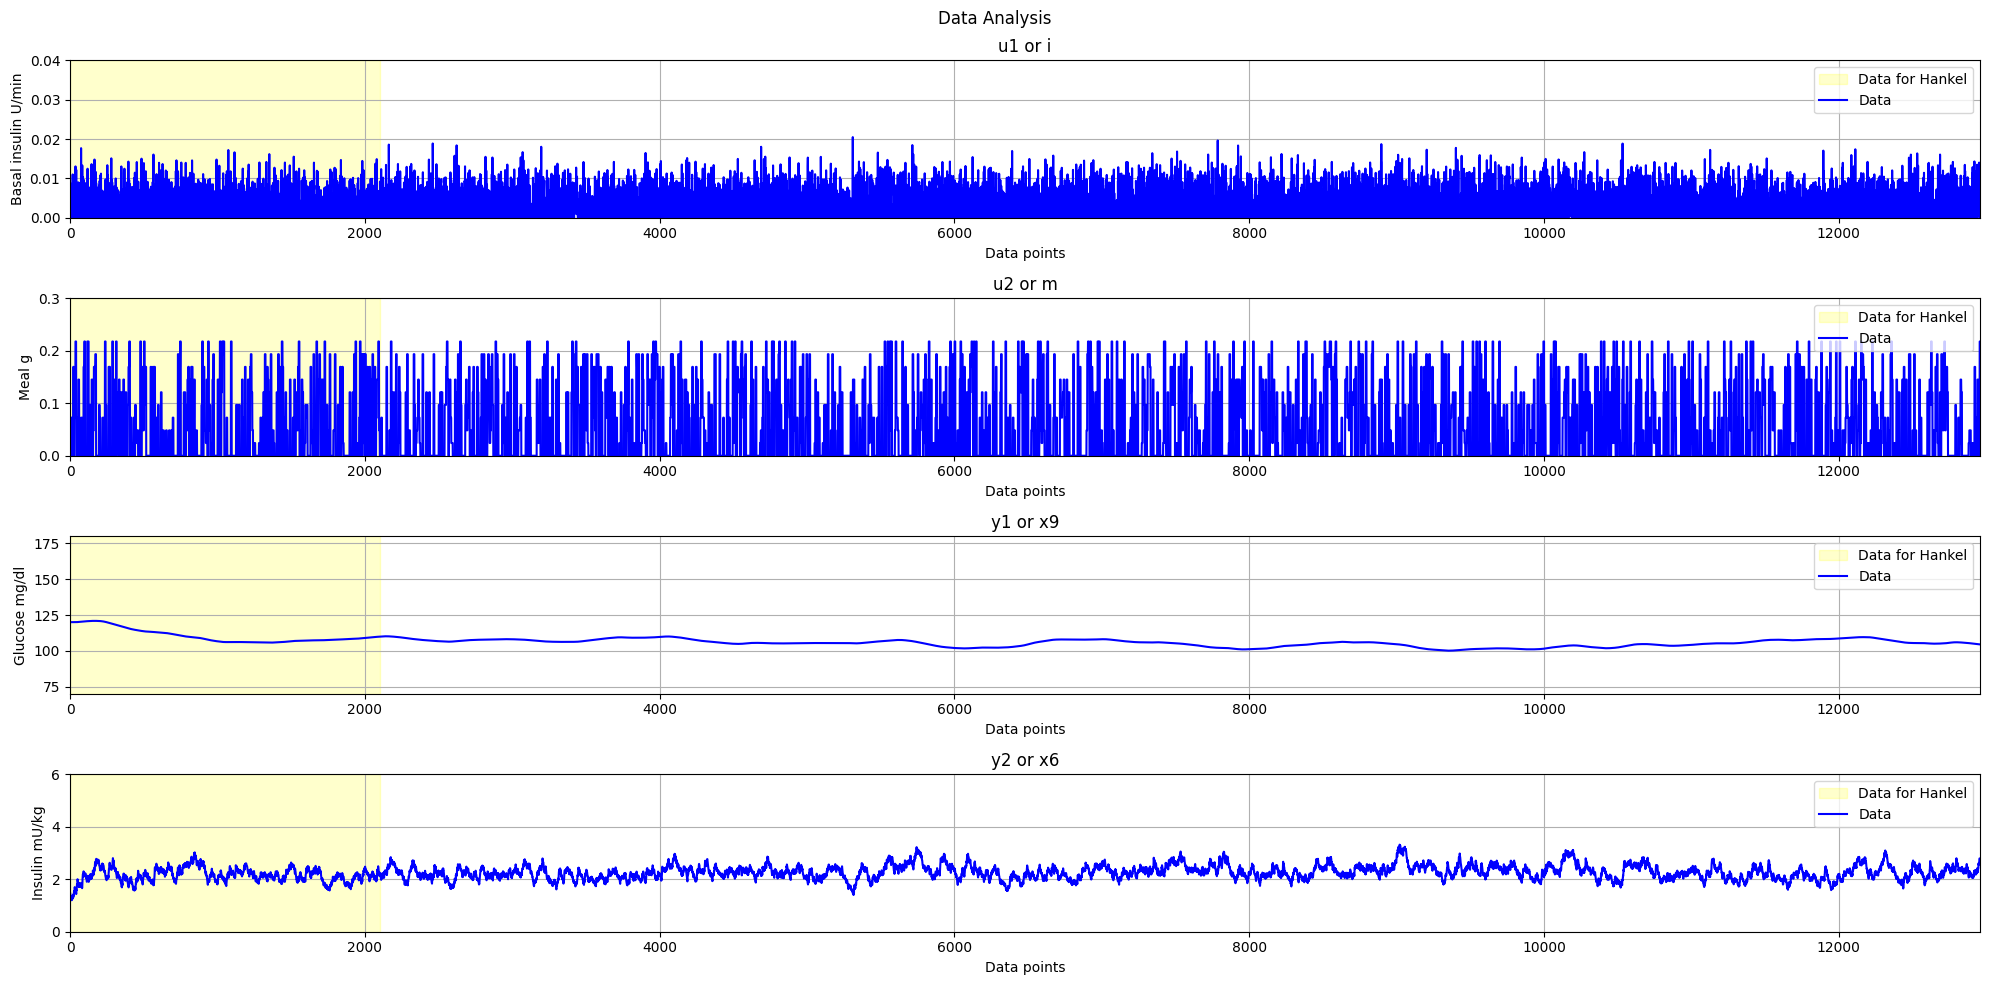

In [18]:
##################################### Data Analysis ###################################
# Variables for the plot
x_label = "Data points"
tot_num_data_used = num_hankel_cols_d * discret_time * multiplicator + L
print(f"Total number of data used: {tot_num_data_used}")

# Titles, y-labels, y-limits and data for each subplot
titles = ['u1 or i', 'u2 or m', 'y1 or x9', 'y2 or x6']
y_labels = ['Basal insulin U/min', 'Meal g', 'Glucose mg/dl', 'Insulin mU/kg']
y_lims = [[0, 0.04], [0, 0.3], [70, 180], [0, 6]]
data_col = ['input', 'meal', 'x_8', 'x_5']

# Plot
fig, axs = plt.subplots(4, 1, figsize=(20, 10))
fig.suptitle('Data Analysis')

for i, ax in enumerate(axs.flat):
    ax.fill_between(np.array([0, tot_num_data_used]), np.array([y_lims[i][0], y_lims[i][0]]), np.array([y_lims[i][1], y_lims[i][1]]), color='yellow', alpha=0.2, label='Data for Hankel')
    ax.plot(data_DeePC[data_col[i]], label='Data', color='blue')
    ax.set_title(titles[i])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_labels[i])
    ax.grid()
    ax.set_ylim(y_lims[i])
    ax.set_xlim([0, num_data_points])
    ax.legend()

plt.tight_layout()
plt.show()
plt.close()

Is the problem DPP compliant? True
Is the problem DCP compliant? True
------ START ------
--  Simulation time: 0 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 1 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 2 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 3 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 4 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 5 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 6 min  -  Inf

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Optimized control output: 0.0016495037677448077
--  Simulation time: 1621 min  -  Infeasible solutions: 0 of which None output: 0  --
Open-loop control output: 0.0016495037677448077
--  Simulation time: 1622 min  -  Infeasible solutions: 0 of which None output: 0  --
Open-loop control output: 0.0016495037677448077
--  Simulation time: 1623 min  -  Infeasible solutions: 0 of which None output: 0  --
Open-loop control output: 0.0016495037677448077
--  Simulation time: 1624 min  -  Infeasible solutions: 0 of which None output: 0  --
Open-loop control output: 0.0016495037677448077
--  Simulation time: 1625 min  -  Infeasible solutions: 0 of which None output: 0  --
Open-loop control output: 0.0016495037677448077
--  Simulation time: 1626 min  -  Infeasible solutions: 0 of which None output: 0  --
Open-loop control output: 0.0016495037677448077
--  Simulation time: 1627 min  -  Infeasible solutions: 0 of which None output: 0  --
Open-loop control output: 0.0016495037677448077
--  Simulation

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'variability': {'mean_glucose': 124.12015901959097, 'median_glucose': 120.02507935671106, 'std_glucose': 21.7574878122525, 'cv_glucose': 17.529374747915302, 'range_glucose': 80.70073654642522, 'iqr_glucose': 28.538395605957476, 'auc_glucose': 215969.0766940883, 'gmi': 6.278954203748617, 'cogi': 99.37737465663461, 'conga': 32.32975487147006, 'j_index': 21.28028784519605, 'mage_plus_index': 43.88379550370516, 'mage_minus_index': 40.63477047578661, 'mage_index': 42.259282989745884, 'ef_index': 0.5, 'modd': 14.150598253841936, 'sddm_index': 19.746450551449787, 'sdw_index': 13.7642480354872, 'std_glucose_roc': 0.0855002157093869, 'cvga': 604.194204273844}, 'time_in_ranges': {'time_in_target': 100.0, 'time_in_tight_target': 76.89655172413794, 'time_in_hypoglycemia': 0.0, 'time_in_l1_hypoglycemia': 0.0, 'time_in_l2_hypoglycemia': 0.0, 'time_in_hyperglycemia': 0.0, 'time_in_l1_hyperglycemia': 0.0, 'time_in_l2_hyperglycemia': 0.0}, 'risk': {'adrr': 4.470125647825448, 'lbgi': 0.1253635656515824

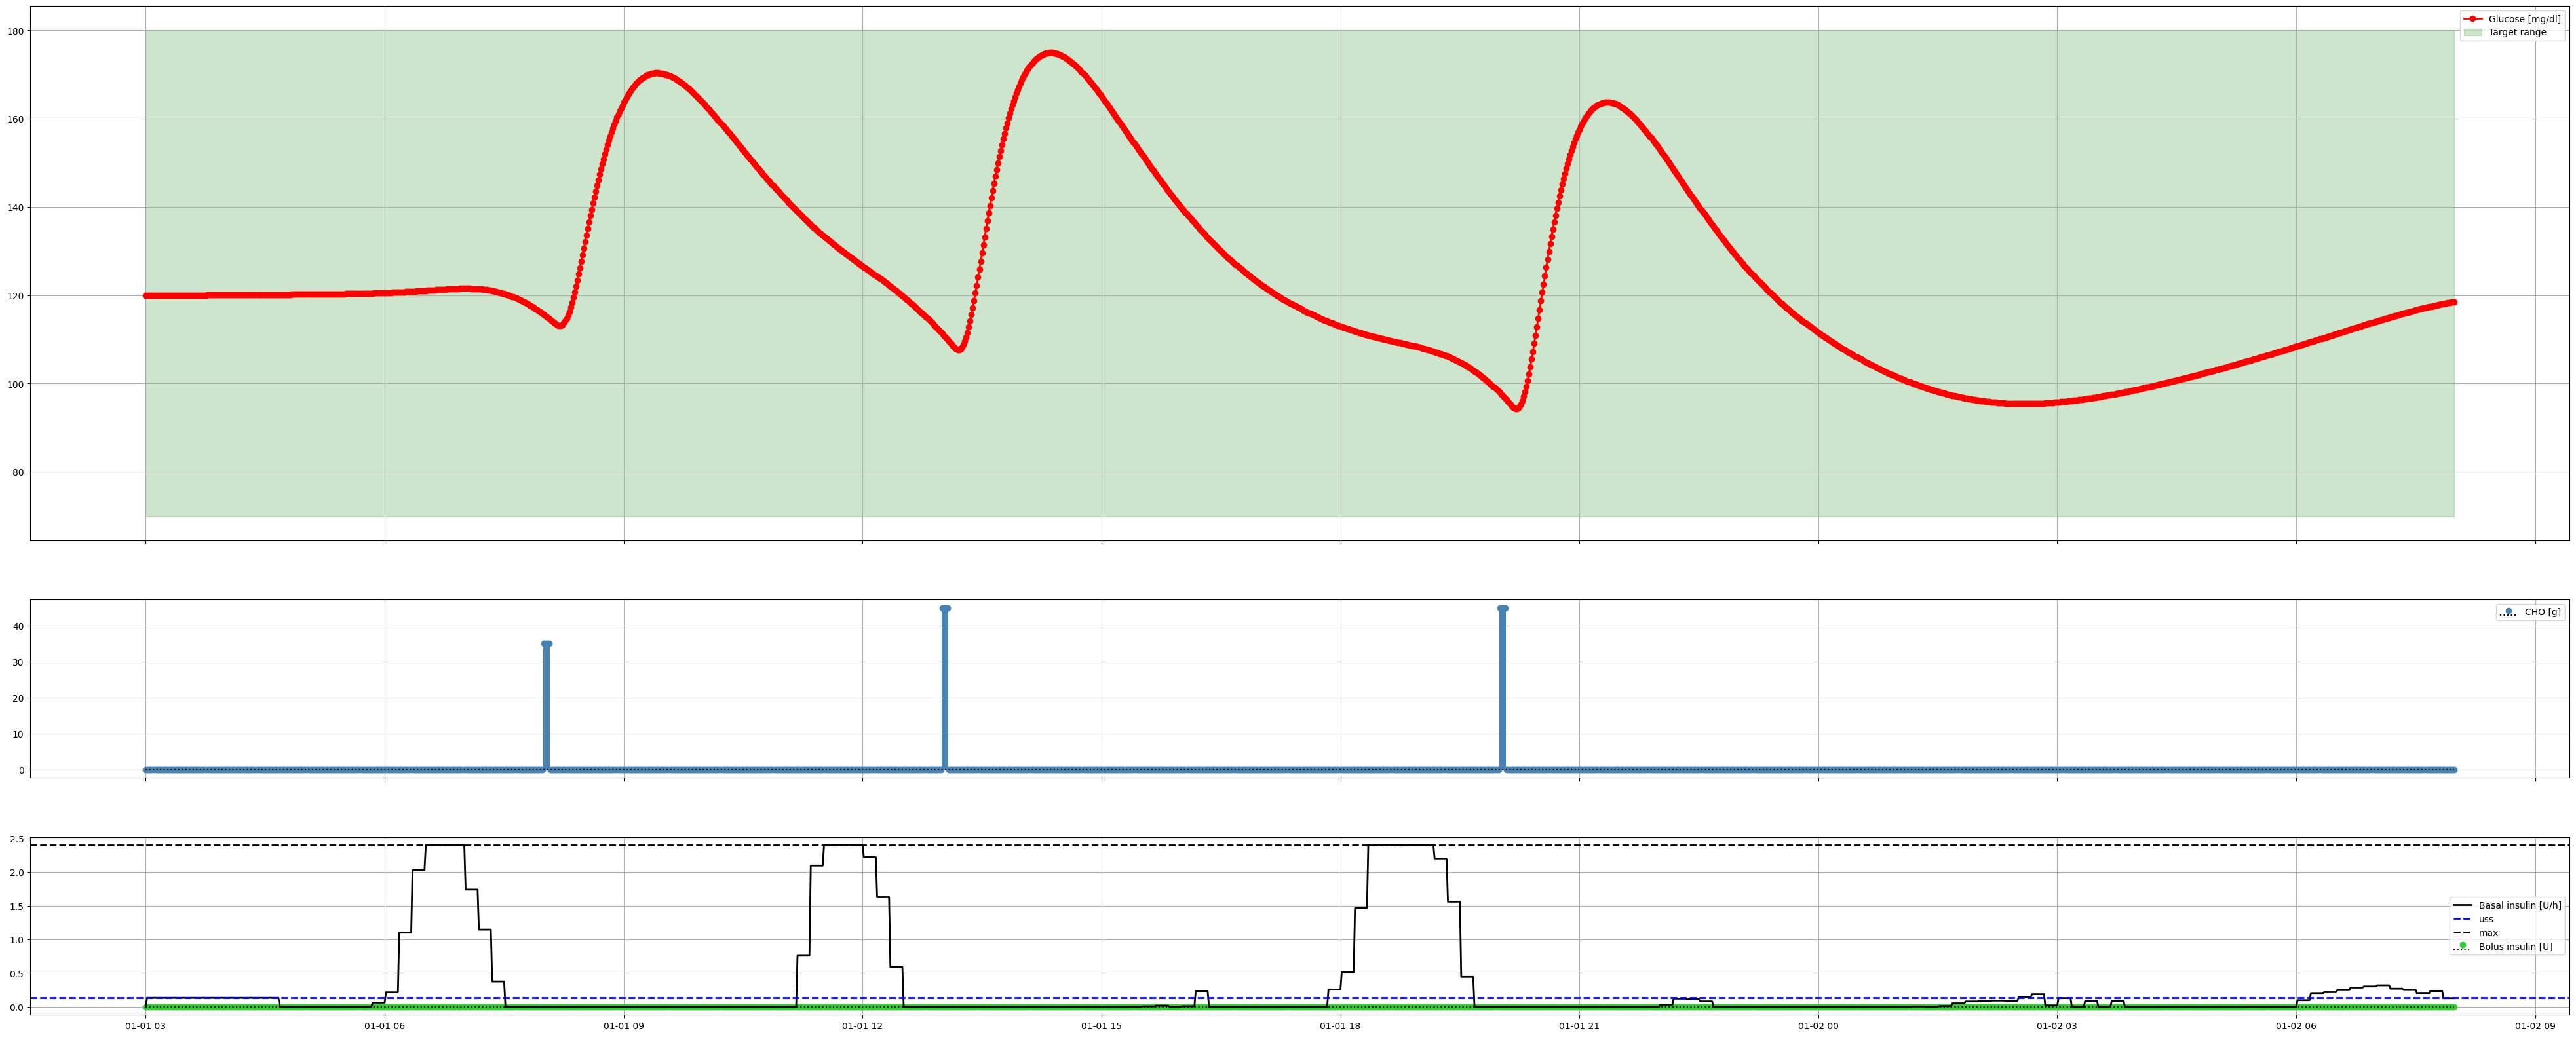

In [19]:
##################################### Run Simulation ###################################
# Initialize the dict to save inputs
basal_handler_params = dict()
basal_handler_params['open-loop input'] = None

# Get the data
# data_given = pd.read_csv('data/zero_test.csv')
# data_given = pd.read_csv('data/data_cho.csv')
data_given = pd.read_csv('data/default_data.csv')

print_output = True

# Instatiating DeePC
controller_DeePC = DeePController(T_past, T_fut, num_hankel_cols_d, q1, q2, r1, lambda_g, lambda_sigma, s, sampling_time, discret_time, H, print_output=print_output)

# Running the simulation
print("------ START ------")
glucose, i, insulin_bolus, m, time = simulate(basal_handler=controller_DeePC.compute_DeePC,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)
print("------ FINISH ------")
print("Total infeasible solutions:", np.round((controller_DeePC.num_infeas) / len(controller_DeePC.tot_cost[1:]) * 100, 2), "%")
data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)
title = r'DeePC Controller - Measuring $I_{sc1}$ and $G$'
name_png = 'task_04_deepc.png'
save = False
plot_save_results_presentation(glucose=glucose, insulin_bolus=insulin_bolus, i=i, m=m, time=time, plot=False, title=title, save=save, save_name=name_png, save_path='img')

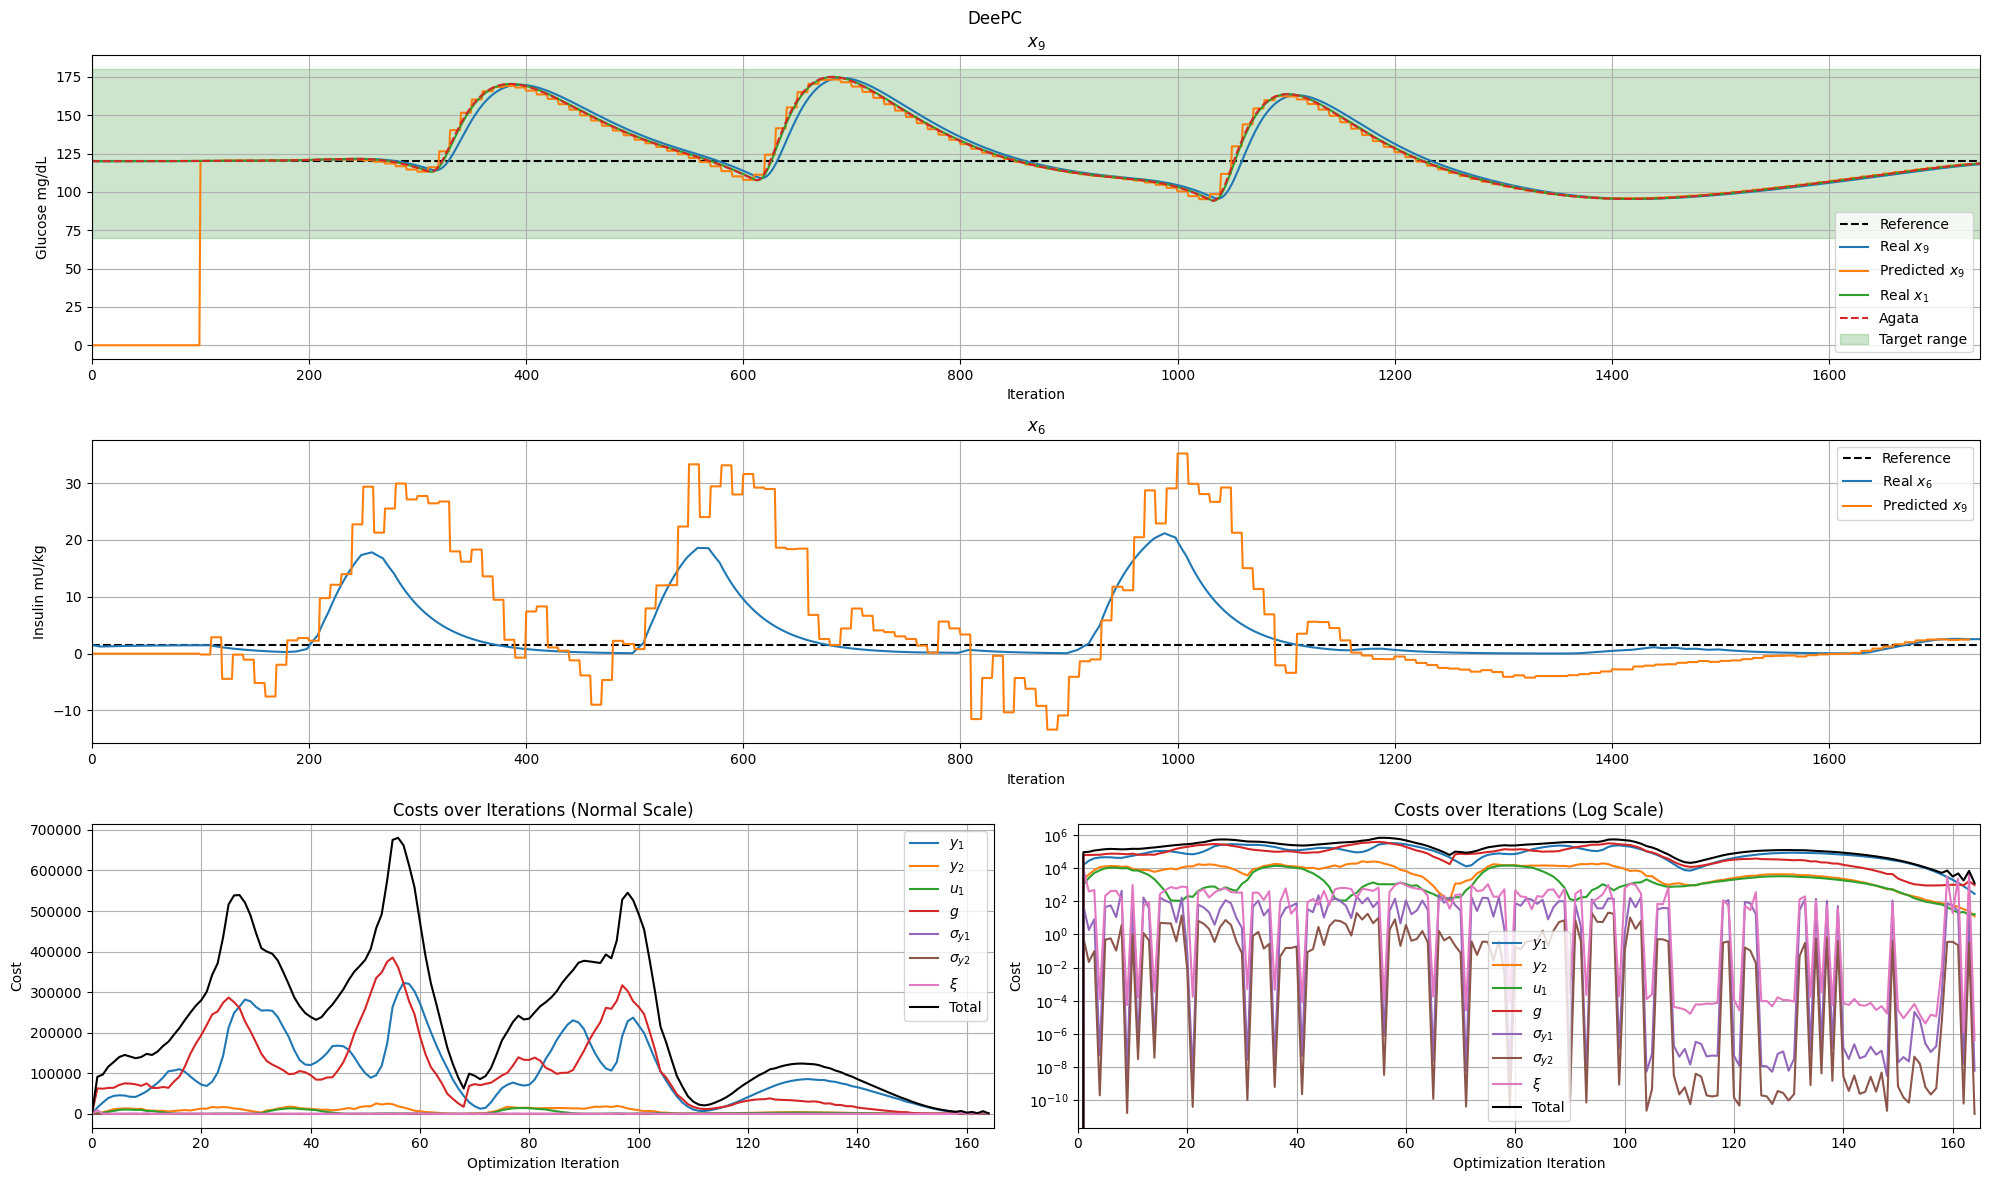

In [20]:
##################################### Post-Processing - Additional Plots ###################################
tot_cost = controller_DeePC.tot_cost
y1_cost = np.zeros(controller_DeePC.y1_var_open_loop.shape[0])
y2_cost = np.zeros(controller_DeePC.y2_var_open_loop.shape[0])
u1_cost = np.zeros(controller_DeePC.u1_var_open_loop.shape[0])
g_cost = np.zeros(controller_DeePC.g_var_open_loop.shape[0])
sigma_y1_cost = np.zeros(controller_DeePC.sigma_y1_var_open_loop.shape[0])
sigma_y2_cost = np.zeros(controller_DeePC.sigma_y2_var_open_loop.shape[0])
slack_y1_ub_cost = np.zeros(controller_DeePC.slack_y1_ub_var_open_loop.shape[0])
g_zero_norm = np.zeros(controller_DeePC.g_var_open_loop.shape[0])

for i in range(1, controller_DeePC.y1_var_open_loop.shape[0]):
    # Set to zero if no cost, meaning no optimization was performed
    if controller_DeePC.tot_cost[i] == 0:
        # Set all costs to zero
        y1_cost[i] = 0
        y2_cost[i] = 0
        u1_cost[i] = 0
        g_cost[i] = 0
        sigma_y1_cost[i] = 0
        sigma_y2_cost[i] = 0
        slack_y1_ub_cost[i] = 0
        g_zero_norm[i] = 0
    else:
        y1_cost[i] = (controller_DeePC.y1_var_open_loop[i,:] - controller_DeePC.y1_ref).T @ controller_DeePC.Q1 @ (controller_DeePC.y1_var_open_loop[i,:] - controller_DeePC.y1_ref)
        y2_cost[i] = (controller_DeePC.y2_var_open_loop[i,:] - controller_DeePC.y2_ref).T @ controller_DeePC.Q2 @ (controller_DeePC.y2_var_open_loop[i,:] - controller_DeePC.y2_ref)
        u1_cost[i] = (controller_DeePC.u1_var_open_loop[i,:] - controller_DeePC.u1_ref).T @ controller_DeePC.R1 @ (controller_DeePC.u1_var_open_loop[i,:] - controller_DeePC.u1_ref)
        g_cost[i] = np.linalg.norm(controller_DeePC.g_var_open_loop[i,:], 1) * controller_DeePC.lambda_g
        sigma_y1_cost[i] = np.linalg.norm(controller_DeePC.sigma_y1_var_open_loop[i,:], 1) * controller_DeePC.lambda_sigma
        sigma_y2_cost[i] = np.linalg.norm(controller_DeePC.sigma_y2_var_open_loop[i,:], 1) * controller_DeePC.lambda_sigma
        slack_y1_ub_cost[i] = controller_DeePC.slack_y1_ub_var_open_loop[i,:].T @ controller_DeePC.S @ controller_DeePC.slack_y1_ub_var_open_loop[i,:]
        g_zero_norm[i] = np.linalg.norm(controller_DeePC.g_var_open_loop[i,:], 0)

# Value used to account for optimization right after T_past
estim_used_first_iter = (T_past // sampling_time + 1) * sampling_time - T_past

y1_open_loop = np.repeat(controller_DeePC.y1_var_open_loop[1:,:], discret_time, axis=1)
y1_estimation = np.append(np.zeros((1, T_past)), y1_open_loop[1,:estim_used_first_iter]) # need to consider the first optimization
y1_estimation = np.append(y1_estimation, y1_open_loop[2:,:sampling_time].reshape(-1,1))

y2_open_loop = np.repeat(controller_DeePC.y2_var_open_loop[1:,:], discret_time, axis=1)
y2_estimation = np.append(np.zeros((1, T_past)), y2_open_loop[1,:estim_used_first_iter]) # need to consider the first optimization
y2_estimation = np.append(y2_estimation, y2_open_loop[2:,:sampling_time].reshape(-1,1))

x_max = len(controller_DeePC.x9)

fig = plt.figure(figsize=(20, 12))
fig.suptitle('DeePC')
gs = fig.add_gridspec(3, 2)

ax1 = fig.add_subplot(gs[0, :])
ax1.axhline(y=controller_DeePC.y1_ref[0], color='k', linestyle='--', label='Reference')
ax1.plot(controller_DeePC.x9, label=r'Real $x_9$')
ax1.plot(y1_estimation, label=r'Predicted $x_9$')
ax1.plot(controller_DeePC.x1, label=r'Real $x_1$')
ax1.plot(glucose, linestyle='--', label='Agata')
ax1.fill_between(np.array([0, x_max]), np.array([70, 70]), np.array([180, 180]), color='green', alpha=0.2, label='Target range')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Glucose mg/dL')
ax1.set_title(r'$x_9$')
ax1.legend()
ax1.grid()
ax1.set_xlim(0, x_max)

ax2 = fig.add_subplot(gs[1, :])
ax2.axhline(y=controller_DeePC.y2_ref[0], color='k', linestyle='--', label='Reference')
ax2.plot(controller_DeePC.x6, label=r'Real $x_6$')
ax2.plot(y2_estimation, label=r'Predicted $x_9$')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Insulin mU/kg')
ax2.set_title(r'$x_6$')
ax2.legend()
ax2.grid()
ax2.set_xlim(0, x_max)

# Variables for the loop
plots_info = [
    (fig.add_subplot(gs[2, 0]), 'Costs over Iterations (Normal Scale)', 'linear'),
    (fig.add_subplot(gs[2, 1]), 'Costs over Iterations (Log Scale)', 'log')
    ]
costs_data = [
    (y1_cost, r'$y_1$'),
    (y2_cost, r'$y_2$'),
    (u1_cost, r'$u_1$'),
    (g_cost, r'$g$'),
    (sigma_y1_cost, r'$\sigma_{y1}$'),
    (sigma_y2_cost, r'$\sigma_{y2}$'),
    (slack_y1_ub_cost, r'$\xi$'),
    (tot_cost, 'Total', 'k')
    ]
# Costs
for ax, title, yscale in plots_info:
    for data, label, *color in costs_data:
        ax.plot(data, label=label, color=color[0] if color else None)
    ax.set_xlabel('Optimization Iteration')
    ax.set_ylabel('Cost')
    ax.set_title(title)
    ax.legend()
    ax.grid()
    ax.set_xlim(0, len(tot_cost))
    ax.set_yscale(yscale)

plt.tight_layout()
plt.show()
plt.close()

### Possible Improvements

The current DeePC formulation has certain limitations that could be improved:
- Ensuring stability in DeePC,
- Reducing the aggressiveness of insulin input,
- Achieving faster reference tracking after dinner to ensure the next day starts at the reference glucose level,
- Adding noise to both the data used to construct $\mathcal{H}$ and the measured values, and
- Utilizing only measurable data.

# DeePC - Bonus


<h2 id="task5_bonus">Task 5: Bonus - DeePC Based on Glucose Concentration and Noise-Corrupted Data</h2>

Use the ReplayBG simulator, or data from the simulator, to either improve upon one of the two AP controllers you proposed in a significant manner, or demonstrate a new controller which requires a simulator or more data.

### Controller Choice
To make the previous controller more realistic, we can develop a regularized tracking DeePC that only considers the physically measurable glucose output and that the collected data is noisy. The mathematical description and implementation is similar to [above](#deepc_math_description) with the only exceptions being $p=1$ and noisy data, which results in
- $y_\mathrm{ref} = x_{9,ss}$,
- $y_k = x_{9,k}$,
- $Q = q \in \mathbb{R}_{\geq 0}$ penalizes the output at all future times in $K$,
- The columns of `DeePC_data.pkl` used to construct $\mathcal{H}$ are the two inputs (insulin and meals) and the glucose concentration. All three of them are corrupted by white Gaussian noise.
- The ratio between width and height is now related to $\mathcal{H}_{m \cdot L}(\textbf{u}_{\text{data}})$ to keep the same column dimension as before.

Additionally, the following terminal constraint is added.
$$\textbf{y}_K = \begin{bmatrix} x_{9,ss} & x_{6,ss} \end{bmatrix}^T$$

#### Class Structure - `DeePController_Bonus`
- `__init__()`: Constructs the controller by saving the relevant parameters, by partitioning the Hankel matrix and by calling `_init_optimization_problem()`
- `_init_optimization_problem()`: Constructs the OCP.
- `_save_unfeasible_var()`: Used for plotting. Saves a value of zero in case the solver fails.
- `_save_var()`: Used for plotting. Saves the optimal values.
- `_update_past_inputs()`: Updates the value of the last inputs by removing the oldest value.
- `_update_past_output()`: Similar for the output.
- `compute_mpc()`: Function to call the controller: The OCP is solved with frequency equal to the sampling time. During the rest of the time and in case the solver fails, the open-loop control outputs are used.

In [21]:
class DeePController_bonus:
    """
    DeePC controller considering only the measureable glucose output.
    """
    def __init__(self, T_past:int, T_fut:int, num_hankel_cols_d:int, q1:float, r1:float, lambda_g:float, lambda_sigma:float, s:float, sampling_time:int, discret_time:int, H:tuple, print_output:bool=False, verbose:bool=False) -> None:
        """
        Initialize the DeePC controller.

        Parameters
        -------
        :param T_past: The length of past points of a trajectory.
        :param T_fut: The length of future points of a trajectory.
        :param num_hankel_cols_d: The number of columns in the Hankel matrix.
        :param q1: The weight for the first output.
        :param r1: The weight for the input.
        :param lambda_g: The weight for the L1 norm of the control input.
        :param lambda_sigma: The weight for the L1 norm of the slack variables.
        :param s: The slack variable cost.
        :param sampling_time: The sampling time in minutes.
        :param discret_time: The discretization time in minutes.
        :param H: The Hankel matrix as a tuple with three components: H_u1, H_u2, H_y1.
        :param print_output: Print the output of the controller.
        :param verbose: Print the solver output.

        Returns
        -------
        :return: None
        """
        self.num_hankel_cols_d = num_hankel_cols_d
        self.sampling_time = sampling_time
        self.discret_time = discret_time

        self.T_past = T_past
        self.T_past_d = int(self.T_past / self.discret_time)

        self.T_fut = T_fut
        self.T_fut_d = int(self.T_fut / self.discret_time)

        self.L = self.T_past + self.T_fut
        self.L_d = int(self.L / self.discret_time)

        # Weights cost
        self.Q1 = q1 * np.eye(self.T_fut_d)
        self.R1 = r1 * np.eye(self.T_fut_d)
        self.S  = s  * np.eye(self.T_fut_d)
        self.lambda_g     = lambda_g
        self.lambda_sigma = lambda_sigma

        # Constraints
        self.u1_lb = np.zeros(self.T_fut_d)
        self.u1_ub = np.ones(self.T_fut_d) * 0.04
        self.y1_lb = np.ones(self.T_fut_d) * 70
        self.y1_ub = np.ones(self.T_fut_d) * 180

        # Unpack Hankel matrix
        self.H_u1, self.H_u2, self.H_y1 = H

        # Full partitioning of Hankel matrix
        self.H_u1_past = self.H_u1[:self.T_past_d, :]
        self.H_u1_fut  = self.H_u1[-self.T_fut_d:, :]
        self.H_u2_past = self.H_u2[:self.T_past_d, :]
        self.H_u2_fut  = self.H_u2[-self.T_fut_d:, :]
        self.H_y1_past = self.H_y1[:self.T_past_d, :]
        self.H_y1_fut  = self.H_y1[-self.T_fut_d:, :]

        # Initialize past vectors
        self.u1_past = np.zeros(self.T_past)
        self.u2_past = np.zeros(self.T_past)
        self.y1_past = np.zeros(self.T_past)

        self.verbose = verbose
        self.print_output = print_output
        self.num_infeas = 0
        self.num_None_output = 0
        self.tot_T_sim = 0

        self._init_optimization_problem()

        # Variables for plots
        self.y1_ref = None
        self.u1_ref = None
        self.x9 = np.array([])
        self.tot_cost = np.zeros(1)
        self.y1_var_open_loop = np.zeros(self.T_fut_d)
        self.u1_var_open_loop = np.zeros(self.T_fut_d)
        self.g_var_open_loop  = np.zeros(self.num_hankel_cols_d)
        self.sigma_y1_var_open_loop = np.zeros(self.T_past_d)
        self.sigma_u1_var_open_loop = np.zeros(self.T_past_d)
        self.slack_y1_ub_var_open_loop = np.zeros(self.T_fut_d)

    def _init_optimization_problem(self) -> None:
        """
        Initialize the parametrized optimization problem and its components.

        Returns
        -------
        :return: None
        """
        # Define parameters
        self.u1_past_param  = cp.Parameter(self.T_past_d)
        self.u2_past_param  = cp.Parameter(self.T_past_d)
        self.y1_past_param  = cp.Parameter(self.T_past_d)
        self.y1_ref_param   = cp.Parameter(self.T_fut_d)
        self.u1_ref_param   = cp.Parameter(self.T_fut_d)
        self.meal_fut_param = cp.Parameter(self.T_fut_d)

        # Define optimization variables
        self.u1_var          = cp.Variable(self.T_fut_d)
        self.y1_var          = cp.Variable(self.T_fut_d)
        self.g_var           = cp.Variable(self.num_hankel_cols_d)
        self.sigma_y1_var    = cp.Variable(self.T_past_d)
        self.slack_y1_ub_var = cp.Variable(self.T_fut_d)

        # Define the cost function
        cost = (
            cp.quad_form(self.y1_var - self.y1_ref_param, self.Q1) +
            cp.quad_form(self.u1_var - self.u1_ref_param, self.R1) +
            cp.norm1(self.g_var) * self.lambda_g +
            cp.norm1(self.sigma_y1_var) * self.lambda_sigma +
            cp.quad_form(self.slack_y1_ub_var, self.S)
            )

        # Define the constraints
        constraints = [
            self.H_u1_past @ self.g_var == self.u1_past_param,
            self.H_u2_past @ self.g_var == self.u2_past_param,
            self.H_u1_fut  @ self.g_var == self.u1_var,
            self.H_u2_fut  @ self.g_var == self.meal_fut_param,
            self.H_y1_past @ self.g_var == self.y1_past_param + self.sigma_y1_var,
            self.H_y1_fut  @ self.g_var == self.y1_var,
            self.u1_var >= self.u1_lb,
            self.u1_var <= self.u1_ub,
            self.y1_var >= self.y1_lb,
            self.y1_var <= self.y1_ub + self.slack_y1_ub_var,
            self.slack_y1_ub_var >= 0,
            self.y1_var[-1] == self.y1_ref_param[-1], # terminal constraint
            ]

        # Define the problem
        self.problem = cp.Problem(cp.Minimize(cost), constraints)

        if self.print_output:
            print("Is the problem DPP compliant?", self.problem.is_dpp())
            print("Is the problem DCP compliant?", self.problem.is_dcp())

    def _save_unfeasible_var(self) -> None:
        """
        Save zeros for all variables in case of infeasibility to use for plots.

        Returns
        -------
        :return: None
        """
        self.tot_cost = np.vstack((self.tot_cost, np.zeros(1)))
        self.y1_var_open_loop = np.vstack((self.y1_var_open_loop, np.zeros(self.T_fut_d)))
        self.u1_var_open_loop = np.vstack((self.u1_var_open_loop, np.zeros(self.T_fut_d)))
        self.g_var_open_loop = np.vstack((self.g_var_open_loop, np.zeros(self.num_hankel_cols_d)))
        self.sigma_y1_var_open_loop = np.vstack((self.sigma_y1_var_open_loop, np.zeros(self.T_past_d)))
        self.slack_y1_ub_var_open_loop = np.vstack((self.slack_y1_ub_var_open_loop, np.zeros(self.T_fut_d)))

    def _save_var(self) -> None:
        """
        Save the optimized variables in the corresponding vectors to use for plots.

        Returns
        -------
        :return: None
        """
        self.tot_cost = np.vstack((self.tot_cost, self.problem.value))
        self.y1_var_open_loop = np.vstack((self.y1_var_open_loop, self.y1_var.value))
        self.u1_var_open_loop = np.vstack((self.u1_var_open_loop, self.u1_var.value))
        self.g_var_open_loop = np.vstack((self.g_var_open_loop, self.g_var.value))
        self.sigma_y1_var_open_loop = np.vstack((self.sigma_y1_var_open_loop, self.sigma_y1_var.value))
        self.slack_y1_ub_var_open_loop = np.vstack((self.slack_y1_ub_var_open_loop, self.slack_y1_ub_var.value))
    
    def _update_past_inputs(self, control_output:np.ndarray, meal:np.ndarray) -> None:
        """
        Update the past vectors with the computed control output and meal.

        Parameters
        -------
        :param control_output: The computed next control output.
        :param meal: The next meal input.

        Returns
        -------
        :return: None
        """
        self.u1_past[:-1] = self.u1_past[1:]
        self.u1_past[-1] = control_output

        self.u2_past[:-1] = self.u2_past[1:]
        self.u2_past[-1] = meal[0]

    def _update_past_output(self, x0:np.ndarray) -> None:
        """
        Update the past vector with the new state and save the state variable for plots.

        Parameters
        -------
        :param x0: The new state.

        Returns
        -------
        :return: None
        """
        self.y1_past[:-1] = self.y1_past[1:]
        self.y1_past[-1] = x0[8]

        self.x9 = np.append(self.x9, x0[8])

    def compute_DeePC(self, model, x0, tau, time_index, inputs_, xss, uss, dss) -> tuple:
        """
        Implements the tracking MPC controller.

        Parameters
        -------
        model: the T1DModel class describing the dynamics, provided by ReplayBG
        x0: the current state
        tau: delay of the system in min
        time_index: shows the current time step
        inputs_: a time series with the basal input that was/will be applied to the system
                (useful for implementing delay)
        xss, uss: the linearization point
        dss: Contains basal_handler_params and servers two functions:
            1) a dict that for the controller hyperparameters.
            2) memory for the next iteration (hence dss also being an output)
        
        Returns
        -------
        i: The basal insulin rate to administer at time[time_index+1].
        dss: [see above]
        """
        if self.print_output:
            print(f"--  Simulation time: {time_index} min  -  Infeasible solutions: {self.num_infeas} of which None output: {self.num_None_output}  --")
        self.tot_T_sim = time_index

        # Save reference values at the first time step
        if time_index == 0:
            self.y1_ref = np.ones(self.T_fut_d) * xss[8]
            self.u1_ref = np.ones(self.T_fut_d) * uss

            self.y1_ref_param.value = self.y1_ref
            self.u1_ref_param.value = self.u1_ref

            # Set open-loop control
            dss.basal_handler_params['open-loop input'] = np.ones(self.T_fut) * uss

        # Populate past vectors
        if time_index < self.T_past:
            self.y1_past[time_index] = x0[8]

            control_output = uss
            meal_next = model.get_discretized_meals(initial_time_step=time_index, duration=1, T=1)

            self.u1_past[time_index] = control_output
            self.u2_past[time_index] = meal_next[0]

            self.x9 = np.append(self.x9, x0[8])

            if self.print_output:
                print(f"Gathering past data. Fix control output: {control_output}")
            return control_output, dss

        # Optimization right after T_past or at every sampling time
        if (time_index % self.sampling_time) == 0 or time_index == self.T_past:
            self._update_past_output(x0)

            meal_next = model.get_discretized_meals(initial_time_step=time_index, duration=1, T=1)

            # Update parameters for the optimization problem
            self.meal_fut_param.value = model.get_discretized_meals(initial_time_step=time_index, duration=self.T_fut, T=self.discret_time)
            self.u1_past_param.value = np.mean(self.u1_past.reshape(-1, self.discret_time), axis=1)
            self.u2_past_param.value = np.sum(self.u2_past.reshape(-1, self.discret_time), axis=1)
            self.y1_past_param.value = np.mean(self.y1_past.reshape(-1, self.discret_time), axis=1)

            # Solve the optimization problem
            try:
                self.problem.solve(solver=cp.MOSEK, verbose=self.verbose)

                # Check if the solution is available
                if self.u1_var.value is None:
                    raise Exception("Solver did not find a feasible solution.")
                
            # Fallback solver
            except:       
                try:
                    self.problem.solve(solver=cp.CLARABEL, verbose=self.verbose)

                    # Check if the solution is available
                    if self.u1_var.value is None:
                        self.num_None_output += 1
                        raise Exception("Fallback solver did not find a feasible solution.")

                except:
                    self.num_infeas += 1
                    
                    control_output = dss.basal_handler_params['open-loop input'][time_index % self.sampling_time]

                    self._save_unfeasible_var()

                    self._update_past_inputs(control_output, meal_next)

                    if self.print_output:
                        print(f"Forced control output: {control_output}")
                    return control_output, dss
            
            # Problem solved
            control_output = self.u1_var[0].value

            # Save open-loop input
            dss.basal_handler_params['open-loop input'] = np.repeat(self.u1_var.value, self.discret_time)

            self._save_var()
            
            self._update_past_inputs(control_output, meal_next)

            if self.print_output:
                print(f"Optimized control output: {control_output}")
            return control_output, dss
        
        # Open-loop control
        else:
            self._update_past_output(x0)

            control_output = dss.basal_handler_params['open-loop input'][time_index % self.sampling_time]
            meal_next = model.get_discretized_meals(initial_time_step=time_index, duration=1, T=1)

            self._update_past_inputs(control_output, meal_next)

            if self.print_output:
                print(f"Open-loop control output: {control_output}")
            return control_output, dss

In [22]:
def add_white_gaussian_noise(data, *,noise_level:float) -> pd.DataFrame:
    """
    Add white Gaussian noise to the data.

    Parameters
    -------
    :param data: The input dataframe.
    :param noise_level: The noise level in percentage.

    Returns
    -------
    :return: The data with added noise.
    """
    noise = noise_level * data.std() * np.random.randn(*data.shape)
    return data + noise

#### Tuning Iteration
The tuning steps described [above](#deepc_tuning_iteration) are also used to tune this controller.

In [23]:
##################################### DeePC - Hankel and Tuning - Bonus ###################################
# Dimensions
n = 9 # assumed as unknown
m = 2
p = 1

# Trajectory
sampling_time = 10
discret_time = 10
pred_time = 300
T_fut = pred_time
assert pred_time % discret_time == 0, "pred_time should be a multiple of the discretization time."
assert pred_time >= sampling_time, "pred_time should be greater than the sampling time."
T_fut_d = int(T_fut / discret_time)

T_past_d = 10
assert T_past_d >= n, "T_past_d should be greater than n."
T_ini = int(T_past_d * discret_time)
T_past = T_ini

L = T_past + T_fut
L_d = T_past_d + T_fut_d

# Collect data
data_DeePC = pd.read_pickle("DeePC_data.pkl")
num_data_points = data_DeePC.shape[0]

data_d = discretize_data(data_DeePC, discret_time)

# Add noise to the data
noise_level = 0.1 / 100
data_noisy = data_DeePC.apply(lambda col: add_white_gaussian_noise(col, noise_level=noise_level))
data_d_noisy = discretize_data(data_noisy, discret_time)

# Hankel matrices
num_hankel_rows_d = (m + p) * L_d
print("Number of Hankel rows:", num_hankel_rows_d)

ratio_H_u = 2.5 # ratio between width and height of H_u (for square H with ratio 1.5)
num_hankel_cols_d = int(m * L_d * ratio_H_u) # same number of columns for H_u and H_y
print("Number of Hankel columns:", num_hankel_cols_d)

H_u1_d = np.zeros((L_d, num_hankel_cols_d))
H_u2_d = np.zeros((L_d, num_hankel_cols_d))
H_y1_d = np.zeros((L_d, num_hankel_cols_d))

H_u1_d_noisy = np.zeros((L_d, num_hankel_cols_d))
H_u2_d_noisy = np.zeros((L_d, num_hankel_cols_d))
H_y1_d_noisy = np.zeros((L_d, num_hankel_cols_d))

# multiplicator = (num_data_points - L) // num_hankel_cols_d # for using the maximum amount of data
# multiplicator = max(1, min(multiplicator, L_d))
multiplicator = 1

# Fill the Hankel matrices
for i in range(num_hankel_cols_d):
    H_u1_d[:, i] = data_d['input'][i * multiplicator:i * multiplicator + L_d].values
    H_u2_d[:, i] = data_d['meal'][i * multiplicator:i * multiplicator + L_d].values
    H_y1_d[:, i] = data_d['x_8'][i * multiplicator:i * multiplicator + L_d].values

    H_u1_d_noisy[:, i] = data_d_noisy['input'][i * multiplicator:i * multiplicator + L_d].values
    H_u2_d_noisy[:, i] = data_d_noisy['meal'][i * multiplicator:i * multiplicator + L_d].values
    H_y1_d_noisy[:, i] = data_d_noisy['x_8'][i * multiplicator:i * multiplicator + L_d].values

H = (H_u1_d, H_u2_d, H_y1_d)

H_noisy = (H_u1_d_noisy, H_u2_d_noisy, H_y1_d_noisy)

# Tuning parameters noiselss
q1 = 2
r1 = 1e6
lambda_g = 10
lambda_sigma = 1e6
s = 1

# Tuning parameters noisy
q1_noisy = 2
r1_noisy = 0.8e6
lambda_g_noisy = 8
lambda_sigma_noisy = 1e6
s_noisy = 1

use_noise = False

Number of Hankel rows: 120
Number of Hankel columns: 200


Total number of data used: 2400


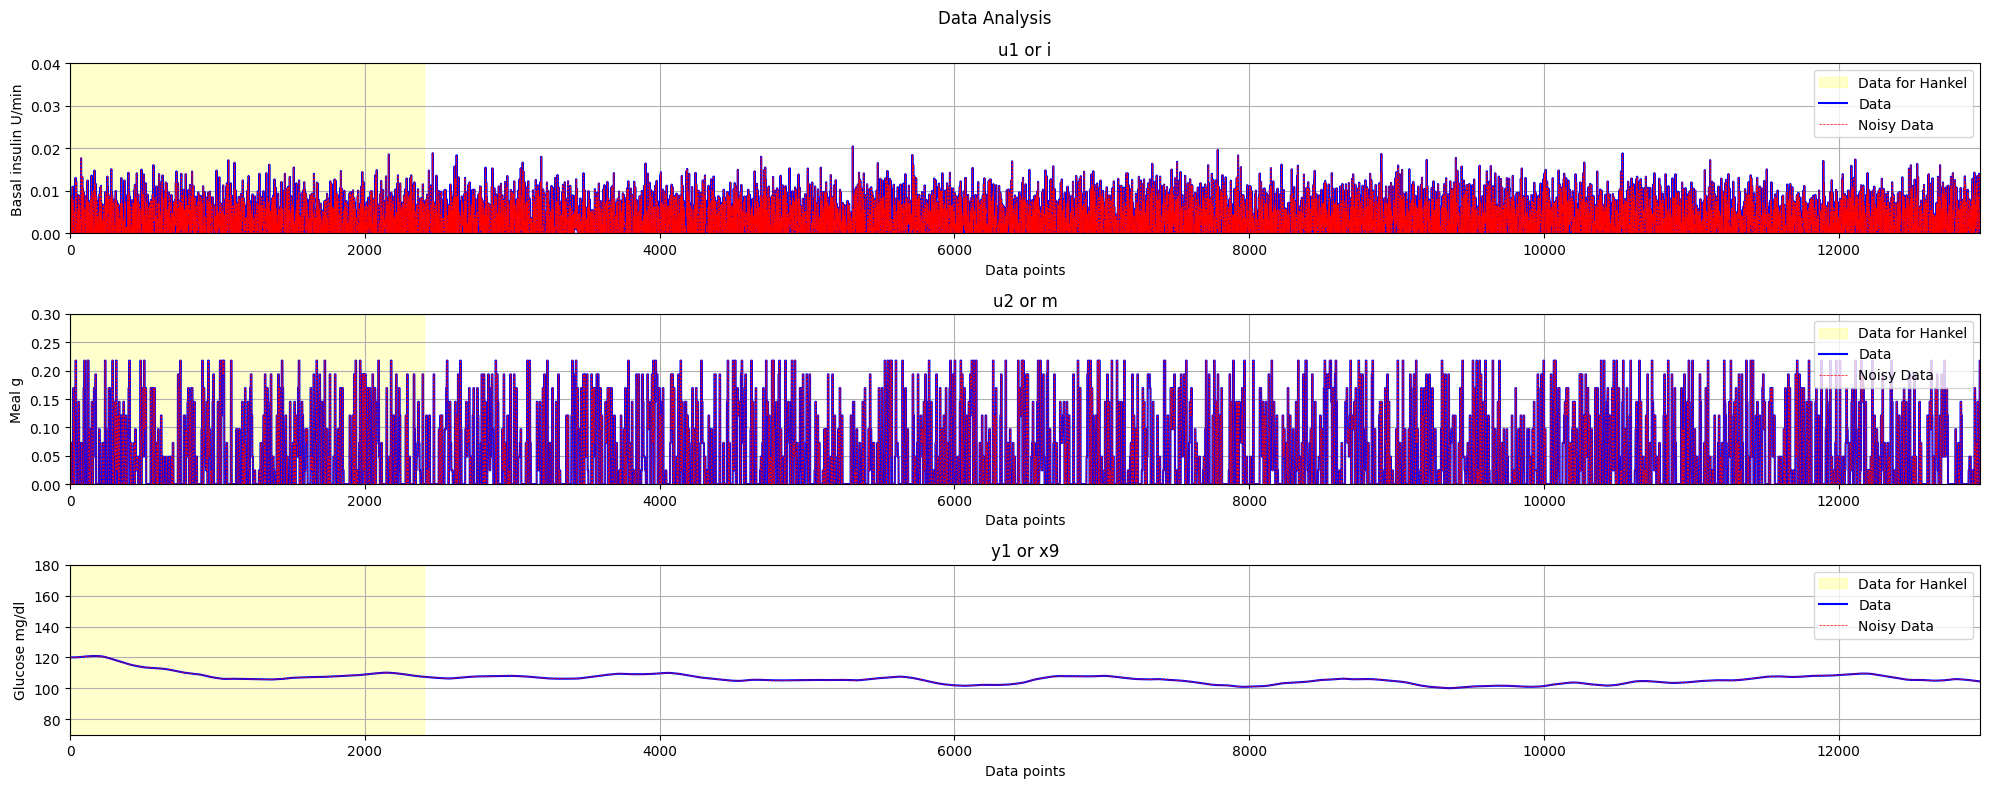

In [24]:
##################################### Data Analysis ###################################
# Variables for the plot
x_label = "Data points"
tot_num_data_used = num_hankel_cols_d * discret_time * multiplicator + L
print(f"Total number of data used: {tot_num_data_used}")

# Titles, y-labels, y-limits and data for each subplot
titles = ['u1 or i', 'u2 or m', 'y1 or x9']
y_labels = ['Basal insulin U/min', 'Meal g', 'Glucose mg/dl']
y_lims = [[0, 0.04], [0, 0.3], [70, 180]]
data_col = ['input', 'meal', 'x_8']

# Plot
fig, axs = plt.subplots(3, 1, figsize=(20, 8))
fig.suptitle('Data Analysis')

for i, ax in enumerate(axs.flat):
    ax.fill_between(np.array([0, tot_num_data_used]), np.array([y_lims[i][0], y_lims[i][0]]), np.array([y_lims[i][1], y_lims[i][1]]), color='yellow', alpha=0.2, label='Data for Hankel')
    ax.plot(data_DeePC[data_col[i]], label='Data', color='blue')
    ax.plot(data_noisy[data_col[i]], label='Noisy Data', color='red', linewidth=0.5, linestyle='--')
    ax.set_title(titles[i])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_labels[i])
    ax.grid()
    ax.set_ylim(y_lims[i])
    ax.set_xlim([0, num_data_points])
    ax.legend()

plt.tight_layout()
plt.show()
plt.close()

Is the problem DPP compliant? True
Is the problem DCP compliant? True
------ START ------
--  Simulation time: 0 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 1 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 2 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 3 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 4 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 5 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 6 min  -  Inf

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'variability': {'mean_glucose': 121.3707515601968, 'median_glucose': 120.00000411536712, 'std_glucose': 23.62849114036672, 'cv_glucose': 19.46802737614061, 'range_glucose': 85.92020762300146, 'iqr_glucose': 34.602333552391144, 'auc_glucose': 211185.10771474242, 'gmi': 6.2131883773199075, 'cogi': 99.06585229098124, 'conga': 33.83803055965699, 'j_index': 21.02478038373692, 'mage_plus_index': 39.86512957662756, 'mage_minus_index': 43.972047222782805, 'mage_index': 41.918588399705186, 'ef_index': 1.0, 'modd': 23.1055120360484, 'sddm_index': 23.079213498554658, 'sdw_index': 13.250062537300133, 'std_glucose_roc': 0.0888257057115118, 'cvga': 830.244697708175}, 'time_in_ranges': {'time_in_target': 100.0, 'time_in_tight_target': 77.35632183908046, 'time_in_hypoglycemia': 0.0, 'time_in_l1_hypoglycemia': 0.0, 'time_in_l2_hypoglycemia': 0.0, 'time_in_hyperglycemia': 0.0, 'time_in_l1_hyperglycemia': 0.0, 'time_in_l2_hyperglycemia': 0.0}, 'risk': {'adrr': 5.061766362827033, 'lbgi': 0.26963836255142

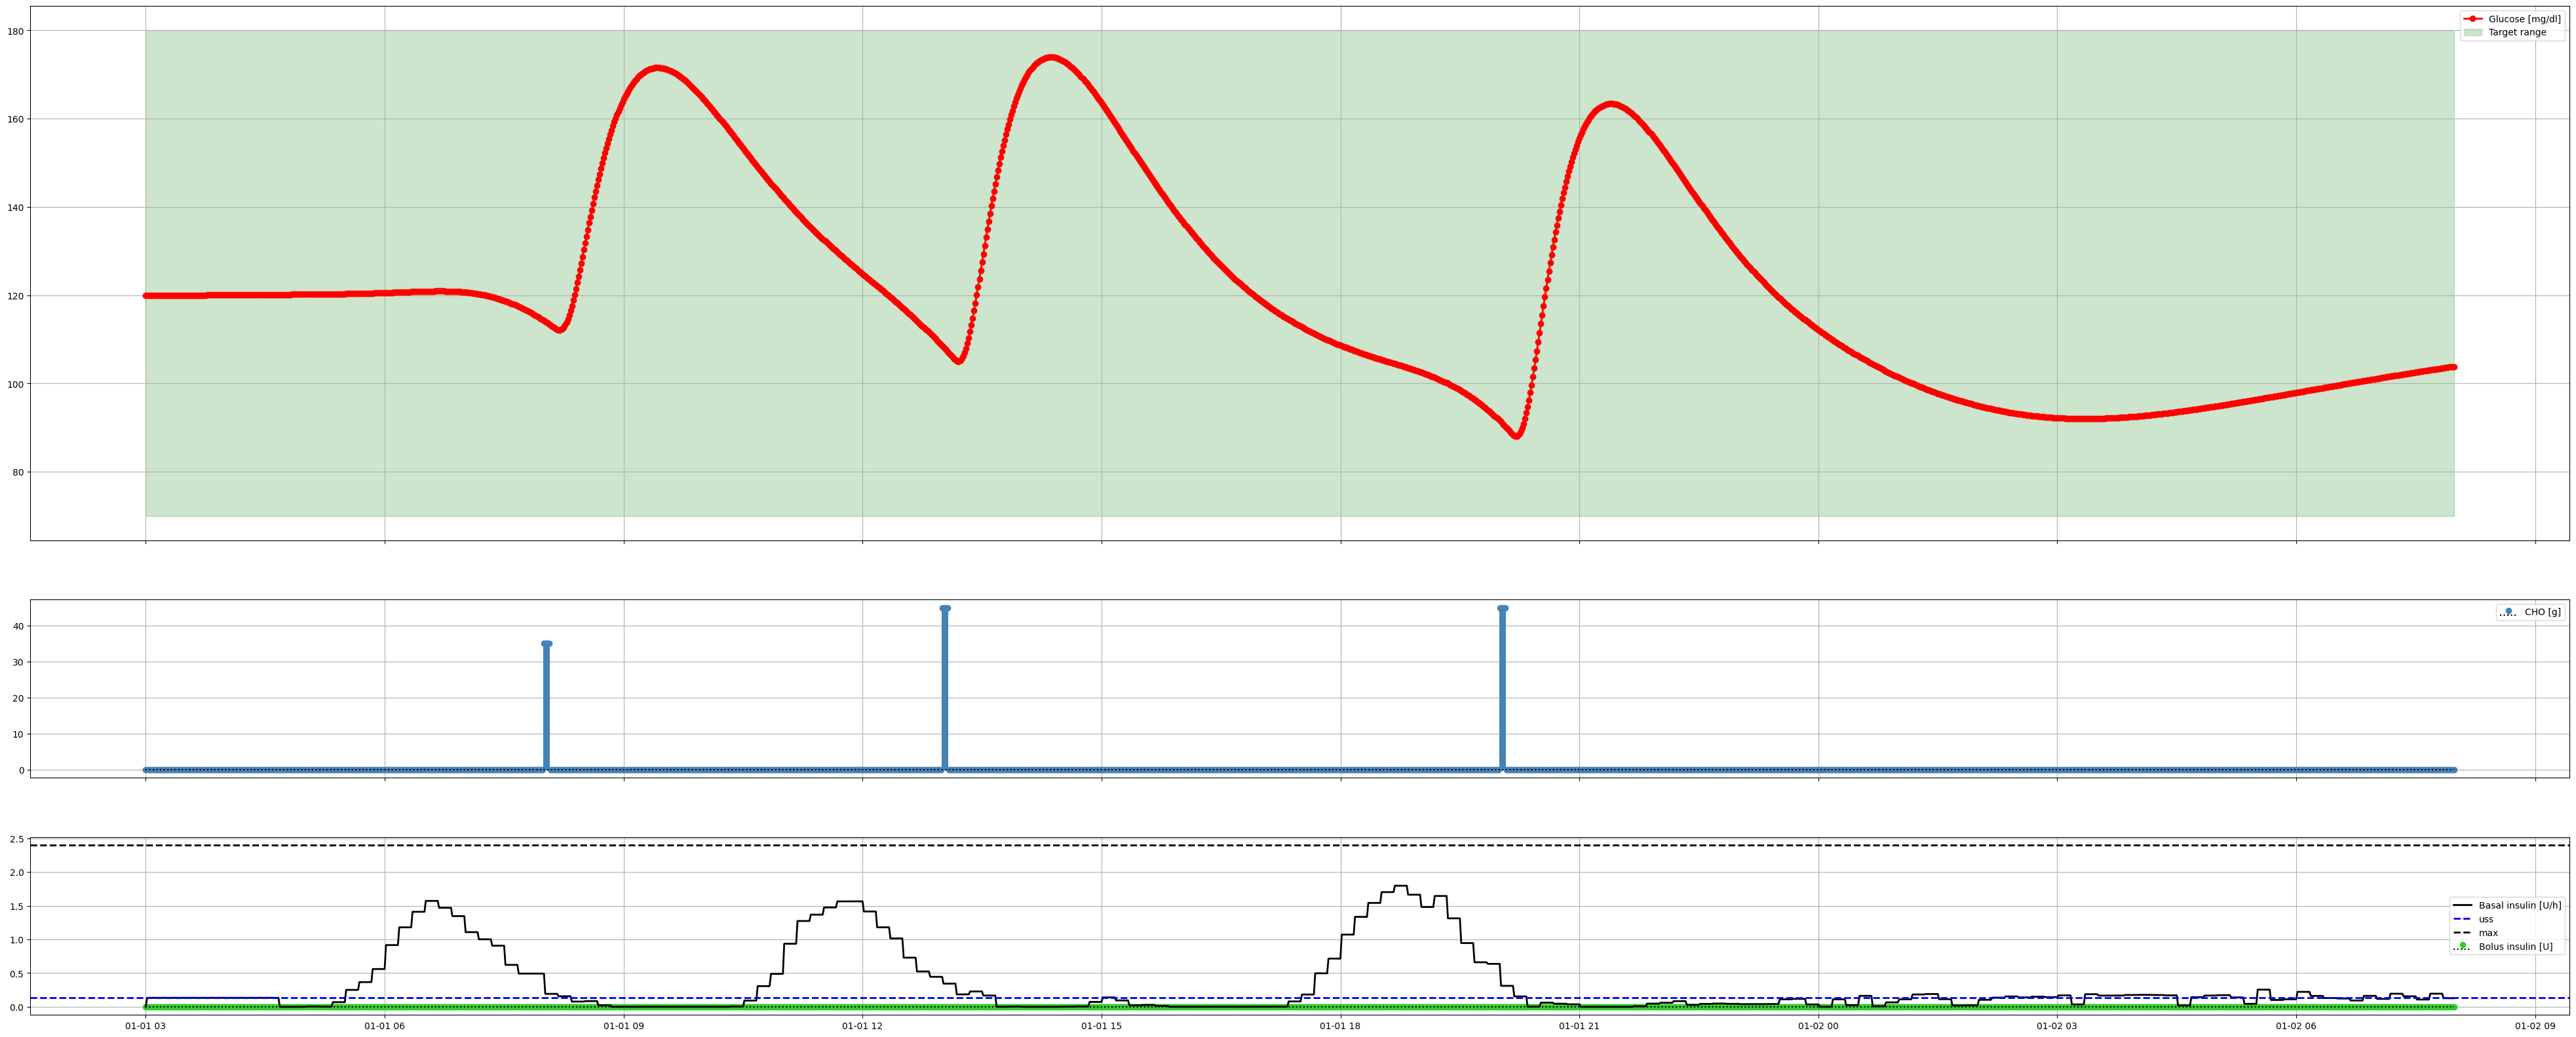

In [25]:
##################################### Run Simulation -  Bonus ###################################
# Initialize the dict to save inputs
basal_handler_params = dict()
basal_handler_params['open-loop input'] = None

# Get the data
# data_given = pd.read_csv('data/max_data.csv')
# data_given = pd.read_csv('data/data_cho.csv')
data_given = pd.read_csv('data/default_data.csv')

print_output = True

# Instatiating DeePC
if use_noise:
    controller_DeePC_bonus = DeePController_bonus(T_past, T_fut, num_hankel_cols_d, q1_noisy, r1_noisy, lambda_g_noisy, lambda_sigma_noisy, s_noisy, sampling_time, discret_time, H_noisy, print_output=print_output)
else:
    controller_DeePC_bonus = DeePController_bonus(T_past, T_fut, num_hankel_cols_d, q1, r1, lambda_g, lambda_sigma, s, sampling_time, discret_time, H, print_output=print_output)

# Running the simulation
print("------ START ------")
glucose, i, insulin_bolus, m, time = simulate(basal_handler=controller_DeePC_bonus.compute_DeePC,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)
print("------ FINISH ------")
print("Total infeasible solutions:", np.round((controller_DeePC_bonus.num_infeas) / len(controller_DeePC_bonus.tot_cost[1:]) * 100, 2), "%")
data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)
if use_noise:
    title = 'DeePC Controller - Measuring noisy $G$'
    name_png = 'task_05_deepc_bonus_noise.png'
else:
    title = 'DeePC Controller - Measuring $G$'
    name_png = 'task_05_deepc_bonus.png'

save = False
plot_save_results_presentation(glucose=glucose, insulin_bolus=insulin_bolus, i=i, m=m, time=time, plot=False, title=title, save=save, save_name=name_png, save_path='img')

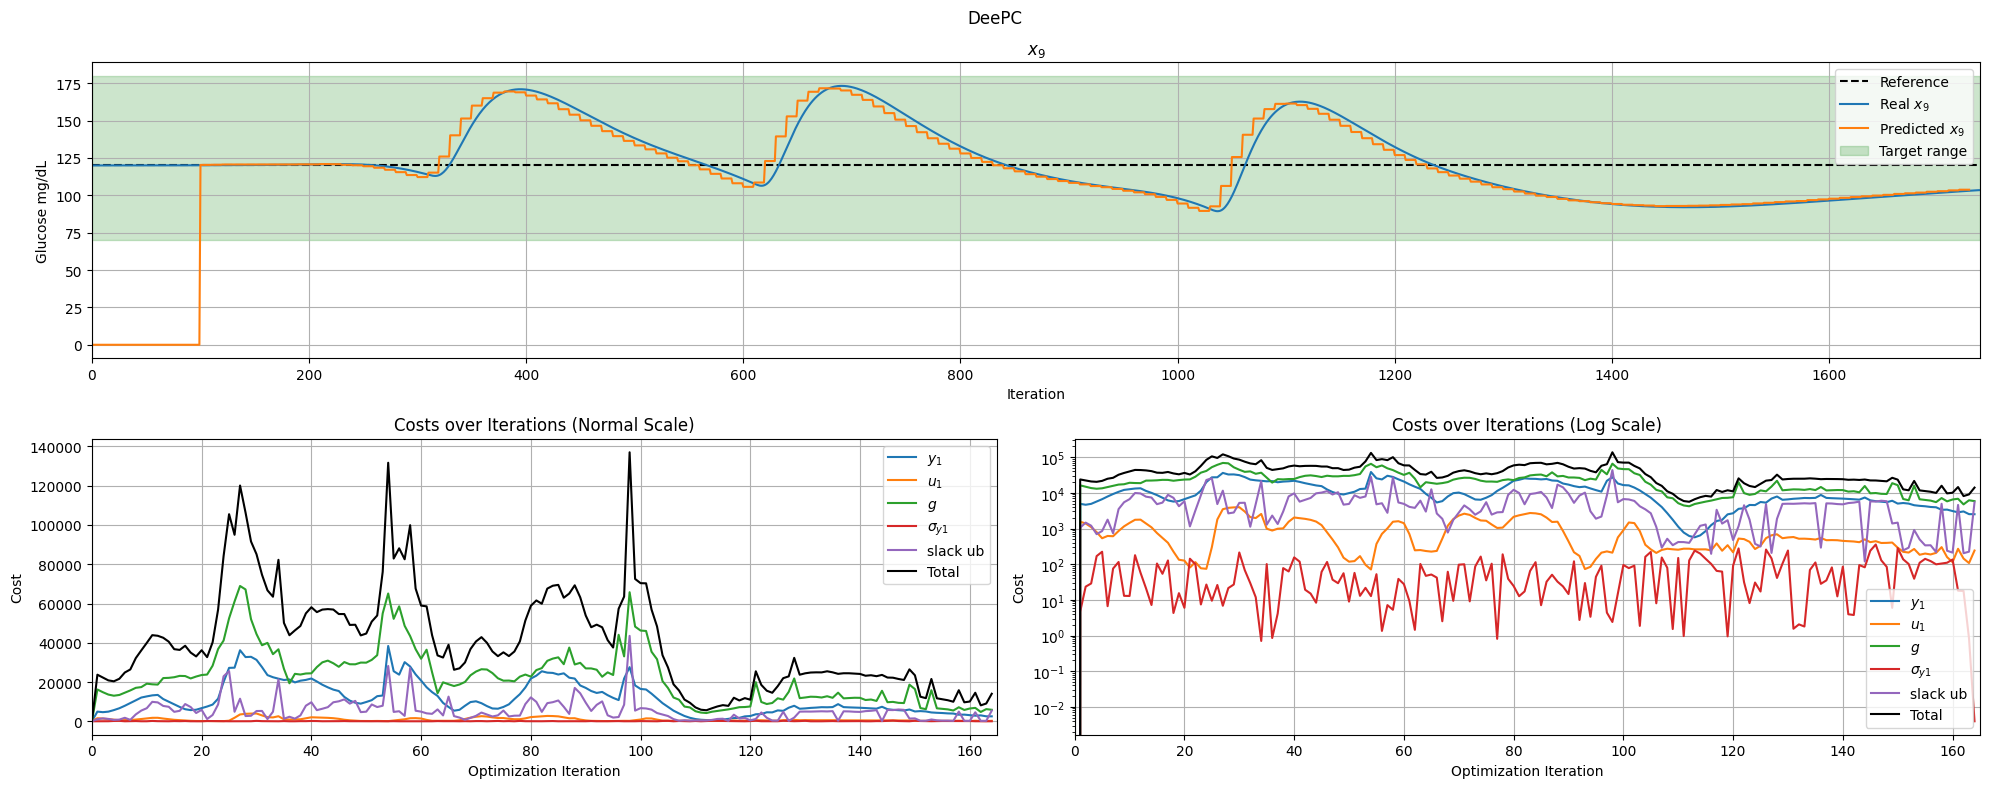

In [26]:
##################################### Post-Processing - Additional Plots - Bonus ###################################
tot_cost = controller_DeePC_bonus.tot_cost
y1_cost = np.zeros(controller_DeePC_bonus.y1_var_open_loop.shape[0])
u1_cost = np.zeros(controller_DeePC_bonus.u1_var_open_loop.shape[0])
g_cost = np.zeros(controller_DeePC_bonus.g_var_open_loop.shape[0])
sigma_y1_cost = np.zeros(controller_DeePC_bonus.sigma_y1_var_open_loop.shape[0])
slack_y1_ub_cost = np.zeros(controller_DeePC_bonus.slack_y1_ub_var_open_loop.shape[0])
g_zero_norm = np.zeros(controller_DeePC_bonus.g_var_open_loop.shape[0])

for i in range(1, controller_DeePC_bonus.y1_var_open_loop.shape[0]):
    # Set to zero if no cost, meaning no optimization was performed
    if controller_DeePC_bonus.tot_cost[i] == 0:
        # Set all costs to zero
        y1_cost[i] = 0
        u1_cost[i] = 0
        g_cost[i] = 0
        sigma_y1_cost[i] = 0
        slack_y1_ub_cost[i] = 0
        g_zero_norm[i] = 0
    else:
        y1_cost[i] = (controller_DeePC_bonus.y1_var_open_loop[i,:] - controller_DeePC_bonus.y1_ref).T @ controller_DeePC_bonus.Q1 @ (controller_DeePC_bonus.y1_var_open_loop[i,:] - controller_DeePC_bonus.y1_ref)
        u1_cost[i] = (controller_DeePC_bonus.u1_var_open_loop[i,:] - controller_DeePC_bonus.u1_ref).T @ controller_DeePC_bonus.R1 @ (controller_DeePC_bonus.u1_var_open_loop[i,:] - controller_DeePC_bonus.u1_ref)
        g_cost[i] = np.linalg.norm(controller_DeePC_bonus.g_var_open_loop[i,:], 1) * controller_DeePC_bonus.lambda_g
        sigma_y1_cost[i] = np.linalg.norm(controller_DeePC_bonus.sigma_y1_var_open_loop[i,:], 1) * controller_DeePC_bonus.lambda_sigma
        slack_y1_ub_cost[i] = controller_DeePC_bonus.slack_y1_ub_var_open_loop[i,:].T @ controller_DeePC_bonus.S @ controller_DeePC_bonus.slack_y1_ub_var_open_loop[i,:]
        g_zero_norm[i] = np.linalg.norm(controller_DeePC_bonus.g_var_open_loop[i,:], 0)

# Value used to account for optimization right after T_past
estim_used_first_iter = (T_past // sampling_time + 1) * sampling_time - T_past

y1_open_loop = np.repeat(controller_DeePC_bonus.y1_var_open_loop[1:,:], discret_time, axis=1)
y1_estimation = np.append(np.zeros((1, T_past)), y1_open_loop[1,:estim_used_first_iter]) # need to consider the first optimization
y1_estimation = np.append(y1_estimation, y1_open_loop[2:,:sampling_time].reshape(-1,1))

x_max = len(controller_DeePC_bonus.x9)

fig = plt.figure(figsize=(20, 8))
fig.suptitle('DeePC')
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
ax1.axhline(y=controller_DeePC_bonus.y1_ref[0], color='k', linestyle='--', label='Reference')
ax1.plot(controller_DeePC_bonus.x9, label=r'Real $x_9$')
ax1.plot(y1_estimation, label=r'Predicted $x_9$')
ax1.fill_between(np.array([0, x_max]), np.array([70, 70]), np.array([180, 180]), color='green', alpha=0.2, label='Target range')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Glucose mg/dL')
ax1.set_title(r'$x_9$')
ax1.legend()
ax1.grid()
ax1.set_xlim(0, x_max)

# Variables for the loop
plots_info = [
    (fig.add_subplot(gs[1, 0]), 'Costs over Iterations (Normal Scale)', 'linear'),
    (fig.add_subplot(gs[1, 1]), 'Costs over Iterations (Log Scale)', 'log')
    ]
costs_data = [
    (y1_cost, r'$y_1$'),
    (u1_cost, r'$u_1$'),
    (g_cost, r'$g$'),
    (sigma_y1_cost, r'$\sigma_{y1}$'),
    (slack_y1_ub_cost, 'slack ub'),
    (tot_cost, 'Total', 'k')
    ]
# Costs
for ax, title, yscale in plots_info:
    for data, label, *color in costs_data:
        ax.plot(data, label=label, color=color[0] if color else None)
    ax.set_xlabel('Optimization Iteration')
    ax.set_ylabel('Cost')
    ax.set_title(title)
    ax.legend()
    ax.grid()
    ax.set_xlim(0, len(tot_cost))
    ax.set_yscale(yscale)

plt.tight_layout()
plt.show()
plt.close()

### Outlook

A non-exhaustive list of other possible and interesting controllers includes
- Model-free and model-based reinforcement learning,
- State estimators combined with MPC using only glucose concentration measurements,
- DeePC with data acquisition during simulation and adaptive $\mathcal{H}$,
- PID controller with simple Smith predictor,
- Robust MPC for large meals, exercise, and noise,
- Stochastic meal estimation given patient eating patterns,
- ...